# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import copy

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import DataLoader

from torch.utils.data import Sampler
import numpy as np
import os
import json
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import torch
import numpy as np
import math
from torch.utils.data import DataLoader

import glob

device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Inputs

In [60]:
#shape (Num, Channels, Timesteps)
Input_path = '/kaggle/input/data-usa/Site_B/x-2020.npy' 
#shape (Num)
Labels_path = '/kaggle/input/data-usa/Site_B/y-2020.npy'

# for the acquired labelled datasets
base_dir = "/kaggle/input/complete-al-datasets"


backbone_model_path = '/kaggle/input/active-learning-subset/backboneSiteA2019.pth'
fc_model_path = '/kaggle/input/active-learning-subset/fcSiteA2019.pth'

"""
----------------------------------------------------------------------------------------
Loss Function selection
Currently available:
"ce = cross entropy loss","ls = LabelSmoothingCrossEntropyLoss"
"""
loss_mode = "ce"



batch_size = 64
epochs = 50
test_size = 0.005
lr = 1e-3
weight_decay = 1e-4
label_smoothing = 0.1
ignore_index = -100

# Data Loader

In [61]:
X = np.load(Input_path) 
y = np.load(Labels_path)

print("X", X.shape)
print("y", y.shape)

X (1943716, 28, 6)
y (1943716,)


In [62]:
def print_distribution(labels, name=""):
    counts = Counter(labels)
    total = sum(counts.values())
    print(f"Distribution in {name}:")
    for label in sorted(counts):
        pct = 100 * counts[label] / total
        print(f"  Class {label}: {counts[label]} ({pct:.1f}%)")


In [63]:
def compute_band_means_stds(X):
    """Compute per-band mean and std."""
    band_means = X.mean(axis=(0, 1))
    band_stds = X.std(axis=(0, 1))
    return band_means, band_stds


def print_stats_and_class_distribution(band_means, band_stds, y):
    """Print per-band stats and class distribution tables."""
    # Per-band stats
    df_stats = pd.DataFrame({
        'Band': [f'Band {i+1}' for i in range(len(band_means))],
        'Mean': band_means,
        'Std': band_stds
    })
    print("\nPer-Band Statistics:")
    print(df_stats.to_string(index=False))
    
    # Class distribution
    total_samples = len(y)
    class_counts = Counter(y)
    df_classes = pd.DataFrame({
        'Class': sorted(class_counts.keys()),
        'Count': [class_counts[c] for c in sorted(class_counts.keys())],
        'Percentage': [100 * class_counts[c] / total_samples for c in sorted(class_counts.keys())]
    })
    print("\nClass Distribution:")
    print(df_classes.to_string(index=False))



def normalize_data(X, band_means, band_stds):
    """Normalize data per band using provided means & stds."""
    band_means = band_means.reshape(1, 1, -1)
    band_stds = band_stds.reshape(1, 1, -1)
    return (X - band_means) / band_stds


def plot_band_histograms(X, bins=100):
    """Plot histograms for each band in a compact grid layout."""
    n_bands = X.shape[2]
    cols = 3  # number of histograms per row
    rows = math.ceil(n_bands / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()

    for b in range(n_bands):
        axes[b].hist(X[:, :, b].ravel(), bins=bins, color='blue', alpha=0.7)
        axes[b].set_title(f'Band {b+1}')
        axes[b].set_xlabel('Value')
        axes[b].set_ylabel('Freq')

    # Hide any unused subplots
    for i in range(n_bands, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def compute_class_weights(y, device=device):
    y = np.asarray(y)
    n_classes = int(y.max()) + 1  # infer number of classes

    class_counts = np.bincount(y, minlength=n_classes)
    total_samples = len(y)

    # Avoid division by zero
    class_counts[class_counts == 0] = 1  

    # Inverse frequency
    weights = total_samples / (n_classes * class_counts)

    weights = torch.tensor(weights, dtype=torch.float32)
    if device is not None:
        weights = weights.to(device)
    return weights


Before Normalisation

Global Mean: 13128.1928
Global Std Dev: 4500.1056

Per-Band Statistics:
  Band         Mean         Std
Band 1  9293.733228 1062.082785
Band 2 10402.398597 1328.240256
Band 3 10579.100408 1999.108175
Band 4 18968.755462 4274.731394
Band 5 16319.443111 3346.284815
Band 6 13205.726006 3494.697194

Class Distribution:
 Class  Count  Percentage
     0 871034   44.812822
     1 260775   13.416312
     2 811907   41.770866


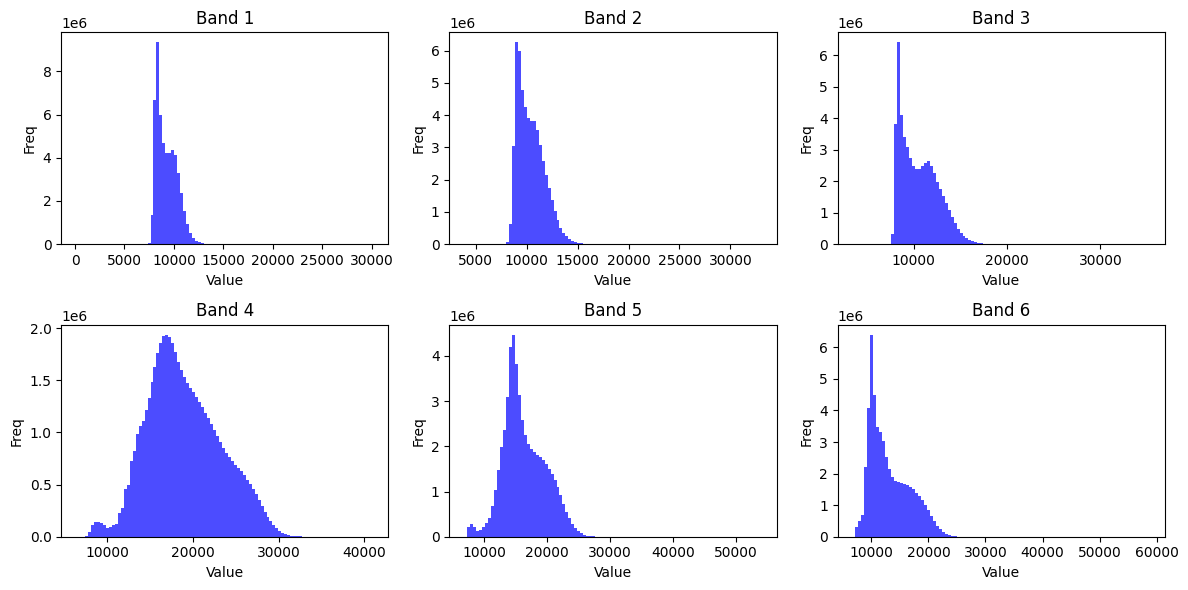

After Normalisation

Global Mean: -0.0000
Global Std Dev: 1.0000

Per-Band Statistics:
  Band          Mean  Std
Band 1 -1.345729e-12  1.0
Band 2 -2.484386e-13  1.0
Band 3 -2.335222e-13  1.0
Band 4  2.551672e-13  1.0
Band 5 -3.438020e-14  1.0
Band 6 -2.264402e-13  1.0

Class Distribution:
 Class  Count  Percentage
     0 871034   44.812822
     1 260775   13.416312
     2 811907   41.770866


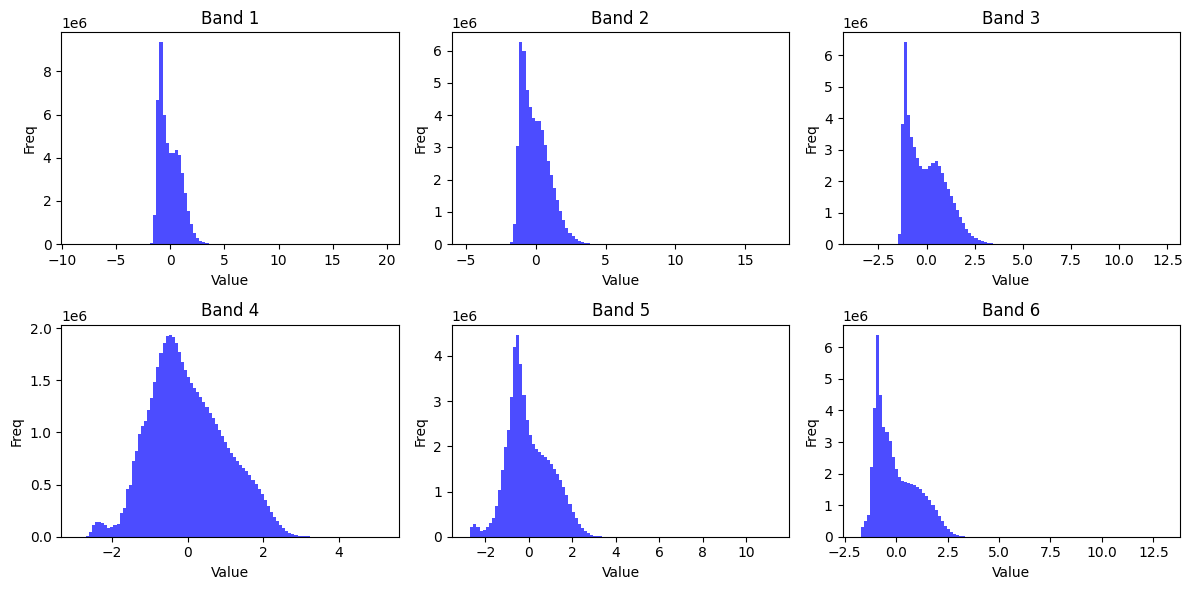

Class Weights: tensor([0.7438, 2.4845, 0.7980], device='cuda:0')


In [64]:
print("Before Normalisation")
print(f"\nGlobal Mean: {X.mean():.4f}")
print(f"Global Std Dev: {X.std():.4f}")
band_means, band_stds = compute_band_means_stds(X)
print_stats_and_class_distribution(band_means, band_stds, y)
plot_band_histograms(X)

X = normalize_data(X, band_means, band_stds)

print("After Normalisation")
print(f"\nGlobal Mean: {X.mean():.4f}")
print(f"Global Std Dev: {X.std():.4f}")
band_means, band_stds = compute_band_means_stds(X)
print_stats_and_class_distribution(band_means, band_stds, y)
plot_band_histograms(X)


class_weights = compute_class_weights(y, device=device)
print(f"Class Weights: {class_weights}")


# Dataset

In [65]:
_, X_val, _, y_val = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)


print("X_val", X_val.shape)
print("y_val", y_val.shape)

X_val (9719, 28, 6)
y_val (9719,)


In [66]:
class Dataset():
    def __init__(self, X, y):
        self.X = torch.tensor(X.transpose(0,2,1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __getitem__(self, index):
        return {
            "x": self.X[index],  # shape: [C, T]
            "y": self.y[index]
        }

    def __len__(self):
        return len(self.X)

# Loss Functions

In [67]:
class Loss:
    def __init__(self, weight=None, ignore_index=-100, device=None, smoothing=0.1):
        self.weight = weight
        self.ignore_index = ignore_index
        self.device = device
        self.smoothing = smoothing
        self.criterion = None
        self.loss_func = None

    def build(self, mode='ce'):
        """
        Available modes: 'ce', 'ls'
        """
        if mode == 'ce':
            self.criterion = nn.CrossEntropyLoss(weight=self.weight, ignore_index=self.ignore_index)
            self.loss_func = self.cross_entropy_loss

        elif mode == 'ls':
            self.loss_func = self.label_smoothing_loss

        else:
            raise NotImplementedError(f"Loss mode '{mode}' is not implemented.")

        if self.device is not None and self.criterion is not None:
            self.criterion = self.criterion.to(self.device)

        return self.loss_func

    def cross_entropy_loss(self, logits, targets):
        return self.criterion(logits, targets)

    def label_smoothing_loss(self, logits, targets):
        log_probs = F.log_softmax(logits, dim=-1)
        
        valid = targets != self.ignore_index
        log_probs = log_probs[valid]
        targets = targets[valid]
        
        nll_loss = -log_probs.gather(dim=-1, index=targets.unsqueeze(1)).squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = (1.0 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
    
        if self.weight is not None:
            weight = self.weight.to(logits.device)
            loss = loss * weight[targets]
    
        return loss.mean()


# Model

In [68]:
################ CNN Backbone 
def conv_block(in_channels: int, out_channels: int, dropout=0.3) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5, padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
        nn.Dropout(dropout),
    )

class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = conv_block(6, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512)
        self.conv5 = conv_block(512, 1024)
        self.global_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return x

 
################ Fully connected network
class FC(nn.Module):
    def __init__(self, input_dim):
        super(FC, self).__init__()
        self.dropout = nn.Dropout(0.3)
        self.fco = nn.Linear(input_dim, 3)

    def forward(self, x):
        x = self.dropout(x)
        x = self.fco(x)
        return x



class FullModel(nn.Module):
    def __init__(self, backbone, fc):
        super().__init__()
        self.backbone = backbone
        self.fc = fc

    def forward(self, x):
        feat = self.backbone(x)
        out = self.fc(feat)
        return feat, out

In [69]:
#pretrained weights
map_location=torch.device(device)

backbone = cnn()
fc = FC(1024)

#loading backbone weights
state_dict = torch.load(backbone_model_path, map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

backbone.load_state_dict(new_state_dict)

#loading fc weights
state_dict = torch.load(fc_model_path, map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

fc.load_state_dict(new_state_dict)

model = FullModel(backbone, fc).to(device)
initial_state_dict = copy.deepcopy(model.state_dict())

# Train/eval loop

In [70]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss, all_preds, all_targets = 0, [], []
    
    for batch in dataloader:
        x, y = batch["x"].to(device), batch["y"].to(device)

        optimizer.zero_grad()
        _, out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(x)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

    avg_loss = total_loss / len(dataloader.dataset)
    acc = np.mean(np.array(all_preds) == np.array(all_targets))
    f1s = sklearn.metrics.f1_score(all_targets, all_preds, average=None)
    return avg_loss, acc, f1s, np.mean(f1s)



def _eval_perf(model, dataloader, device, loss_fn=None):
    model.eval()
    pred, gt = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation", leave=False):
            x, y = batch["x"].to(device), batch["y"].to(device)
            _, outputs = model(x)
            preds = torch.argmax(outputs, dim=1)
            if loss_fn:
                total_loss += loss_fn(outputs, y).item() * len(x)

            pred.extend(preds.cpu().numpy())
            gt.extend(y.cpu().numpy())

    acc = np.mean(np.array(pred) == np.array(gt))
    f1s = sklearn.metrics.f1_score(gt, pred, average=None)
    avg_f1 = np.mean(f1s)

    if loss_fn:
        avg_loss = total_loss / len(dataloader.dataset)
        return avg_loss, f1s, acc, avg_f1
    else:
        return 0, f1s, acc, avg_f1


In [71]:
def plot_training_curves(epoch_stats):
    epochs = [e["epoch"] for e in epoch_stats]
    train_loss = [e["train_loss"] for e in epoch_stats]
    val_loss   = [e["val_loss"] for e in epoch_stats]
    train_acc  = [e["train_acc"] for e in epoch_stats]
    val_acc    = [e["val_acc"] for e in epoch_stats]
    train_f1   = [e["train_avg_f1"] for e in epoch_stats]
    val_f1     = [e["val_avg_f1"] for e in epoch_stats]

    # === LOSS PLOT ===
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    title = "Loss Curve"
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # === ACCURACY PLOT ===
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    title = "Accuracy Curve"
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # === F1 PLOT ===
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_f1, label="Train F1")
    plt.plot(epochs, val_f1, label="Val F1")
    title = "F1 Curve"
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Average F1")
    plt.legend()
    plt.grid(True)
    plt.show()


# Full Training/ Final test loop

In [72]:
def learning_loop(model, train_dataset, val_dataset, device, final_epochs=10, loss_mode='ce', batch_size=16, class_weights = class_weights ):

    loss_handler = Loss(weight=class_weights, ignore_index=ignore_index, device=device, smoothing=label_smoothing)
    loss_fn = loss_handler.build(mode=loss_mode)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    epoch_stats = []
    epochs = final_epochs

    for ep in range(epochs):
        tr_loss, tr_acc, tr_f1s, tr_avgf1 = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss, val_f1s, val_acc, val_avgf1 = _eval_perf(model, val_loader, device, loss_fn)

        epoch_stats.append({
            "epoch": ep,
            "train_loss": tr_loss,
            "train_acc": tr_acc,
            "train_avg_f1": tr_avgf1,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "val_avg_f1": val_avgf1
        })

        print(f"\nEpoch {ep+1}/{epochs}")
        print(f"Train — Loss: {tr_loss:.4f} | Acc: {tr_acc:.4f} | Avg F1: {tr_avgf1:.4f}")
        print(f"Val   — Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Avg F1: {val_avgf1:.4f}")

        scheduler.step(val_loss)


    plot_training_curves(epoch_stats)
    
    return epoch_stats

In [73]:
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, cohen_kappa_score
from tqdm import tqdm

def evaluate_model(model, test_dataset, device="cuda", batch_size=64):
    model.eval()
    all_preds, all_labels = [], []

    dataloader = DataLoader(test_dataset, batch_size=batch_size)
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Final Test", leave=False):
            x = batch["x"].to(device)
            y = batch["y"].to(device)

            # Model outputs (features, logits)
            _, logits = model(x)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # === Metrics ===
    cm = confusion_matrix(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    micro_f1 = f1_score(all_labels, all_preds, average="micro")
    weighted_f1 = f1_score(all_labels, all_preds, average="weighted")
    per_class_f1 = f1_score(all_labels, all_preds, average=None)
    kappa = cohen_kappa_score(all_labels, all_preds)

    results = {
        "confusion_matrix": cm,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
        "weighted_f1": weighted_f1,
        "per_class_f1": per_class_f1,
        "kappa": kappa,
    }

    # === Pretty print ===
    print("\n=== Final Evaluation Results ===")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Macro F1     : {macro_f1:.4f}")
    print(f"Micro F1     : {micro_f1:.4f}")
    print(f"Weighted F1  : {weighted_f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}\n")

    print("Per-class F1 scores:")
    for i, f1 in enumerate(per_class_f1):
        print(f"  Class {i}: {f1:.4f}")

    print("\nConfusion Matrix:")
    print(cm)

    return results


In [74]:
def load_xy_from_npz(file_path):
    """
    Load X and y from a saved .npz file.
    
    Args:
        file_path (str): Path to the .npz file.
    
    Returns:
        X (numpy.ndarray): The features array.
        y (numpy.ndarray): The labels array.
    """
    with np.load(file_path) as data:
        X = data["X"]
        y = data["y"]
    return X, y

def get_npz_paths(base_dir):
    all_paths = []
    for d in base_dir:
        npz_files = glob.glob(os.path.join(d, "*.npz"))
        all_paths.extend(npz_files)
    return sorted(all_paths)

def save_json(data, out_path):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    with open(out_path, "w") as f:
        json.dump(data, f, indent=4, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)



# Experiments

In [75]:
for i, path in enumerate(data_paths):

    fname = os.path.splitext(os.path.basename(path))[0]
    print(f"\n=== Run {i+1}/{len(data_paths)} — {fname} ===")

    #Loading data
    X_final_labeled, y_final_labeled = load_xy_from_npz(path)

    if X_final_labeled.shape[1:] == (6,28):
        X_final_labeled = X_final_labeled.transpose(0,2,1)
    print("X: ",X_final_labeled.shape)
    print("y: ",y_final_labeled.shape)


=== Run 1/4 — true_BCNN_data_bald ===
X:  (14000, 28, 6)
y:  (14000,)

=== Run 2/4 — true_BCNN_data_bvsb ===
X:  (14000, 28, 6)
y:  (14000,)

=== Run 3/4 — true_BCNN_data_predictive_entropy ===
X:  (14000, 28, 6)
y:  (14000,)

=== Run 4/4 — true_BCNN_data_variation_ratio ===
X:  (14000, 28, 6)
y:  (14000,)


Found .npz files:
 - /kaggle/input/complete-al-datasets/approx_BCNN_data_bald.npz
 - /kaggle/input/complete-al-datasets/approx_BCNN_data_bvsb.npz
 - /kaggle/input/complete-al-datasets/approx_BCNN_data_predictive_entropy.npz
 - /kaggle/input/complete-al-datasets/approx_BCNN_data_variation_ratio.npz
 - /kaggle/input/complete-al-datasets/data_random.npz
 - /kaggle/input/complete-al-datasets/deterministic_CNN_data_diversity.npz
 - /kaggle/input/complete-al-datasets/deterministic_CNN_data_entropy.npz
 - /kaggle/input/complete-al-datasets/deterministic_CNN_data_entropy_diversity.npz
 - /kaggle/input/complete-al-datasets/deterministic_CNN_data_margin.npz
 - /kaggle/input/complete-al-datasets/true_BCNN_data_bald.npz
 - /kaggle/input/complete-al-datasets/true_BCNN_data_bvsb.npz
 - /kaggle/input/complete-al-datasets/true_BCNN_data_predictive_entropy.npz
 - /kaggle/input/complete-al-datasets/true_BCNN_data_variation_ratio.npz

=== Run 1/13 — approx_BCNN_data_bald ===
X:  (14000, 28, 6)
y:  (14000

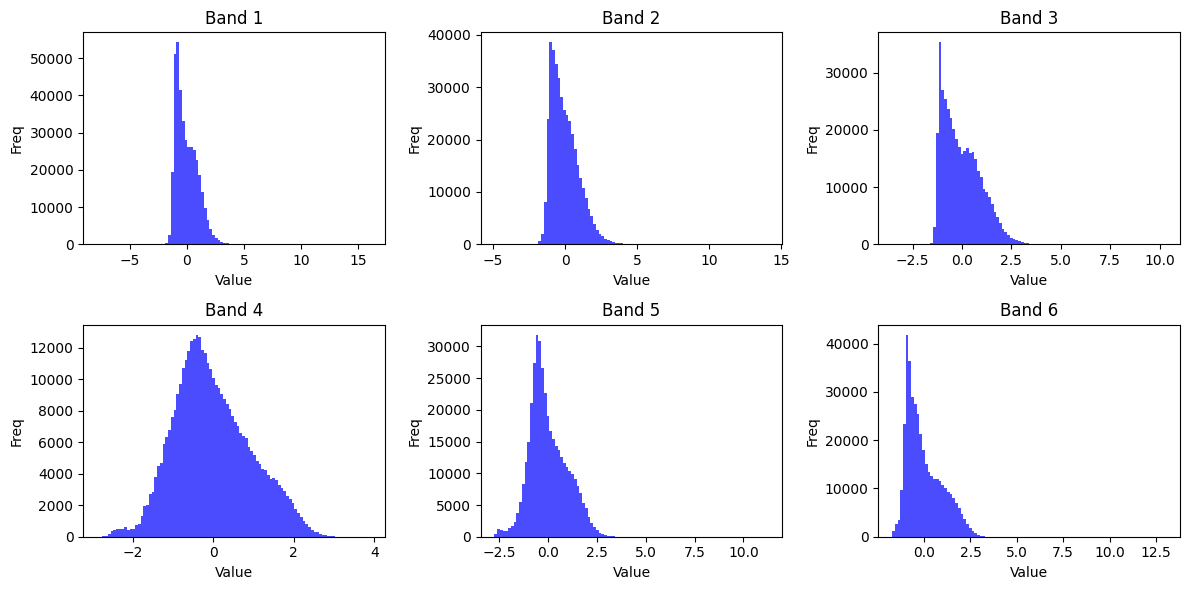

After Normalisation

Global Mean: 0.0000
Global Std Dev: 1.0001

Per-Band Statistics:
  Band          Mean      Std
Band 1  1.239123e-07 0.999999
Band 2  1.320143e-07 1.000010
Band 3  3.288744e-07 0.999999
Band 4  3.062594e-07 0.999978
Band 5 -2.869021e-08 1.000004
Band 6  1.635722e-08 1.000013

Class Distribution:
 Class  Count  Percentage
     0   6333   45.235714
     1   2121   15.150000
     2   5546   39.614286


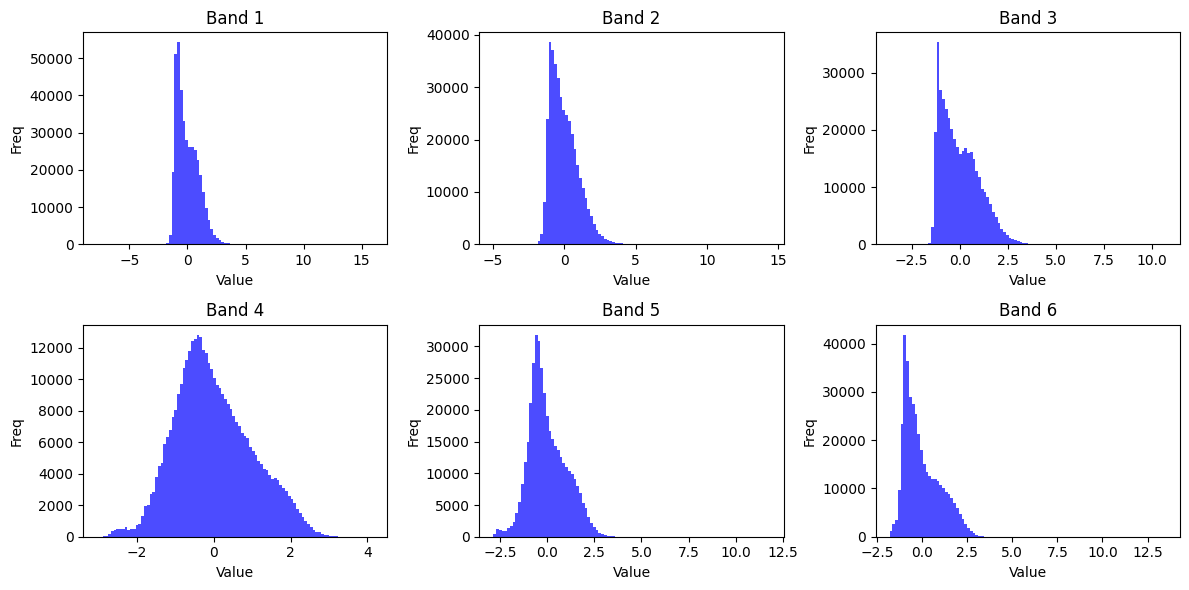

Class Weights: tensor([0.7369, 2.2002, 0.8414], device='cuda:0')



Epoch 1/50
Train — Loss: 0.9793 | Acc: 0.5846 | Avg F1: 0.5799
Val   — Loss: 0.6169 | Acc: 0.6636 | Avg F1: 0.6760



Epoch 2/50
Train — Loss: 0.7449 | Acc: 0.6381 | Avg F1: 0.6315
Val   — Loss: 0.3688 | Acc: 0.8215 | Avg F1: 0.8209



Epoch 3/50
Train — Loss: 0.7019 | Acc: 0.6549 | Avg F1: 0.6477
Val   — Loss: 0.3205 | Acc: 0.8490 | Avg F1: 0.8494



Epoch 4/50
Train — Loss: 0.6745 | Acc: 0.6707 | Avg F1: 0.6625
Val   — Loss: 0.3138 | Acc: 0.8612 | Avg F1: 0.8582



Epoch 5/50
Train — Loss: 0.6514 | Acc: 0.6856 | Avg F1: 0.6777
Val   — Loss: 0.2934 | Acc: 0.8699 | Avg F1: 0.8697



Epoch 6/50
Train — Loss: 0.6304 | Acc: 0.6981 | Avg F1: 0.6893
Val   — Loss: 0.2957 | Acc: 0.8696 | Avg F1: 0.8657



Epoch 7/50
Train — Loss: 0.6134 | Acc: 0.7018 | Avg F1: 0.6927
Val   — Loss: 0.2967 | Acc: 0.8702 | Avg F1: 0.8697



Epoch 8/50
Train — Loss: 0.6075 | Acc: 0.7071 | Avg F1: 0.6972
Val   — Loss: 0.3131 | Acc: 0.8519 | Avg F1: 0.8521



Epoch 9/50
Train — Loss: 0.5927 | Acc: 0.7178 | Avg F1: 0.7079
Val   — Loss: 0.2938 | Acc: 0.8651 | Avg F1: 0.8646



Epoch 10/50
Train — Loss: 0.5955 | Acc: 0.7200 | Avg F1: 0.7092
Val   — Loss: 0.2850 | Acc: 0.8773 | Avg F1: 0.8736



Epoch 11/50
Train — Loss: 0.5772 | Acc: 0.7236 | Avg F1: 0.7139
Val   — Loss: 0.2697 | Acc: 0.8828 | Avg F1: 0.8800



Epoch 12/50
Train — Loss: 0.5716 | Acc: 0.7281 | Avg F1: 0.7183
Val   — Loss: 0.2668 | Acc: 0.8818 | Avg F1: 0.8805



Epoch 13/50
Train — Loss: 0.5573 | Acc: 0.7331 | Avg F1: 0.7236
Val   — Loss: 0.2729 | Acc: 0.8767 | Avg F1: 0.8733



Epoch 14/50
Train — Loss: 0.5503 | Acc: 0.7375 | Avg F1: 0.7276
Val   — Loss: 0.2634 | Acc: 0.8844 | Avg F1: 0.8861



Epoch 15/50
Train — Loss: 0.5410 | Acc: 0.7444 | Avg F1: 0.7346
Val   — Loss: 0.2829 | Acc: 0.8678 | Avg F1: 0.8672



Epoch 16/50
Train — Loss: 0.5341 | Acc: 0.7430 | Avg F1: 0.7336
Val   — Loss: 0.2653 | Acc: 0.8797 | Avg F1: 0.8773



Epoch 17/50
Train — Loss: 0.5271 | Acc: 0.7511 | Avg F1: 0.7422
Val   — Loss: 0.2619 | Acc: 0.8820 | Avg F1: 0.8809



Epoch 18/50
Train — Loss: 0.5307 | Acc: 0.7499 | Avg F1: 0.7401
Val   — Loss: 0.2663 | Acc: 0.8819 | Avg F1: 0.8819



Epoch 19/50
Train — Loss: 0.5199 | Acc: 0.7546 | Avg F1: 0.7445
Val   — Loss: 0.2622 | Acc: 0.8831 | Avg F1: 0.8833



Epoch 20/50
Train — Loss: 0.5147 | Acc: 0.7564 | Avg F1: 0.7464
Val   — Loss: 0.2612 | Acc: 0.8813 | Avg F1: 0.8796



Epoch 21/50
Train — Loss: 0.5085 | Acc: 0.7614 | Avg F1: 0.7525
Val   — Loss: 0.2743 | Acc: 0.8738 | Avg F1: 0.8746



Epoch 22/50
Train — Loss: 0.4967 | Acc: 0.7644 | Avg F1: 0.7547
Val   — Loss: 0.2527 | Acc: 0.8881 | Avg F1: 0.8889



Epoch 23/50
Train — Loss: 0.5008 | Acc: 0.7623 | Avg F1: 0.7534
Val   — Loss: 0.2520 | Acc: 0.8923 | Avg F1: 0.8950



Epoch 24/50
Train — Loss: 0.4938 | Acc: 0.7669 | Avg F1: 0.7579
Val   — Loss: 0.2527 | Acc: 0.8863 | Avg F1: 0.8870



Epoch 25/50
Train — Loss: 0.4883 | Acc: 0.7720 | Avg F1: 0.7626
Val   — Loss: 0.2570 | Acc: 0.8830 | Avg F1: 0.8818



Epoch 26/50
Train — Loss: 0.4822 | Acc: 0.7765 | Avg F1: 0.7675
Val   — Loss: 0.2528 | Acc: 0.8904 | Avg F1: 0.8906



Epoch 27/50
Train — Loss: 0.4837 | Acc: 0.7747 | Avg F1: 0.7657
Val   — Loss: 0.2408 | Acc: 0.8968 | Avg F1: 0.8957



Epoch 28/50
Train — Loss: 0.4636 | Acc: 0.7845 | Avg F1: 0.7762
Val   — Loss: 0.2406 | Acc: 0.8957 | Avg F1: 0.8953



Epoch 29/50
Train — Loss: 0.4562 | Acc: 0.7854 | Avg F1: 0.7774
Val   — Loss: 0.2477 | Acc: 0.8947 | Avg F1: 0.8944



Epoch 30/50
Train — Loss: 0.4621 | Acc: 0.7854 | Avg F1: 0.7770
Val   — Loss: 0.2462 | Acc: 0.8984 | Avg F1: 0.8987



Epoch 31/50
Train — Loss: 0.4567 | Acc: 0.7814 | Avg F1: 0.7727
Val   — Loss: 0.2428 | Acc: 0.8951 | Avg F1: 0.8923



Epoch 32/50
Train — Loss: 0.4440 | Acc: 0.7896 | Avg F1: 0.7831
Val   — Loss: 0.2434 | Acc: 0.8940 | Avg F1: 0.8949



Epoch 33/50
Train — Loss: 0.4383 | Acc: 0.7977 | Avg F1: 0.7901
Val   — Loss: 0.2451 | Acc: 0.8976 | Avg F1: 0.8978



Epoch 34/50
Train — Loss: 0.4397 | Acc: 0.7956 | Avg F1: 0.7872
Val   — Loss: 0.2529 | Acc: 0.8904 | Avg F1: 0.8895



Epoch 35/50
Train — Loss: 0.4087 | Acc: 0.8072 | Avg F1: 0.8002
Val   — Loss: 0.2423 | Acc: 0.9033 | Avg F1: 0.9023



Epoch 36/50
Train — Loss: 0.3950 | Acc: 0.8161 | Avg F1: 0.8096
Val   — Loss: 0.2471 | Acc: 0.8983 | Avg F1: 0.8981



Epoch 37/50
Train — Loss: 0.3905 | Acc: 0.8162 | Avg F1: 0.8107
Val   — Loss: 0.2452 | Acc: 0.8990 | Avg F1: 0.8969



Epoch 38/50
Train — Loss: 0.3783 | Acc: 0.8259 | Avg F1: 0.8209
Val   — Loss: 0.2503 | Acc: 0.8978 | Avg F1: 0.8969



Epoch 39/50
Train — Loss: 0.3831 | Acc: 0.8180 | Avg F1: 0.8122
Val   — Loss: 0.2459 | Acc: 0.9013 | Avg F1: 0.9015



Epoch 40/50
Train — Loss: 0.3723 | Acc: 0.8279 | Avg F1: 0.8233
Val   — Loss: 0.2480 | Acc: 0.8993 | Avg F1: 0.8992



Epoch 41/50
Train — Loss: 0.3482 | Acc: 0.8389 | Avg F1: 0.8358
Val   — Loss: 0.2488 | Acc: 0.9030 | Avg F1: 0.9045



Epoch 42/50
Train — Loss: 0.3454 | Acc: 0.8384 | Avg F1: 0.8339
Val   — Loss: 0.2496 | Acc: 0.9033 | Avg F1: 0.9033



Epoch 43/50
Train — Loss: 0.3390 | Acc: 0.8410 | Avg F1: 0.8374
Val   — Loss: 0.2520 | Acc: 0.9030 | Avg F1: 0.9042



Epoch 44/50
Train — Loss: 0.3382 | Acc: 0.8426 | Avg F1: 0.8380
Val   — Loss: 0.2524 | Acc: 0.9016 | Avg F1: 0.9034



Epoch 45/50
Train — Loss: 0.3260 | Acc: 0.8464 | Avg F1: 0.8438
Val   — Loss: 0.2536 | Acc: 0.9058 | Avg F1: 0.9080



Epoch 46/50
Train — Loss: 0.3237 | Acc: 0.8504 | Avg F1: 0.8480
Val   — Loss: 0.2583 | Acc: 0.9017 | Avg F1: 0.9030



Epoch 47/50
Train — Loss: 0.3181 | Acc: 0.8526 | Avg F1: 0.8492
Val   — Loss: 0.2579 | Acc: 0.9030 | Avg F1: 0.9040



Epoch 48/50
Train — Loss: 0.3120 | Acc: 0.8576 | Avg F1: 0.8562
Val   — Loss: 0.2577 | Acc: 0.9031 | Avg F1: 0.9045



Epoch 49/50
Train — Loss: 0.3081 | Acc: 0.8556 | Avg F1: 0.8542
Val   — Loss: 0.2580 | Acc: 0.9055 | Avg F1: 0.9073



Epoch 50/50
Train — Loss: 0.3011 | Acc: 0.8625 | Avg F1: 0.8603
Val   — Loss: 0.2648 | Acc: 0.9043 | Avg F1: 0.9054


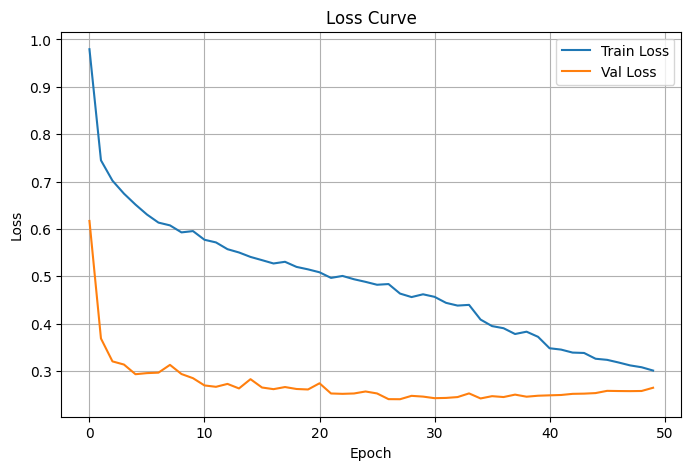

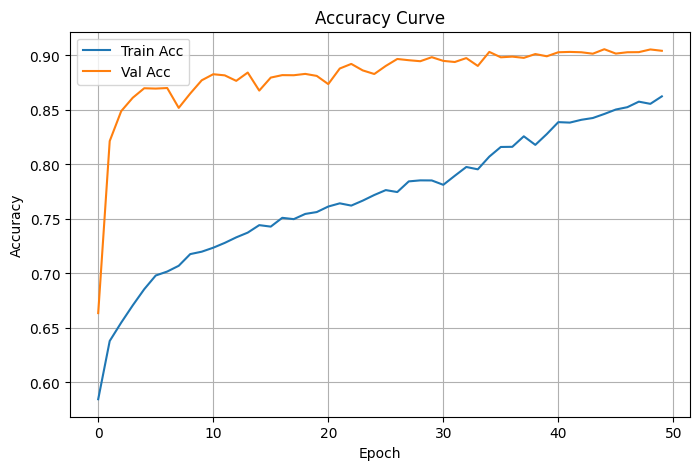

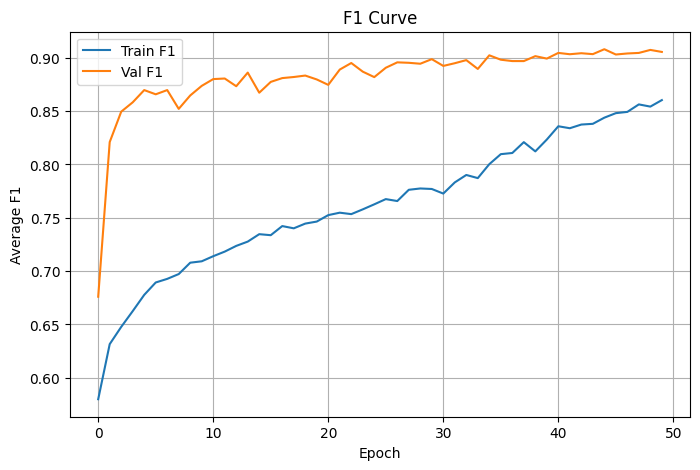


=== Final Evaluation Results ===
Accuracy     : 0.9081
Macro F1     : 0.9099
Micro F1     : 0.9081
Weighted F1  : 0.9080
Cohen's Kappa: 0.8489

Per-class F1 scores:
  Class 0: 0.9075
  Class 1: 0.9163
  Class 2: 0.9060

Confusion Matrix:
[[775752  15575  79707]
 [  8294 243117   9364]
 [ 54559  11211 746137]]
Saved results to results/approx_BCNN_data_bald_results.json

=== Run 2/13 — approx_BCNN_data_bvsb ===
X:  (14000, 28, 6)
y:  (14000,)
Before Normalisation

Global Mean: -0.0015
Global Std Dev: 0.8892

Per-Band Statistics:
  Band      Mean      Std
Band 1 -0.000702 0.920810
Band 2  0.039076 0.904327
Band 3  0.018066 0.895227
Band 4 -0.077383 0.842743
Band 5  0.014938 0.885616
Band 6 -0.002900 0.879375

Class Distribution:
 Class  Count  Percentage
     0   6332   45.228571
     1   1601   11.435714
     2   6067   43.335714


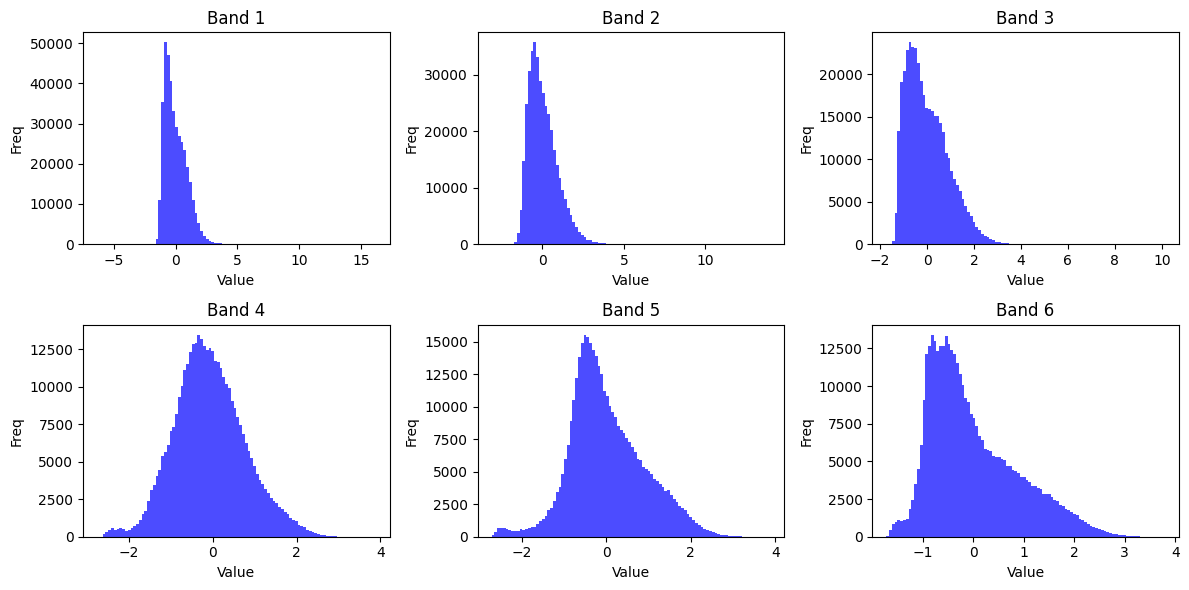

After Normalisation

Global Mean: 0.0000
Global Std Dev: 1.0001

Per-Band Statistics:
  Band          Mean      Std
Band 1  3.072407e-08 1.000015
Band 2  7.676613e-07 0.999991
Band 3  5.413683e-09 0.999984
Band 4  7.144947e-07 0.999999
Band 5  3.880347e-07 0.999995
Band 6 -5.557282e-08 1.000016

Class Distribution:
 Class  Count  Percentage
     0   6332   45.228571
     1   1601   11.435714
     2   6067   43.335714


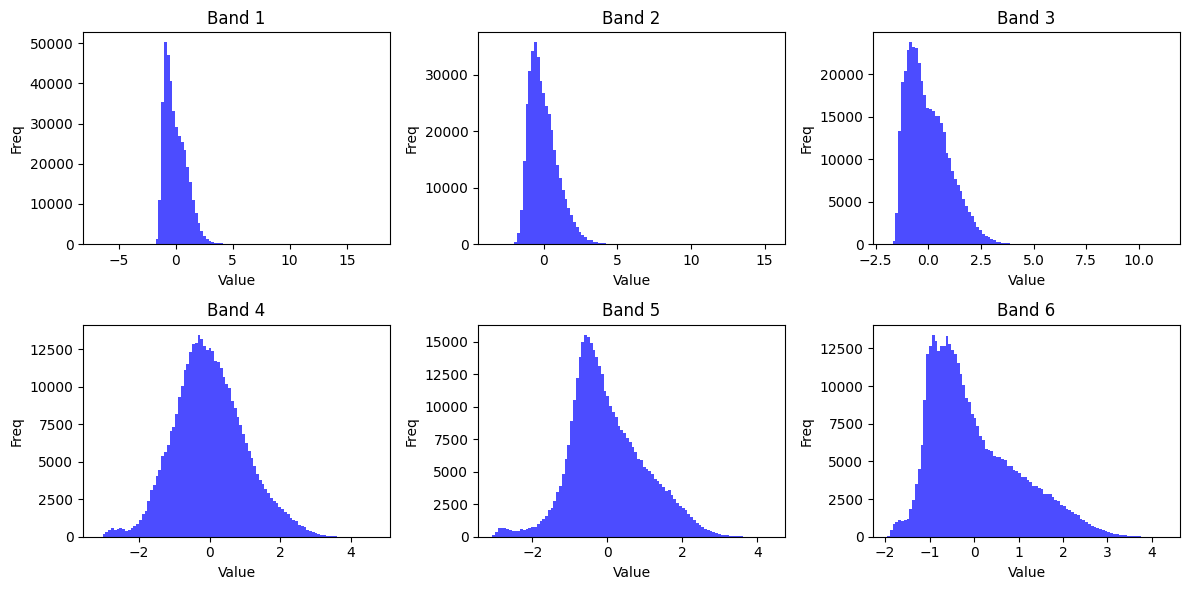

Class Weights: tensor([0.7370, 2.9148, 0.7692], device='cuda:0')



Epoch 1/50
Train — Loss: 1.0224 | Acc: 0.5261 | Avg F1: 0.5178
Val   — Loss: 0.4565 | Acc: 0.7581 | Avg F1: 0.7755



Epoch 2/50
Train — Loss: 0.8094 | Acc: 0.5701 | Avg F1: 0.5633
Val   — Loss: 0.4489 | Acc: 0.8088 | Avg F1: 0.8152



Epoch 3/50
Train — Loss: 0.7706 | Acc: 0.5887 | Avg F1: 0.5819
Val   — Loss: 0.4046 | Acc: 0.8624 | Avg F1: 0.8623



Epoch 4/50
Train — Loss: 0.7556 | Acc: 0.6000 | Avg F1: 0.5919
Val   — Loss: 0.3854 | Acc: 0.8578 | Avg F1: 0.8605



Epoch 5/50
Train — Loss: 0.7375 | Acc: 0.6053 | Avg F1: 0.5974
Val   — Loss: 0.3791 | Acc: 0.8470 | Avg F1: 0.8481



Epoch 6/50
Train — Loss: 0.7326 | Acc: 0.6085 | Avg F1: 0.6000
Val   — Loss: 0.3741 | Acc: 0.8688 | Avg F1: 0.8676



Epoch 7/50
Train — Loss: 0.7168 | Acc: 0.6183 | Avg F1: 0.6088
Val   — Loss: 0.3640 | Acc: 0.8664 | Avg F1: 0.8642



Epoch 8/50
Train — Loss: 0.7085 | Acc: 0.6202 | Avg F1: 0.6111
Val   — Loss: 0.3474 | Acc: 0.8742 | Avg F1: 0.8747



Epoch 9/50
Train — Loss: 0.7009 | Acc: 0.6273 | Avg F1: 0.6185
Val   — Loss: 0.3428 | Acc: 0.8721 | Avg F1: 0.8719



Epoch 10/50
Train — Loss: 0.6947 | Acc: 0.6321 | Avg F1: 0.6221
Val   — Loss: 0.3452 | Acc: 0.8757 | Avg F1: 0.8754



Epoch 11/50
Train — Loss: 0.6901 | Acc: 0.6279 | Avg F1: 0.6186
Val   — Loss: 0.3204 | Acc: 0.8866 | Avg F1: 0.8849



Epoch 12/50
Train — Loss: 0.6836 | Acc: 0.6360 | Avg F1: 0.6278
Val   — Loss: 0.3084 | Acc: 0.8853 | Avg F1: 0.8840



Epoch 13/50
Train — Loss: 0.6753 | Acc: 0.6409 | Avg F1: 0.6318
Val   — Loss: 0.3169 | Acc: 0.8813 | Avg F1: 0.8804



Epoch 14/50
Train — Loss: 0.6756 | Acc: 0.6374 | Avg F1: 0.6287
Val   — Loss: 0.3102 | Acc: 0.8937 | Avg F1: 0.8922



Epoch 15/50
Train — Loss: 0.6687 | Acc: 0.6481 | Avg F1: 0.6372
Val   — Loss: 0.3356 | Acc: 0.8925 | Avg F1: 0.8905



Epoch 16/50
Train — Loss: 0.6644 | Acc: 0.6448 | Avg F1: 0.6357
Val   — Loss: 0.3055 | Acc: 0.8904 | Avg F1: 0.8898



Epoch 17/50
Train — Loss: 0.6534 | Acc: 0.6476 | Avg F1: 0.6387
Val   — Loss: 0.2978 | Acc: 0.8940 | Avg F1: 0.8923



Epoch 18/50
Train — Loss: 0.6524 | Acc: 0.6530 | Avg F1: 0.6425
Val   — Loss: 0.3055 | Acc: 0.8934 | Avg F1: 0.8907



Epoch 19/50
Train — Loss: 0.6468 | Acc: 0.6597 | Avg F1: 0.6500
Val   — Loss: 0.3001 | Acc: 0.8945 | Avg F1: 0.8920



Epoch 20/50
Train — Loss: 0.6385 | Acc: 0.6589 | Avg F1: 0.6499
Val   — Loss: 0.2940 | Acc: 0.8903 | Avg F1: 0.8885



Epoch 21/50
Train — Loss: 0.6363 | Acc: 0.6615 | Avg F1: 0.6516
Val   — Loss: 0.2823 | Acc: 0.8961 | Avg F1: 0.8948



Epoch 22/50
Train — Loss: 0.6371 | Acc: 0.6655 | Avg F1: 0.6548
Val   — Loss: 0.2983 | Acc: 0.8943 | Avg F1: 0.8909



Epoch 23/50
Train — Loss: 0.6273 | Acc: 0.6654 | Avg F1: 0.6564
Val   — Loss: 0.2817 | Acc: 0.8893 | Avg F1: 0.8857



Epoch 24/50
Train — Loss: 0.6253 | Acc: 0.6688 | Avg F1: 0.6580
Val   — Loss: 0.2788 | Acc: 0.8910 | Avg F1: 0.8858



Epoch 25/50
Train — Loss: 0.6164 | Acc: 0.6726 | Avg F1: 0.6628
Val   — Loss: 0.2887 | Acc: 0.8925 | Avg F1: 0.8872



Epoch 26/50
Train — Loss: 0.6111 | Acc: 0.6754 | Avg F1: 0.6662
Val   — Loss: 0.2780 | Acc: 0.8954 | Avg F1: 0.8915



Epoch 27/50
Train — Loss: 0.6018 | Acc: 0.6790 | Avg F1: 0.6690
Val   — Loss: 0.2866 | Acc: 0.8948 | Avg F1: 0.8917



Epoch 28/50
Train — Loss: 0.6001 | Acc: 0.6823 | Avg F1: 0.6733
Val   — Loss: 0.2952 | Acc: 0.8951 | Avg F1: 0.8917



Epoch 29/50
Train — Loss: 0.5995 | Acc: 0.6797 | Avg F1: 0.6702
Val   — Loss: 0.2932 | Acc: 0.8967 | Avg F1: 0.8910



Epoch 30/50
Train — Loss: 0.5943 | Acc: 0.6828 | Avg F1: 0.6725
Val   — Loss: 0.2803 | Acc: 0.8953 | Avg F1: 0.8909



Epoch 31/50
Train — Loss: 0.5824 | Acc: 0.6908 | Avg F1: 0.6826
Val   — Loss: 0.2849 | Acc: 0.8958 | Avg F1: 0.8921



Epoch 32/50
Train — Loss: 0.5842 | Acc: 0.6877 | Avg F1: 0.6787
Val   — Loss: 0.2900 | Acc: 0.8905 | Avg F1: 0.8853



Epoch 33/50
Train — Loss: 0.5510 | Acc: 0.7049 | Avg F1: 0.6975
Val   — Loss: 0.2599 | Acc: 0.8988 | Avg F1: 0.8939



Epoch 34/50
Train — Loss: 0.5353 | Acc: 0.7180 | Avg F1: 0.7111
Val   — Loss: 0.2627 | Acc: 0.8953 | Avg F1: 0.8893



Epoch 35/50
Train — Loss: 0.5370 | Acc: 0.7173 | Avg F1: 0.7098
Val   — Loss: 0.2633 | Acc: 0.8978 | Avg F1: 0.8918



Epoch 36/50
Train — Loss: 0.5160 | Acc: 0.7238 | Avg F1: 0.7184
Val   — Loss: 0.2616 | Acc: 0.8966 | Avg F1: 0.8914



Epoch 37/50
Train — Loss: 0.5181 | Acc: 0.7259 | Avg F1: 0.7209
Val   — Loss: 0.2600 | Acc: 0.9003 | Avg F1: 0.8947



Epoch 38/50
Train — Loss: 0.5126 | Acc: 0.7224 | Avg F1: 0.7166
Val   — Loss: 0.2657 | Acc: 0.8987 | Avg F1: 0.8932



Epoch 39/50
Train — Loss: 0.5161 | Acc: 0.7224 | Avg F1: 0.7171
Val   — Loss: 0.2579 | Acc: 0.8988 | Avg F1: 0.8932



Epoch 40/50
Train — Loss: 0.5056 | Acc: 0.7308 | Avg F1: 0.7260
Val   — Loss: 0.2654 | Acc: 0.8985 | Avg F1: 0.8936



Epoch 41/50
Train — Loss: 0.5087 | Acc: 0.7285 | Avg F1: 0.7235
Val   — Loss: 0.2562 | Acc: 0.8977 | Avg F1: 0.8928



Epoch 42/50
Train — Loss: 0.4958 | Acc: 0.7363 | Avg F1: 0.7322
Val   — Loss: 0.2633 | Acc: 0.8978 | Avg F1: 0.8930



Epoch 43/50
Train — Loss: 0.4888 | Acc: 0.7377 | Avg F1: 0.7345
Val   — Loss: 0.2633 | Acc: 0.8989 | Avg F1: 0.8932



Epoch 44/50
Train — Loss: 0.4886 | Acc: 0.7424 | Avg F1: 0.7379
Val   — Loss: 0.2802 | Acc: 0.8967 | Avg F1: 0.8911



Epoch 45/50
Train — Loss: 0.4834 | Acc: 0.7381 | Avg F1: 0.7367
Val   — Loss: 0.2615 | Acc: 0.9005 | Avg F1: 0.8968



Epoch 46/50
Train — Loss: 0.4820 | Acc: 0.7441 | Avg F1: 0.7399
Val   — Loss: 0.2629 | Acc: 0.8999 | Avg F1: 0.8958



Epoch 47/50
Train — Loss: 0.4733 | Acc: 0.7475 | Avg F1: 0.7428
Val   — Loss: 0.2643 | Acc: 0.8970 | Avg F1: 0.8920



Epoch 48/50
Train — Loss: 0.4480 | Acc: 0.7576 | Avg F1: 0.7580
Val   — Loss: 0.2753 | Acc: 0.8981 | Avg F1: 0.8940



Epoch 49/50
Train — Loss: 0.4454 | Acc: 0.7624 | Avg F1: 0.7614
Val   — Loss: 0.2728 | Acc: 0.8996 | Avg F1: 0.8948



Epoch 50/50
Train — Loss: 0.4420 | Acc: 0.7631 | Avg F1: 0.7639
Val   — Loss: 0.2803 | Acc: 0.8985 | Avg F1: 0.8947


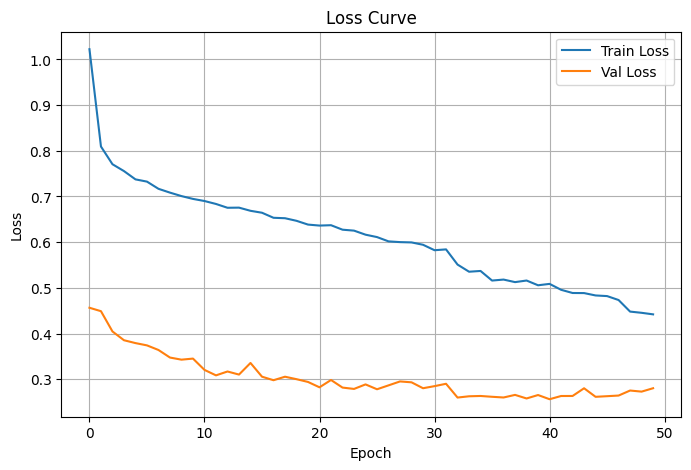

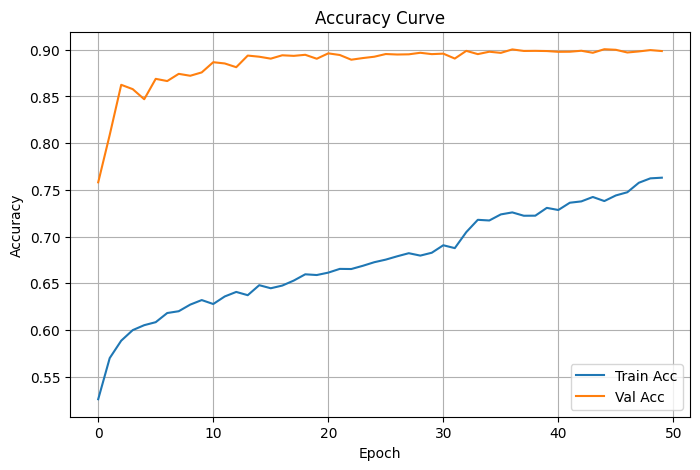

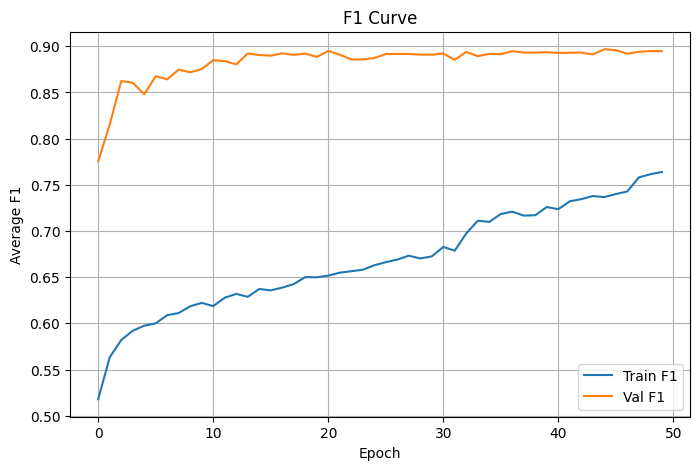


=== Final Evaluation Results ===
Accuracy     : 0.8984
Macro F1     : 0.8961
Micro F1     : 0.8984
Weighted F1  : 0.8985
Cohen's Kappa: 0.8338

Per-class F1 scores:
  Class 0: 0.9010
  Class 1: 0.8882
  Class 2: 0.8992

Confusion Matrix:
[[775556  25433  70045]
 [  8934 243585   8256]
 [ 66006  18725 727176]]
Saved results to results/approx_BCNN_data_bvsb_results.json

=== Run 3/13 — approx_BCNN_data_predictive_entropy ===
X:  (14000, 28, 6)
y:  (14000,)
Before Normalisation

Global Mean: -0.1120
Global Std Dev: 0.8077

Per-Band Statistics:
  Band      Mean      Std
Band 1 -0.130165 0.855949
Band 2 -0.088315 0.817264
Band 3 -0.112776 0.808232
Band 4 -0.099616 0.779159
Band 5 -0.110937 0.794766
Band 6 -0.129931 0.787487

Class Distribution:
 Class  Count  Percentage
     0   5766   41.185714
     1   2705   19.321429
     2   5529   39.492857


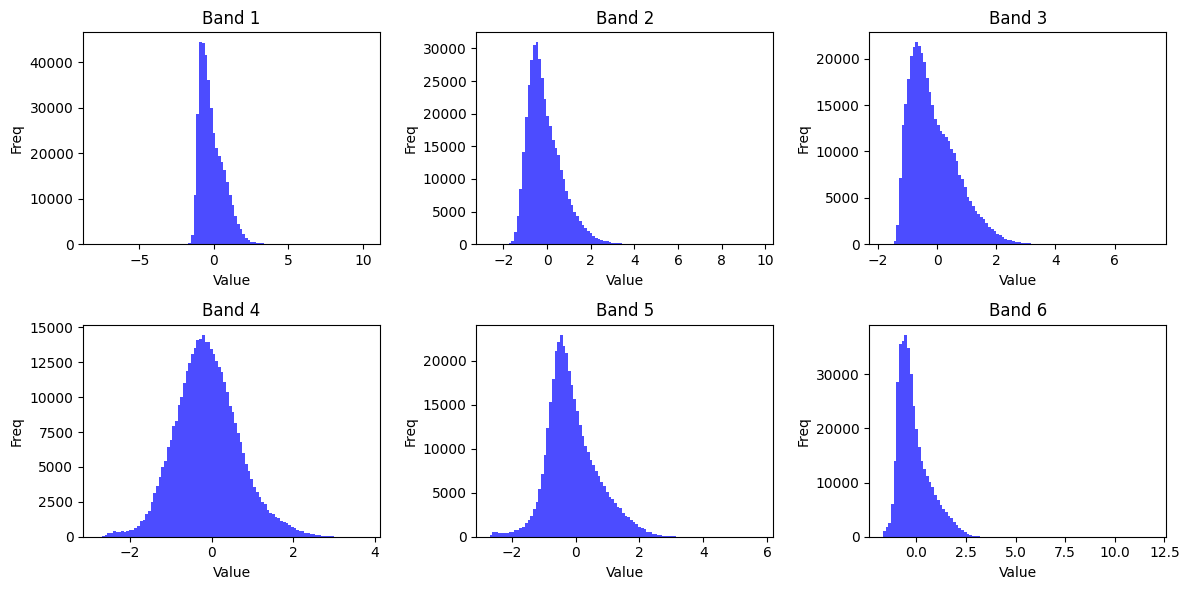

After Normalisation

Global Mean: -0.0000
Global Std Dev: 1.0001

Per-Band Statistics:
  Band          Mean      Std
Band 1 -2.317752e-06 0.999979
Band 2  9.308368e-07 0.999982
Band 3 -1.069591e-06 1.000000
Band 4 -4.506561e-07 1.000003
Band 5 -3.644095e-06 0.999985
Band 6  5.272102e-07 1.000020

Class Distribution:
 Class  Count  Percentage
     0   5766   41.185714
     1   2705   19.321429
     2   5529   39.492857


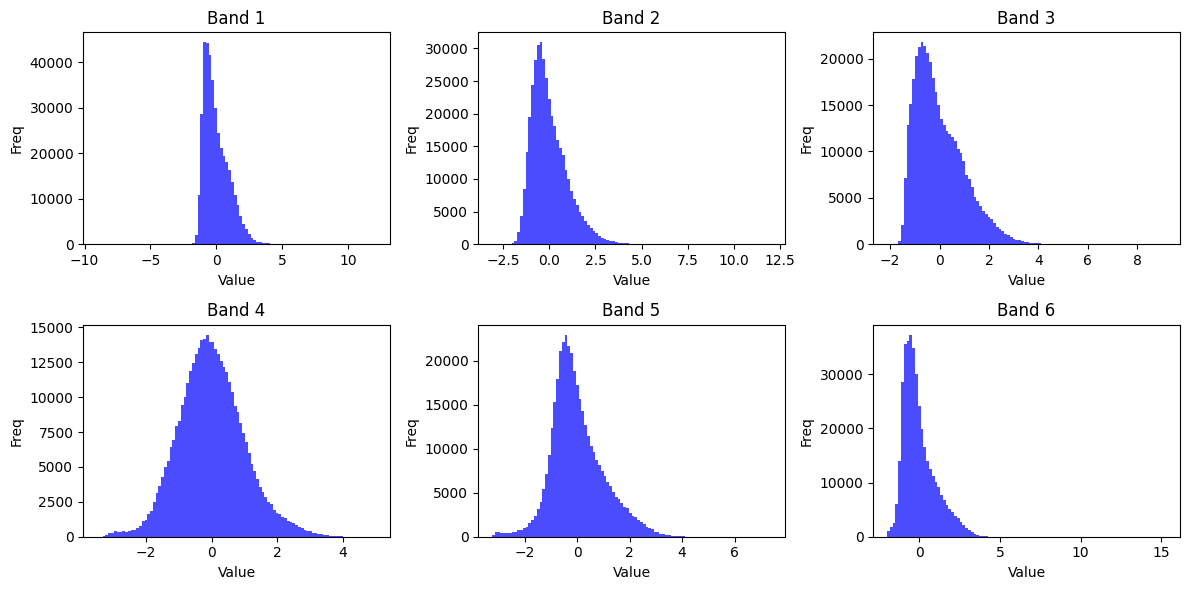

Class Weights: tensor([0.8093, 1.7252, 0.8440], device='cuda:0')



Epoch 1/50
Train — Loss: 1.1203 | Acc: 0.4991 | Avg F1: 0.4950
Val   — Loss: 0.5144 | Acc: 0.8023 | Avg F1: 0.8031



Epoch 2/50
Train — Loss: 0.9196 | Acc: 0.5367 | Avg F1: 0.5321
Val   — Loss: 0.4684 | Acc: 0.7976 | Avg F1: 0.7998



Epoch 3/50
Train — Loss: 0.8789 | Acc: 0.5617 | Avg F1: 0.5560
Val   — Loss: 0.4515 | Acc: 0.7860 | Avg F1: 0.7987



Epoch 4/50
Train — Loss: 0.8667 | Acc: 0.5697 | Avg F1: 0.5642
Val   — Loss: 0.4093 | Acc: 0.8247 | Avg F1: 0.8325



Epoch 5/50
Train — Loss: 0.8474 | Acc: 0.5788 | Avg F1: 0.5731
Val   — Loss: 0.4126 | Acc: 0.8212 | Avg F1: 0.8299



Epoch 6/50
Train — Loss: 0.8336 | Acc: 0.5823 | Avg F1: 0.5768
Val   — Loss: 0.4119 | Acc: 0.8144 | Avg F1: 0.8200



Epoch 7/50
Train — Loss: 0.8292 | Acc: 0.5869 | Avg F1: 0.5812
Val   — Loss: 0.3722 | Acc: 0.8524 | Avg F1: 0.8543



Epoch 8/50
Train — Loss: 0.8177 | Acc: 0.5906 | Avg F1: 0.5850
Val   — Loss: 0.3482 | Acc: 0.8540 | Avg F1: 0.8557



Epoch 9/50
Train — Loss: 0.8115 | Acc: 0.5956 | Avg F1: 0.5905
Val   — Loss: 0.3662 | Acc: 0.8434 | Avg F1: 0.8488



Epoch 10/50
Train — Loss: 0.8045 | Acc: 0.5991 | Avg F1: 0.5941
Val   — Loss: 0.3590 | Acc: 0.8507 | Avg F1: 0.8532



Epoch 11/50
Train — Loss: 0.8024 | Acc: 0.5994 | Avg F1: 0.5936
Val   — Loss: 0.3583 | Acc: 0.8427 | Avg F1: 0.8472



Epoch 12/50
Train — Loss: 0.7964 | Acc: 0.6021 | Avg F1: 0.5965
Val   — Loss: 0.3290 | Acc: 0.8689 | Avg F1: 0.8687



Epoch 13/50
Train — Loss: 0.7876 | Acc: 0.6097 | Avg F1: 0.6044
Val   — Loss: 0.3412 | Acc: 0.8629 | Avg F1: 0.8624



Epoch 14/50
Train — Loss: 0.7838 | Acc: 0.6118 | Avg F1: 0.6063
Val   — Loss: 0.3417 | Acc: 0.8605 | Avg F1: 0.8636



Epoch 15/50
Train — Loss: 0.7753 | Acc: 0.6194 | Avg F1: 0.6137
Val   — Loss: 0.3311 | Acc: 0.8625 | Avg F1: 0.8654



Epoch 16/50
Train — Loss: 0.7688 | Acc: 0.6231 | Avg F1: 0.6177
Val   — Loss: 0.3362 | Acc: 0.8644 | Avg F1: 0.8682



Epoch 17/50
Train — Loss: 0.7700 | Acc: 0.6222 | Avg F1: 0.6164
Val   — Loss: 0.3246 | Acc: 0.8634 | Avg F1: 0.8679



Epoch 18/50
Train — Loss: 0.7642 | Acc: 0.6240 | Avg F1: 0.6189
Val   — Loss: 0.3245 | Acc: 0.8668 | Avg F1: 0.8694



Epoch 19/50
Train — Loss: 0.7602 | Acc: 0.6263 | Avg F1: 0.6209
Val   — Loss: 0.3105 | Acc: 0.8692 | Avg F1: 0.8702



Epoch 20/50
Train — Loss: 0.7550 | Acc: 0.6287 | Avg F1: 0.6232
Val   — Loss: 0.3174 | Acc: 0.8719 | Avg F1: 0.8734



Epoch 21/50
Train — Loss: 0.7507 | Acc: 0.6323 | Avg F1: 0.6262
Val   — Loss: 0.3250 | Acc: 0.8657 | Avg F1: 0.8680



Epoch 22/50
Train — Loss: 0.7481 | Acc: 0.6334 | Avg F1: 0.6275
Val   — Loss: 0.3495 | Acc: 0.8631 | Avg F1: 0.8661



Epoch 23/50
Train — Loss: 0.7438 | Acc: 0.6352 | Avg F1: 0.6297
Val   — Loss: 0.3073 | Acc: 0.8733 | Avg F1: 0.8751



Epoch 24/50
Train — Loss: 0.7367 | Acc: 0.6372 | Avg F1: 0.6316
Val   — Loss: 0.3167 | Acc: 0.8720 | Avg F1: 0.8728



Epoch 25/50
Train — Loss: 0.7338 | Acc: 0.6459 | Avg F1: 0.6401
Val   — Loss: 0.3387 | Acc: 0.8561 | Avg F1: 0.8598



Epoch 26/50
Train — Loss: 0.7324 | Acc: 0.6391 | Avg F1: 0.6332
Val   — Loss: 0.3202 | Acc: 0.8662 | Avg F1: 0.8691



Epoch 27/50
Train — Loss: 0.7249 | Acc: 0.6489 | Avg F1: 0.6431
Val   — Loss: 0.3091 | Acc: 0.8721 | Avg F1: 0.8746



Epoch 28/50
Train — Loss: 0.7230 | Acc: 0.6451 | Avg F1: 0.6399
Val   — Loss: 0.3113 | Acc: 0.8667 | Avg F1: 0.8688



Epoch 29/50
Train — Loss: 0.7139 | Acc: 0.6532 | Avg F1: 0.6477
Val   — Loss: 0.3089 | Acc: 0.8723 | Avg F1: 0.8763



Epoch 30/50
Train — Loss: 0.6913 | Acc: 0.6704 | Avg F1: 0.6650
Val   — Loss: 0.2998 | Acc: 0.8762 | Avg F1: 0.8788



Epoch 31/50
Train — Loss: 0.6823 | Acc: 0.6745 | Avg F1: 0.6683
Val   — Loss: 0.3044 | Acc: 0.8703 | Avg F1: 0.8741



Epoch 32/50
Train — Loss: 0.6788 | Acc: 0.6717 | Avg F1: 0.6666
Val   — Loss: 0.3116 | Acc: 0.8623 | Avg F1: 0.8664



Epoch 33/50
Train — Loss: 0.6695 | Acc: 0.6786 | Avg F1: 0.6729
Val   — Loss: 0.3217 | Acc: 0.8652 | Avg F1: 0.8698



Epoch 34/50
Train — Loss: 0.6651 | Acc: 0.6822 | Avg F1: 0.6771
Val   — Loss: 0.3020 | Acc: 0.8686 | Avg F1: 0.8728



Epoch 35/50
Train — Loss: 0.6601 | Acc: 0.6859 | Avg F1: 0.6802
Val   — Loss: 0.2900 | Acc: 0.8736 | Avg F1: 0.8768



Epoch 36/50
Train — Loss: 0.6572 | Acc: 0.6883 | Avg F1: 0.6830
Val   — Loss: 0.3033 | Acc: 0.8688 | Avg F1: 0.8729



Epoch 37/50
Train — Loss: 0.6510 | Acc: 0.6906 | Avg F1: 0.6848
Val   — Loss: 0.3032 | Acc: 0.8712 | Avg F1: 0.8750



Epoch 38/50
Train — Loss: 0.6436 | Acc: 0.6936 | Avg F1: 0.6883
Val   — Loss: 0.2916 | Acc: 0.8724 | Avg F1: 0.8756



Epoch 39/50
Train — Loss: 0.6350 | Acc: 0.6978 | Avg F1: 0.6929
Val   — Loss: 0.2911 | Acc: 0.8780 | Avg F1: 0.8825



Epoch 40/50
Train — Loss: 0.6350 | Acc: 0.6997 | Avg F1: 0.6956
Val   — Loss: 0.3092 | Acc: 0.8678 | Avg F1: 0.8726



Epoch 41/50
Train — Loss: 0.6300 | Acc: 0.7038 | Avg F1: 0.6991
Val   — Loss: 0.3029 | Acc: 0.8674 | Avg F1: 0.8721



Epoch 42/50
Train — Loss: 0.6044 | Acc: 0.7179 | Avg F1: 0.7131
Val   — Loss: 0.2847 | Acc: 0.8803 | Avg F1: 0.8842



Epoch 43/50
Train — Loss: 0.5966 | Acc: 0.7196 | Avg F1: 0.7158
Val   — Loss: 0.3005 | Acc: 0.8783 | Avg F1: 0.8838



Epoch 44/50
Train — Loss: 0.5980 | Acc: 0.7185 | Avg F1: 0.7131
Val   — Loss: 0.2892 | Acc: 0.8840 | Avg F1: 0.8876



Epoch 45/50
Train — Loss: 0.5920 | Acc: 0.7214 | Avg F1: 0.7165
Val   — Loss: 0.2955 | Acc: 0.8820 | Avg F1: 0.8864



Epoch 46/50
Train — Loss: 0.5862 | Acc: 0.7238 | Avg F1: 0.7194
Val   — Loss: 0.3045 | Acc: 0.8779 | Avg F1: 0.8824



Epoch 47/50
Train — Loss: 0.5857 | Acc: 0.7241 | Avg F1: 0.7197
Val   — Loss: 0.2942 | Acc: 0.8784 | Avg F1: 0.8816



Epoch 48/50
Train — Loss: 0.5760 | Acc: 0.7306 | Avg F1: 0.7269
Val   — Loss: 0.2984 | Acc: 0.8811 | Avg F1: 0.8851



Epoch 49/50
Train — Loss: 0.5642 | Acc: 0.7351 | Avg F1: 0.7315
Val   — Loss: 0.2960 | Acc: 0.8836 | Avg F1: 0.8881



Epoch 50/50
Train — Loss: 0.5597 | Acc: 0.7394 | Avg F1: 0.7354
Val   — Loss: 0.3035 | Acc: 0.8817 | Avg F1: 0.8861


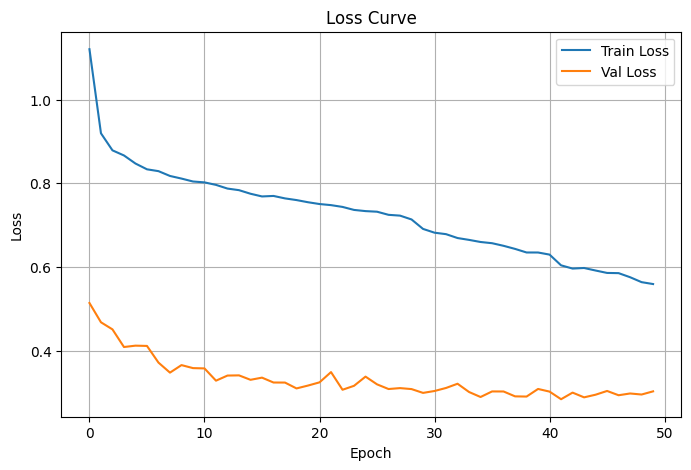

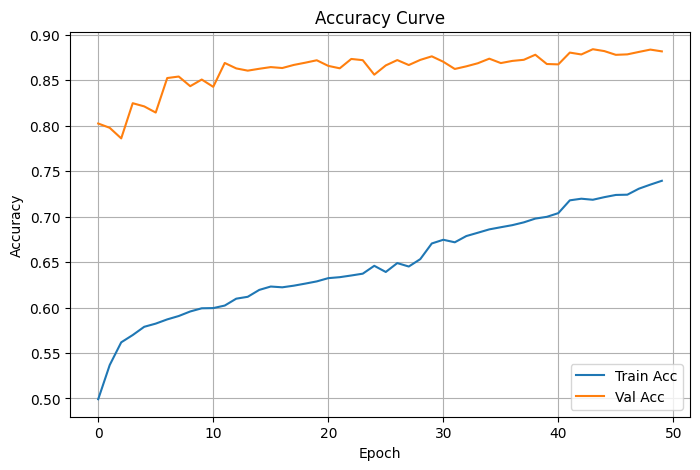

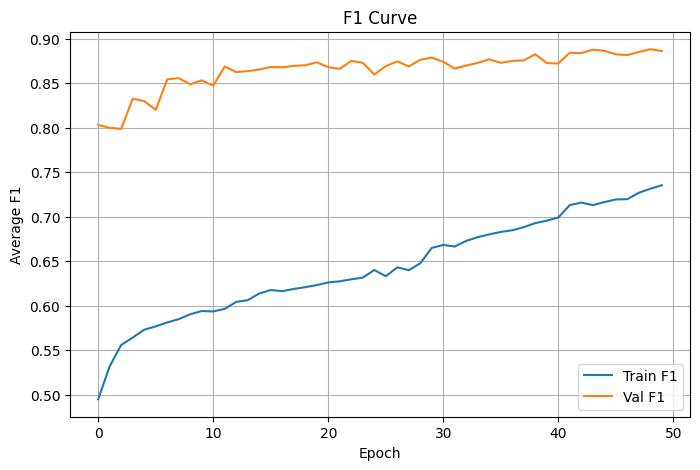


=== Final Evaluation Results ===
Accuracy     : 0.8812
Macro F1     : 0.8870
Micro F1     : 0.8812
Weighted F1  : 0.8811
Cohen's Kappa: 0.8047

Per-class F1 scores:
  Class 0: 0.8802
  Class 1: 0.9071
  Class 2: 0.8738

Confusion Matrix:
[[766929  17447  86658]
 [  9953 241349   9473]
 [ 94805  12563 704539]]
Saved results to results/approx_BCNN_data_predictive_entropy_results.json

=== Run 4/13 — approx_BCNN_data_variation_ratio ===
X:  (14000, 28, 6)
y:  (14000,)
Before Normalisation

Global Mean: -0.0326
Global Std Dev: 0.8701

Per-Band Statistics:
  Band      Mean      Std
Band 1 -0.039385 0.897749
Band 2 -0.007327 0.879467
Band 3 -0.020291 0.874198
Band 4 -0.085398 0.828497
Band 5 -0.015106 0.870137
Band 6 -0.028272 0.866664

Class Distribution:
 Class  Count  Percentage
     0   6050   43.214286
     1   1913   13.664286
     2   6037   43.121429


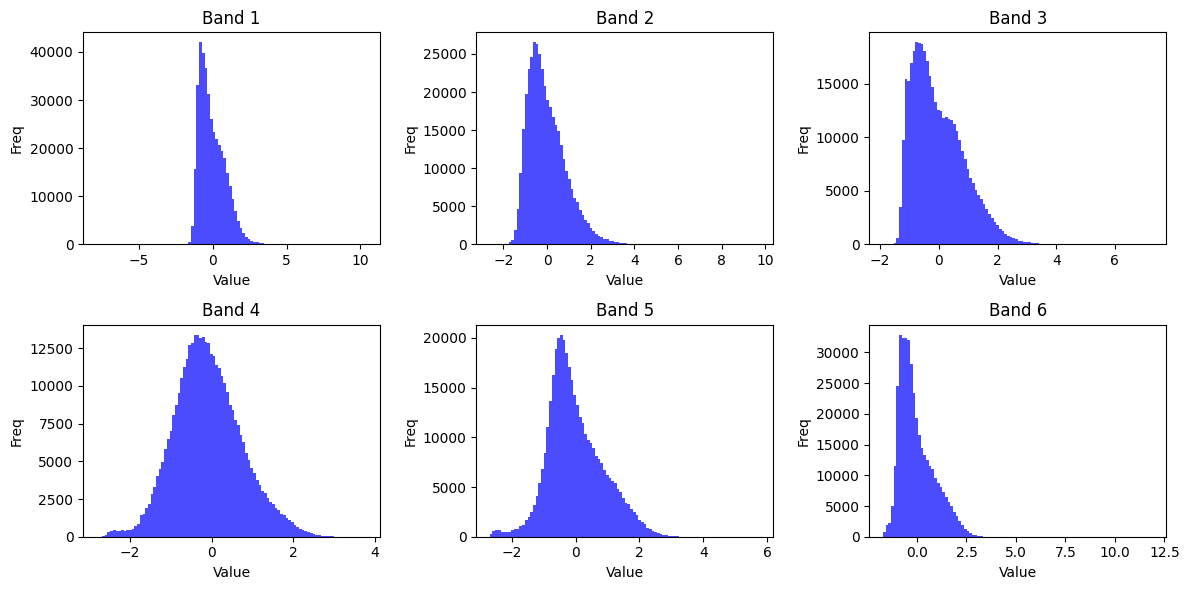

After Normalisation

Global Mean: -0.0000
Global Std Dev: 1.0001

Per-Band Statistics:
  Band          Mean      Std
Band 1 -4.990782e-07 1.000000
Band 2  2.011785e-07 1.000008
Band 3  1.837891e-08 0.999998
Band 4 -1.918572e-07 1.000006
Band 5 -9.026454e-09 0.999993
Band 6 -2.406434e-07 0.999995

Class Distribution:
 Class  Count  Percentage
     0   6050   43.214286
     1   1913   13.664286
     2   6037   43.121429


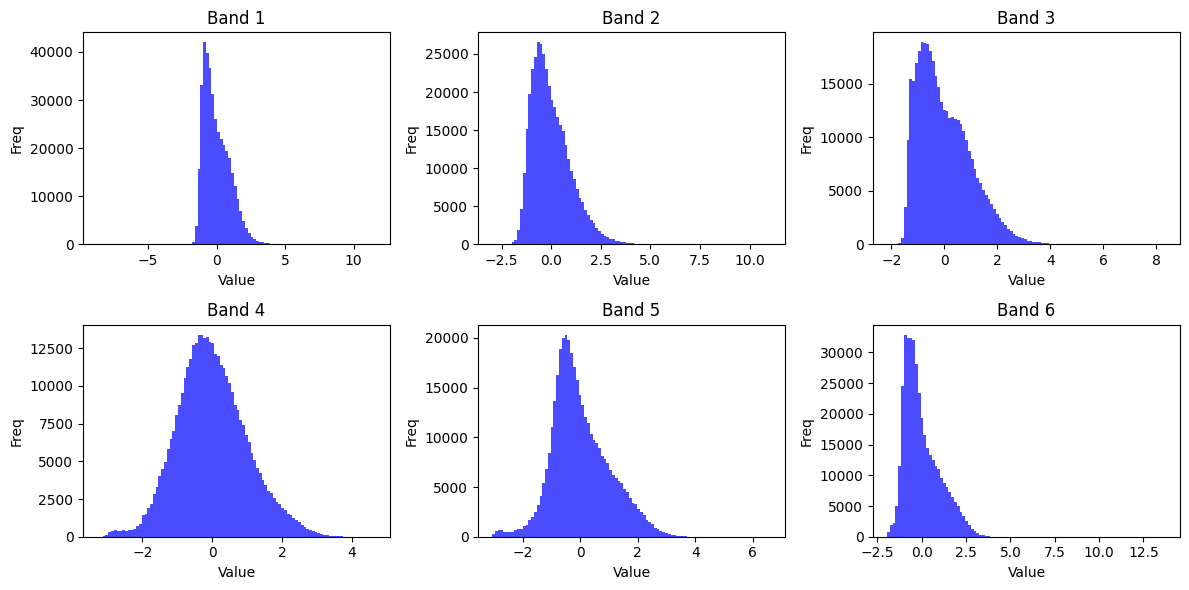

Class Weights: tensor([0.7713, 2.4394, 0.7730], device='cuda:0')



Epoch 1/50
Train — Loss: 1.0798 | Acc: 0.5128 | Avg F1: 0.5050
Val   — Loss: 0.4458 | Acc: 0.8487 | Avg F1: 0.8495



Epoch 2/50
Train — Loss: 0.8466 | Acc: 0.5643 | Avg F1: 0.5557
Val   — Loss: 0.4457 | Acc: 0.8466 | Avg F1: 0.8477



Epoch 3/50
Train — Loss: 0.8004 | Acc: 0.5839 | Avg F1: 0.5767
Val   — Loss: 0.3972 | Acc: 0.8508 | Avg F1: 0.8525



Epoch 4/50
Train — Loss: 0.7853 | Acc: 0.5898 | Avg F1: 0.5806
Val   — Loss: 0.4005 | Acc: 0.8534 | Avg F1: 0.8529



Epoch 5/50
Train — Loss: 0.7683 | Acc: 0.6041 | Avg F1: 0.5954
Val   — Loss: 0.4012 | Acc: 0.8325 | Avg F1: 0.8314



Epoch 6/50
Train — Loss: 0.7559 | Acc: 0.6068 | Avg F1: 0.5977
Val   — Loss: 0.3900 | Acc: 0.8508 | Avg F1: 0.8467



Epoch 7/50
Train — Loss: 0.7442 | Acc: 0.6136 | Avg F1: 0.6040
Val   — Loss: 0.3768 | Acc: 0.8519 | Avg F1: 0.8447



Epoch 8/50
Train — Loss: 0.7345 | Acc: 0.6141 | Avg F1: 0.6053
Val   — Loss: 0.3576 | Acc: 0.8590 | Avg F1: 0.8565



Epoch 9/50
Train — Loss: 0.7275 | Acc: 0.6246 | Avg F1: 0.6142
Val   — Loss: 0.3455 | Acc: 0.8618 | Avg F1: 0.8590



Epoch 10/50
Train — Loss: 0.7199 | Acc: 0.6256 | Avg F1: 0.6170
Val   — Loss: 0.3701 | Acc: 0.8489 | Avg F1: 0.8486



Epoch 11/50
Train — Loss: 0.7194 | Acc: 0.6316 | Avg F1: 0.6219
Val   — Loss: 0.3257 | Acc: 0.8769 | Avg F1: 0.8747



Epoch 12/50
Train — Loss: 0.7083 | Acc: 0.6341 | Avg F1: 0.6240
Val   — Loss: 0.3330 | Acc: 0.8679 | Avg F1: 0.8676



Epoch 13/50
Train — Loss: 0.7060 | Acc: 0.6324 | Avg F1: 0.6223
Val   — Loss: 0.3331 | Acc: 0.8753 | Avg F1: 0.8738



Epoch 14/50
Train — Loss: 0.7012 | Acc: 0.6406 | Avg F1: 0.6300
Val   — Loss: 0.3346 | Acc: 0.8633 | Avg F1: 0.8606



Epoch 15/50
Train — Loss: 0.6962 | Acc: 0.6442 | Avg F1: 0.6338
Val   — Loss: 0.3292 | Acc: 0.8695 | Avg F1: 0.8689



Epoch 16/50
Train — Loss: 0.6890 | Acc: 0.6464 | Avg F1: 0.6367
Val   — Loss: 0.3285 | Acc: 0.8680 | Avg F1: 0.8650



Epoch 17/50
Train — Loss: 0.6812 | Acc: 0.6490 | Avg F1: 0.6398
Val   — Loss: 0.3150 | Acc: 0.8754 | Avg F1: 0.8747



Epoch 18/50
Train — Loss: 0.6815 | Acc: 0.6508 | Avg F1: 0.6393
Val   — Loss: 0.3157 | Acc: 0.8750 | Avg F1: 0.8739



Epoch 19/50
Train — Loss: 0.6727 | Acc: 0.6492 | Avg F1: 0.6405
Val   — Loss: 0.3292 | Acc: 0.8712 | Avg F1: 0.8720



Epoch 20/50
Train — Loss: 0.6708 | Acc: 0.6526 | Avg F1: 0.6432
Val   — Loss: 0.3136 | Acc: 0.8761 | Avg F1: 0.8745



Epoch 21/50
Train — Loss: 0.6654 | Acc: 0.6573 | Avg F1: 0.6479
Val   — Loss: 0.3119 | Acc: 0.8754 | Avg F1: 0.8721



Epoch 22/50
Train — Loss: 0.6655 | Acc: 0.6559 | Avg F1: 0.6463
Val   — Loss: 0.2970 | Acc: 0.8824 | Avg F1: 0.8810



Epoch 23/50
Train — Loss: 0.6553 | Acc: 0.6626 | Avg F1: 0.6529
Val   — Loss: 0.3094 | Acc: 0.8813 | Avg F1: 0.8812



Epoch 24/50
Train — Loss: 0.6573 | Acc: 0.6591 | Avg F1: 0.6498
Val   — Loss: 0.3213 | Acc: 0.8754 | Avg F1: 0.8784



Epoch 25/50
Train — Loss: 0.6454 | Acc: 0.6698 | Avg F1: 0.6604
Val   — Loss: 0.3021 | Acc: 0.8832 | Avg F1: 0.8826



Epoch 26/50
Train — Loss: 0.6438 | Acc: 0.6696 | Avg F1: 0.6593
Val   — Loss: 0.3038 | Acc: 0.8759 | Avg F1: 0.8768



Epoch 27/50
Train — Loss: 0.6367 | Acc: 0.6703 | Avg F1: 0.6618
Val   — Loss: 0.3111 | Acc: 0.8746 | Avg F1: 0.8767



Epoch 28/50
Train — Loss: 0.6377 | Acc: 0.6719 | Avg F1: 0.6626
Val   — Loss: 0.2860 | Acc: 0.8873 | Avg F1: 0.8859



Epoch 29/50
Train — Loss: 0.6281 | Acc: 0.6762 | Avg F1: 0.6687
Val   — Loss: 0.2895 | Acc: 0.8845 | Avg F1: 0.8822



Epoch 30/50
Train — Loss: 0.6267 | Acc: 0.6780 | Avg F1: 0.6697
Val   — Loss: 0.2862 | Acc: 0.8883 | Avg F1: 0.8879



Epoch 31/50
Train — Loss: 0.6283 | Acc: 0.6753 | Avg F1: 0.6654
Val   — Loss: 0.2801 | Acc: 0.8866 | Avg F1: 0.8838



Epoch 32/50
Train — Loss: 0.6073 | Acc: 0.6869 | Avg F1: 0.6789
Val   — Loss: 0.2951 | Acc: 0.8841 | Avg F1: 0.8839



Epoch 33/50
Train — Loss: 0.6098 | Acc: 0.6831 | Avg F1: 0.6741
Val   — Loss: 0.2591 | Acc: 0.8945 | Avg F1: 0.8909



Epoch 34/50
Train — Loss: 0.6071 | Acc: 0.6904 | Avg F1: 0.6821
Val   — Loss: 0.2840 | Acc: 0.8919 | Avg F1: 0.8901



Epoch 35/50
Train — Loss: 0.6001 | Acc: 0.6916 | Avg F1: 0.6835
Val   — Loss: 0.3002 | Acc: 0.8865 | Avg F1: 0.8866



Epoch 36/50
Train — Loss: 0.5978 | Acc: 0.6885 | Avg F1: 0.6819
Val   — Loss: 0.2547 | Acc: 0.8951 | Avg F1: 0.8922



Epoch 37/50
Train — Loss: 0.5866 | Acc: 0.7004 | Avg F1: 0.6928
Val   — Loss: 0.2658 | Acc: 0.8978 | Avg F1: 0.8984



Epoch 38/50
Train — Loss: 0.5827 | Acc: 0.6996 | Avg F1: 0.6934
Val   — Loss: 0.2859 | Acc: 0.8889 | Avg F1: 0.8900



Epoch 39/50
Train — Loss: 0.5780 | Acc: 0.7024 | Avg F1: 0.6946
Val   — Loss: 0.2688 | Acc: 0.8872 | Avg F1: 0.8852



Epoch 40/50
Train — Loss: 0.5675 | Acc: 0.7096 | Avg F1: 0.7044
Val   — Loss: 0.2829 | Acc: 0.8858 | Avg F1: 0.8849



Epoch 41/50
Train — Loss: 0.5710 | Acc: 0.7054 | Avg F1: 0.7004
Val   — Loss: 0.2700 | Acc: 0.8896 | Avg F1: 0.8886



Epoch 42/50
Train — Loss: 0.5672 | Acc: 0.7078 | Avg F1: 0.7013
Val   — Loss: 0.2999 | Acc: 0.8795 | Avg F1: 0.8812



Epoch 43/50
Train — Loss: 0.5386 | Acc: 0.7212 | Avg F1: 0.7155
Val   — Loss: 0.2631 | Acc: 0.8996 | Avg F1: 0.9000



Epoch 44/50
Train — Loss: 0.5220 | Acc: 0.7299 | Avg F1: 0.7256
Val   — Loss: 0.2636 | Acc: 0.8962 | Avg F1: 0.8963



Epoch 45/50
Train — Loss: 0.5114 | Acc: 0.7353 | Avg F1: 0.7319
Val   — Loss: 0.2603 | Acc: 0.9026 | Avg F1: 0.9030



Epoch 46/50
Train — Loss: 0.5050 | Acc: 0.7436 | Avg F1: 0.7406
Val   — Loss: 0.2703 | Acc: 0.8964 | Avg F1: 0.8961



Epoch 47/50
Train — Loss: 0.5046 | Acc: 0.7449 | Avg F1: 0.7401
Val   — Loss: 0.2728 | Acc: 0.9003 | Avg F1: 0.9004



Epoch 48/50
Train — Loss: 0.4979 | Acc: 0.7438 | Avg F1: 0.7388
Val   — Loss: 0.2753 | Acc: 0.8983 | Avg F1: 0.8990



Epoch 49/50
Train — Loss: 0.4784 | Acc: 0.7567 | Avg F1: 0.7546
Val   — Loss: 0.2700 | Acc: 0.9014 | Avg F1: 0.9023



Epoch 50/50
Train — Loss: 0.4675 | Acc: 0.7605 | Avg F1: 0.7591
Val   — Loss: 0.2723 | Acc: 0.9006 | Avg F1: 0.9015


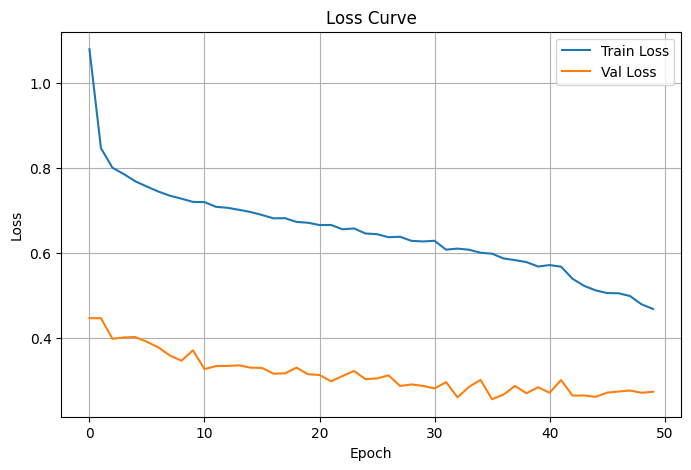

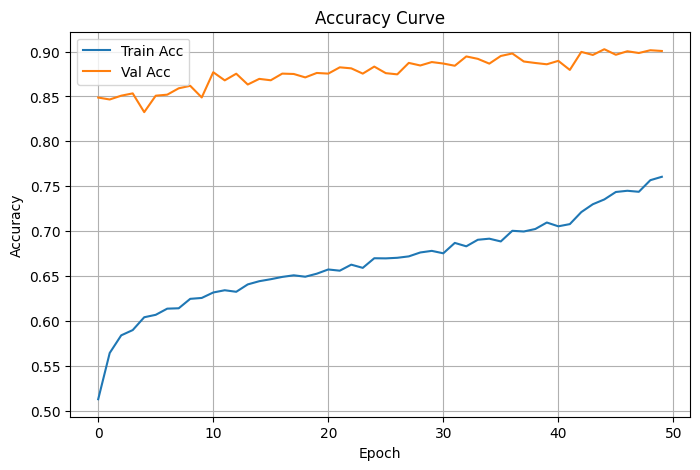

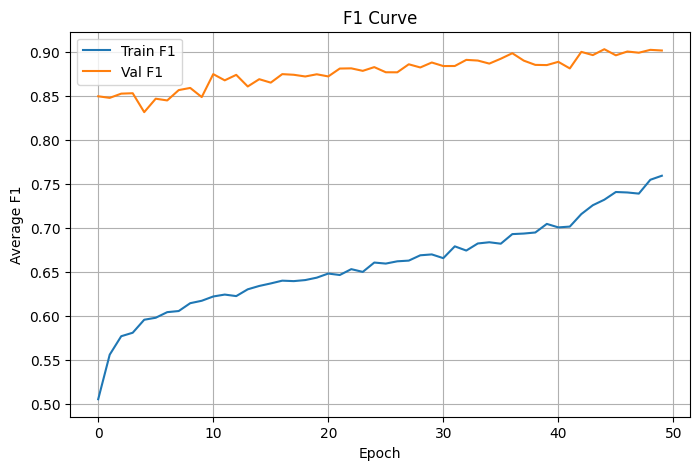


=== Final Evaluation Results ===
Accuracy     : 0.8968
Macro F1     : 0.8978
Micro F1     : 0.8968
Weighted F1  : 0.8968
Cohen's Kappa: 0.8308

Per-class F1 scores:
  Class 0: 0.8976
  Class 1: 0.9011
  Class 2: 0.8946

Confusion Matrix:
[[776325  20461  74248]
 [  9645 243791   7339]
 [ 72798  16041 723068]]
Saved results to results/approx_BCNN_data_variation_ratio_results.json

=== Run 5/13 — data_random ===
X:  (14000, 28, 6)
y:  (14000,)
Before Normalisation

Global Mean: 13131.3945
Global Std Dev: 4501.0239

Per-Band Statistics:
  Band         Mean         Std
Band 1  9294.926758 1069.593384
Band 2 10401.320312 1336.773071
Band 3 10580.083008 2007.449219
Band 4 18977.138672 4260.559570
Band 5 16323.393555 3341.727783
Band 6 13212.275391 3497.331055

Class Distribution:
 Class  Count  Percentage
     0   6266   44.757143
     1   2002   14.300000
     2   5732   40.942857


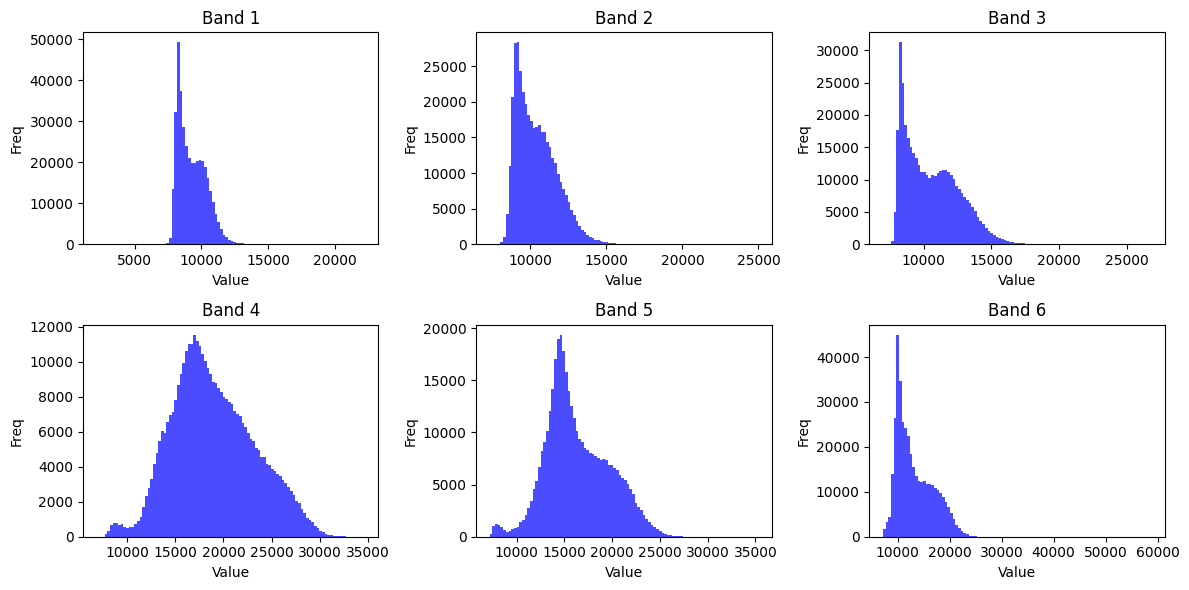

After Normalisation

Global Mean: -0.0000
Global Std Dev: 1.0000

Per-Band Statistics:
  Band      Mean      Std
Band 1 -0.000056 0.999978
Band 2  0.000092 0.999989
Band 3  0.000100 0.999980
Band 4 -0.000068 1.000007
Band 5 -0.000233 0.999984
Band 6  0.000010 0.999998

Class Distribution:
 Class  Count  Percentage
     0   6266   44.757143
     1   2002   14.300000
     2   5732   40.942857


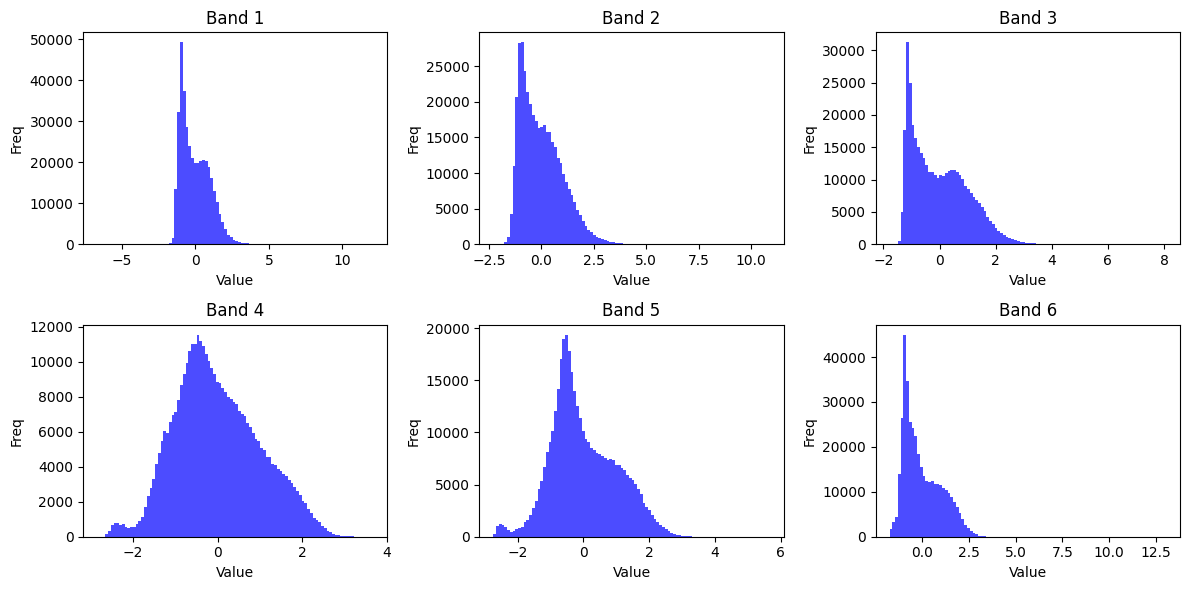

Class Weights: tensor([0.7448, 2.3310, 0.8141], device='cuda:0')



Epoch 1/50
Train — Loss: 0.5339 | Acc: 0.8044 | Avg F1: 0.8087
Val   — Loss: 0.3687 | Acc: 0.8573 | Avg F1: 0.8606



Epoch 2/50
Train — Loss: 0.3573 | Acc: 0.8502 | Avg F1: 0.8546
Val   — Loss: 0.3315 | Acc: 0.8710 | Avg F1: 0.8667



Epoch 3/50
Train — Loss: 0.3295 | Acc: 0.8623 | Avg F1: 0.8655
Val   — Loss: 0.3319 | Acc: 0.8716 | Avg F1: 0.8665



Epoch 4/50
Train — Loss: 0.3141 | Acc: 0.8679 | Avg F1: 0.8706
Val   — Loss: 0.3158 | Acc: 0.8809 | Avg F1: 0.8767



Epoch 5/50
Train — Loss: 0.2972 | Acc: 0.8736 | Avg F1: 0.8758
Val   — Loss: 0.3094 | Acc: 0.8800 | Avg F1: 0.8749



Epoch 6/50
Train — Loss: 0.2882 | Acc: 0.8758 | Avg F1: 0.8768
Val   — Loss: 0.2933 | Acc: 0.8773 | Avg F1: 0.8736



Epoch 7/50
Train — Loss: 0.2852 | Acc: 0.8769 | Avg F1: 0.8789
Val   — Loss: 0.2964 | Acc: 0.8780 | Avg F1: 0.8717



Epoch 8/50
Train — Loss: 0.2779 | Acc: 0.8768 | Avg F1: 0.8773
Val   — Loss: 0.2970 | Acc: 0.8781 | Avg F1: 0.8723



Epoch 9/50
Train — Loss: 0.2746 | Acc: 0.8804 | Avg F1: 0.8815
Val   — Loss: 0.2923 | Acc: 0.8802 | Avg F1: 0.8721



Epoch 10/50
Train — Loss: 0.2691 | Acc: 0.8828 | Avg F1: 0.8841
Val   — Loss: 0.2828 | Acc: 0.8803 | Avg F1: 0.8753



Epoch 11/50
Train — Loss: 0.2612 | Acc: 0.8855 | Avg F1: 0.8869
Val   — Loss: 0.2872 | Acc: 0.8794 | Avg F1: 0.8714



Epoch 12/50
Train — Loss: 0.2607 | Acc: 0.8831 | Avg F1: 0.8841
Val   — Loss: 0.2984 | Acc: 0.8781 | Avg F1: 0.8714



Epoch 13/50
Train — Loss: 0.2542 | Acc: 0.8903 | Avg F1: 0.8909
Val   — Loss: 0.2969 | Acc: 0.8690 | Avg F1: 0.8659



Epoch 14/50
Train — Loss: 0.2512 | Acc: 0.8889 | Avg F1: 0.8903
Val   — Loss: 0.2936 | Acc: 0.8831 | Avg F1: 0.8767



Epoch 15/50
Train — Loss: 0.2495 | Acc: 0.8910 | Avg F1: 0.8917
Val   — Loss: 0.2888 | Acc: 0.8818 | Avg F1: 0.8764



Epoch 16/50
Train — Loss: 0.2426 | Acc: 0.8930 | Avg F1: 0.8939
Val   — Loss: 0.2867 | Acc: 0.8792 | Avg F1: 0.8726



Epoch 17/50
Train — Loss: 0.2244 | Acc: 0.8994 | Avg F1: 0.9001
Val   — Loss: 0.2638 | Acc: 0.8944 | Avg F1: 0.8894



Epoch 18/50
Train — Loss: 0.2176 | Acc: 0.9048 | Avg F1: 0.9066
Val   — Loss: 0.2654 | Acc: 0.8956 | Avg F1: 0.8913



Epoch 19/50
Train — Loss: 0.2158 | Acc: 0.9026 | Avg F1: 0.9040
Val   — Loss: 0.2711 | Acc: 0.8942 | Avg F1: 0.8884



Epoch 20/50
Train — Loss: 0.2157 | Acc: 0.9048 | Avg F1: 0.9052
Val   — Loss: 0.2747 | Acc: 0.8894 | Avg F1: 0.8831



Epoch 21/50
Train — Loss: 0.2105 | Acc: 0.9052 | Avg F1: 0.9063
Val   — Loss: 0.2695 | Acc: 0.8932 | Avg F1: 0.8874



Epoch 22/50
Train — Loss: 0.2066 | Acc: 0.9072 | Avg F1: 0.9085
Val   — Loss: 0.2774 | Acc: 0.8907 | Avg F1: 0.8854



Epoch 23/50
Train — Loss: 0.2086 | Acc: 0.9059 | Avg F1: 0.9070
Val   — Loss: 0.2741 | Acc: 0.8931 | Avg F1: 0.8897



Epoch 24/50
Train — Loss: 0.1926 | Acc: 0.9124 | Avg F1: 0.9142
Val   — Loss: 0.2686 | Acc: 0.8968 | Avg F1: 0.8927



Epoch 25/50
Train — Loss: 0.1888 | Acc: 0.9155 | Avg F1: 0.9170
Val   — Loss: 0.2688 | Acc: 0.8976 | Avg F1: 0.8941



Epoch 26/50
Train — Loss: 0.1865 | Acc: 0.9159 | Avg F1: 0.9179
Val   — Loss: 0.2688 | Acc: 0.8988 | Avg F1: 0.8963



Epoch 27/50
Train — Loss: 0.1817 | Acc: 0.9169 | Avg F1: 0.9196
Val   — Loss: 0.2723 | Acc: 0.8973 | Avg F1: 0.8932



Epoch 28/50
Train — Loss: 0.1800 | Acc: 0.9176 | Avg F1: 0.9198
Val   — Loss: 0.2763 | Acc: 0.8959 | Avg F1: 0.8905



Epoch 29/50
Train — Loss: 0.1806 | Acc: 0.9181 | Avg F1: 0.9206
Val   — Loss: 0.2716 | Acc: 0.8999 | Avg F1: 0.8962



Epoch 30/50
Train — Loss: 0.1675 | Acc: 0.9243 | Avg F1: 0.9279
Val   — Loss: 0.2722 | Acc: 0.8983 | Avg F1: 0.8937



Epoch 31/50
Train — Loss: 0.1709 | Acc: 0.9236 | Avg F1: 0.9256
Val   — Loss: 0.2742 | Acc: 0.9005 | Avg F1: 0.8969



Epoch 32/50
Train — Loss: 0.1641 | Acc: 0.9251 | Avg F1: 0.9284
Val   — Loss: 0.2775 | Acc: 0.8997 | Avg F1: 0.8957



Epoch 33/50
Train — Loss: 0.1618 | Acc: 0.9255 | Avg F1: 0.9283
Val   — Loss: 0.2796 | Acc: 0.9006 | Avg F1: 0.8971



Epoch 34/50
Train — Loss: 0.1612 | Acc: 0.9276 | Avg F1: 0.9316
Val   — Loss: 0.2819 | Acc: 0.8990 | Avg F1: 0.8944



Epoch 35/50
Train — Loss: 0.1581 | Acc: 0.9272 | Avg F1: 0.9305
Val   — Loss: 0.2820 | Acc: 0.9010 | Avg F1: 0.8974



Epoch 36/50
Train — Loss: 0.1586 | Acc: 0.9249 | Avg F1: 0.9280
Val   — Loss: 0.2846 | Acc: 0.8987 | Avg F1: 0.8947



Epoch 37/50
Train — Loss: 0.1502 | Acc: 0.9292 | Avg F1: 0.9326
Val   — Loss: 0.2848 | Acc: 0.9017 | Avg F1: 0.8985



Epoch 38/50
Train — Loss: 0.1507 | Acc: 0.9296 | Avg F1: 0.9332
Val   — Loss: 0.2876 | Acc: 0.9013 | Avg F1: 0.8974



Epoch 39/50
Train — Loss: 0.1500 | Acc: 0.9302 | Avg F1: 0.9343
Val   — Loss: 0.2927 | Acc: 0.8987 | Avg F1: 0.8958



Epoch 40/50
Train — Loss: 0.1463 | Acc: 0.9297 | Avg F1: 0.9340
Val   — Loss: 0.2918 | Acc: 0.9003 | Avg F1: 0.8970



Epoch 41/50
Train — Loss: 0.1474 | Acc: 0.9329 | Avg F1: 0.9374
Val   — Loss: 0.2947 | Acc: 0.8993 | Avg F1: 0.8957



Epoch 42/50
Train — Loss: 0.1455 | Acc: 0.9315 | Avg F1: 0.9353
Val   — Loss: 0.2931 | Acc: 0.8997 | Avg F1: 0.8970



Epoch 43/50
Train — Loss: 0.1428 | Acc: 0.9341 | Avg F1: 0.9377
Val   — Loss: 0.2954 | Acc: 0.9015 | Avg F1: 0.8996



Epoch 44/50
Train — Loss: 0.1444 | Acc: 0.9338 | Avg F1: 0.9374
Val   — Loss: 0.2960 | Acc: 0.9012 | Avg F1: 0.8983



Epoch 45/50
Train — Loss: 0.1447 | Acc: 0.9324 | Avg F1: 0.9365
Val   — Loss: 0.2938 | Acc: 0.9015 | Avg F1: 0.8991



Epoch 46/50
Train — Loss: 0.1421 | Acc: 0.9324 | Avg F1: 0.9367
Val   — Loss: 0.2976 | Acc: 0.9027 | Avg F1: 0.9007



Epoch 47/50
Train — Loss: 0.1410 | Acc: 0.9340 | Avg F1: 0.9381
Val   — Loss: 0.2976 | Acc: 0.9009 | Avg F1: 0.8977



Epoch 48/50
Train — Loss: 0.1419 | Acc: 0.9336 | Avg F1: 0.9372
Val   — Loss: 0.2961 | Acc: 0.9019 | Avg F1: 0.8996



Epoch 49/50
Train — Loss: 0.1373 | Acc: 0.9336 | Avg F1: 0.9381
Val   — Loss: 0.2966 | Acc: 0.9025 | Avg F1: 0.9002



Epoch 50/50
Train — Loss: 0.1396 | Acc: 0.9374 | Avg F1: 0.9416
Val   — Loss: 0.2970 | Acc: 0.9033 | Avg F1: 0.9006


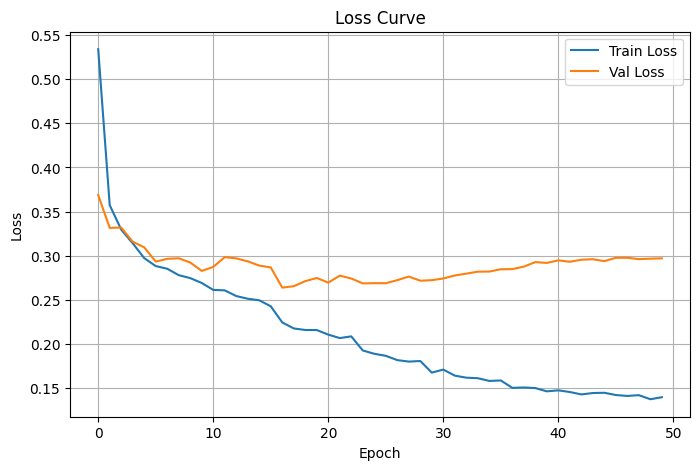

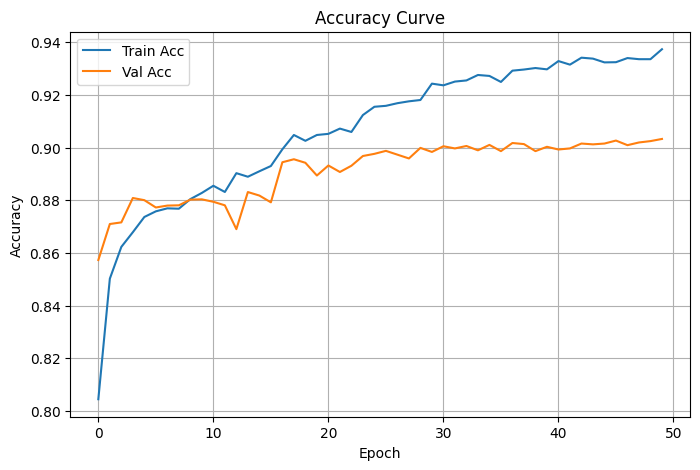

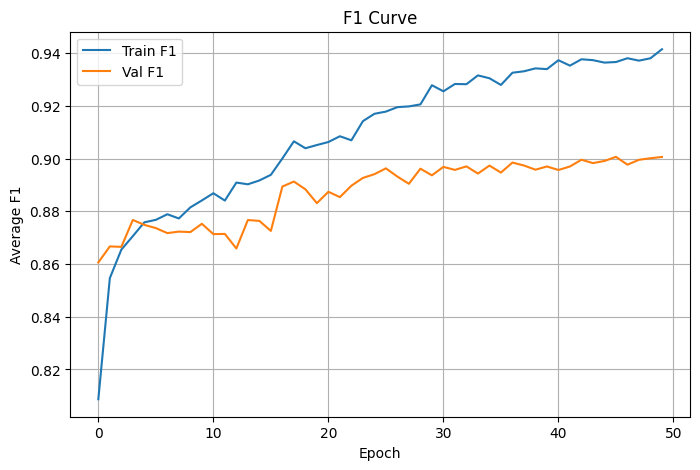


=== Final Evaluation Results ===
Accuracy     : 0.9025
Macro F1     : 0.9014
Micro F1     : 0.9025
Weighted F1  : 0.9025
Cohen's Kappa: 0.8400

Per-class F1 scores:
  Class 0: 0.9067
  Class 1: 0.8980
  Class 2: 0.8994

Confusion Matrix:
[[800416  19773  50845]
 [ 10760 243203   6812]
 [ 83334  17906 710667]]
Saved results to results/data_random_results.json

=== Run 6/13 — deterministic_CNN_data_diversity ===
X:  (14000, 6, 28)
y:  (14000,)
Before Normalisation

Global Mean: -0.0369
Global Std Dev: 1.1639

Per-Band Statistics:
  Band      Mean      Std
Band 1  0.011086 1.333951
Band 2  0.037107 1.271079
Band 3  0.003554 1.147517
Band 4 -0.051852 1.022512
Band 5 -0.131988 1.122293
Band 6 -0.089592 1.044065

Class Distribution:
 Class  Count  Percentage
     0   7790   55.642857
     1   1414   10.100000
     2   4796   34.257143


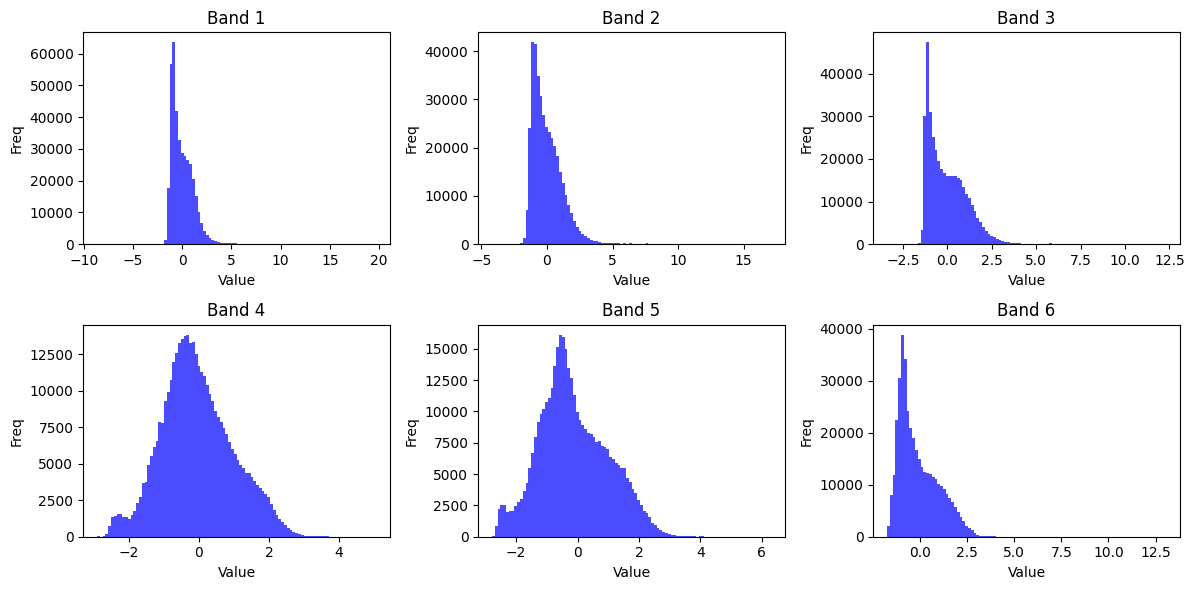

After Normalisation

Global Mean: 0.0000
Global Std Dev: 1.0000

Per-Band Statistics:
  Band          Mean      Std
Band 1 -1.428565e-08 1.000000
Band 2  2.635255e-08 0.999998
Band 3 -3.791829e-08 1.000000
Band 4  4.295670e-08 0.999999
Band 5  1.340496e-08 1.000001
Band 6  1.205814e-07 1.000001

Class Distribution:
 Class  Count  Percentage
     0   7790   55.642857
     1   1414   10.100000
     2   4796   34.257143


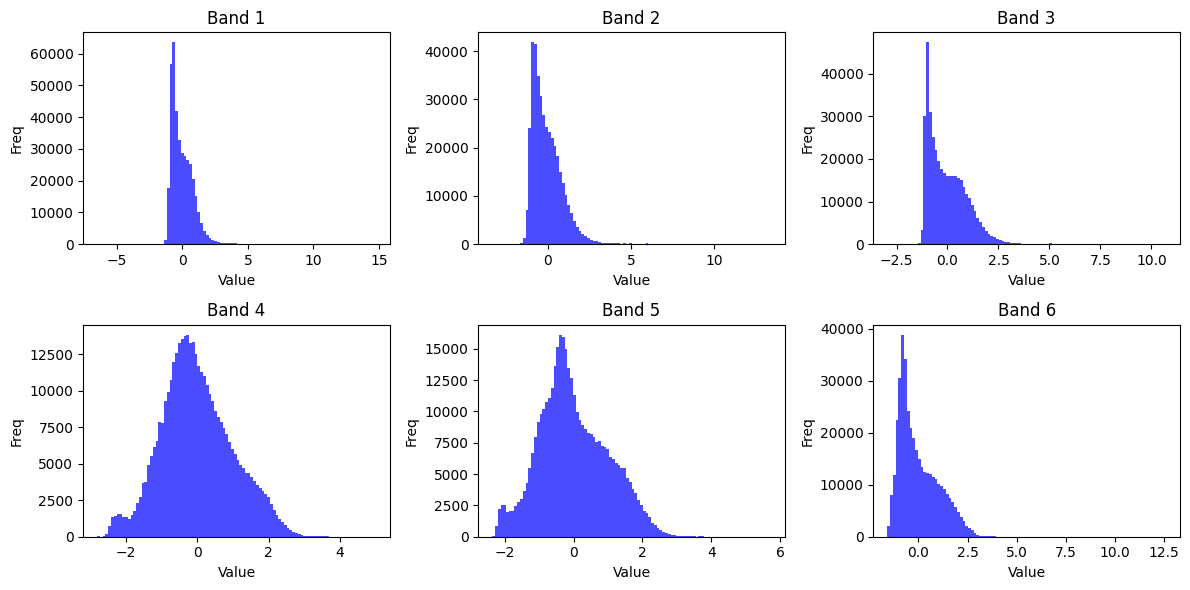

Class Weights: tensor([0.5991, 3.3003, 0.9730], device='cuda:0')



Epoch 1/50
Train — Loss: 0.6619 | Acc: 0.7396 | Avg F1: 0.7223
Val   — Loss: 0.3445 | Acc: 0.8436 | Avg F1: 0.8416



Epoch 2/50
Train — Loss: 0.4776 | Acc: 0.7976 | Avg F1: 0.7846
Val   — Loss: 0.3964 | Acc: 0.8327 | Avg F1: 0.8255



Epoch 3/50
Train — Loss: 0.4480 | Acc: 0.8079 | Avg F1: 0.7923
Val   — Loss: 0.3344 | Acc: 0.8547 | Avg F1: 0.8521



Epoch 4/50
Train — Loss: 0.4119 | Acc: 0.8278 | Avg F1: 0.8126
Val   — Loss: 0.3263 | Acc: 0.8356 | Avg F1: 0.8404



Epoch 5/50
Train — Loss: 0.3928 | Acc: 0.8308 | Avg F1: 0.8153
Val   — Loss: 0.3235 | Acc: 0.8240 | Avg F1: 0.8248



Epoch 6/50
Train — Loss: 0.3899 | Acc: 0.8311 | Avg F1: 0.8163
Val   — Loss: 0.3230 | Acc: 0.8657 | Avg F1: 0.8587



Epoch 7/50
Train — Loss: 0.3709 | Acc: 0.8415 | Avg F1: 0.8271
Val   — Loss: 0.3145 | Acc: 0.8469 | Avg F1: 0.8371



Epoch 8/50
Train — Loss: 0.3721 | Acc: 0.8416 | Avg F1: 0.8270
Val   — Loss: 0.2975 | Acc: 0.8675 | Avg F1: 0.8653



Epoch 9/50
Train — Loss: 0.3559 | Acc: 0.8461 | Avg F1: 0.8336
Val   — Loss: 0.2984 | Acc: 0.8602 | Avg F1: 0.8549



Epoch 10/50
Train — Loss: 0.3588 | Acc: 0.8426 | Avg F1: 0.8266
Val   — Loss: 0.2693 | Acc: 0.8650 | Avg F1: 0.8576



Epoch 11/50
Train — Loss: 0.3501 | Acc: 0.8492 | Avg F1: 0.8329
Val   — Loss: 0.3129 | Acc: 0.8593 | Avg F1: 0.8567



Epoch 12/50
Train — Loss: 0.3363 | Acc: 0.8516 | Avg F1: 0.8384
Val   — Loss: 0.2831 | Acc: 0.8634 | Avg F1: 0.8558



Epoch 13/50
Train — Loss: 0.3404 | Acc: 0.8516 | Avg F1: 0.8385
Val   — Loss: 0.3186 | Acc: 0.8677 | Avg F1: 0.8636



Epoch 14/50
Train — Loss: 0.3254 | Acc: 0.8586 | Avg F1: 0.8471
Val   — Loss: 0.2953 | Acc: 0.8593 | Avg F1: 0.8538



Epoch 15/50
Train — Loss: 0.3295 | Acc: 0.8556 | Avg F1: 0.8426
Val   — Loss: 0.2936 | Acc: 0.8652 | Avg F1: 0.8643



Epoch 16/50
Train — Loss: 0.3247 | Acc: 0.8581 | Avg F1: 0.8469
Val   — Loss: 0.2629 | Acc: 0.8761 | Avg F1: 0.8727



Epoch 17/50
Train — Loss: 0.3144 | Acc: 0.8623 | Avg F1: 0.8515
Val   — Loss: 0.2930 | Acc: 0.8531 | Avg F1: 0.8462



Epoch 18/50
Train — Loss: 0.3131 | Acc: 0.8644 | Avg F1: 0.8515
Val   — Loss: 0.2796 | Acc: 0.8705 | Avg F1: 0.8656



Epoch 19/50
Train — Loss: 0.3113 | Acc: 0.8629 | Avg F1: 0.8511
Val   — Loss: 0.2756 | Acc: 0.8684 | Avg F1: 0.8589



Epoch 20/50
Train — Loss: 0.3014 | Acc: 0.8651 | Avg F1: 0.8548
Val   — Loss: 0.2997 | Acc: 0.8496 | Avg F1: 0.8501



Epoch 21/50
Train — Loss: 0.2999 | Acc: 0.8655 | Avg F1: 0.8539
Val   — Loss: 0.2959 | Acc: 0.8745 | Avg F1: 0.8756



Epoch 22/50
Train — Loss: 0.2926 | Acc: 0.8691 | Avg F1: 0.8592
Val   — Loss: 0.2514 | Acc: 0.8826 | Avg F1: 0.8805



Epoch 23/50
Train — Loss: 0.2942 | Acc: 0.8712 | Avg F1: 0.8602
Val   — Loss: 0.2590 | Acc: 0.8792 | Avg F1: 0.8769



Epoch 24/50
Train — Loss: 0.2889 | Acc: 0.8700 | Avg F1: 0.8617
Val   — Loss: 0.2626 | Acc: 0.8739 | Avg F1: 0.8710



Epoch 25/50
Train — Loss: 0.2880 | Acc: 0.8717 | Avg F1: 0.8607
Val   — Loss: 0.2553 | Acc: 0.8744 | Avg F1: 0.8706



Epoch 26/50
Train — Loss: 0.2773 | Acc: 0.8754 | Avg F1: 0.8646
Val   — Loss: 0.2756 | Acc: 0.8750 | Avg F1: 0.8721



Epoch 27/50
Train — Loss: 0.2781 | Acc: 0.8771 | Avg F1: 0.8684
Val   — Loss: 0.2723 | Acc: 0.8782 | Avg F1: 0.8742



Epoch 28/50
Train — Loss: 0.2743 | Acc: 0.8780 | Avg F1: 0.8689
Val   — Loss: 0.2604 | Acc: 0.8791 | Avg F1: 0.8771



Epoch 29/50
Train — Loss: 0.2473 | Acc: 0.8883 | Avg F1: 0.8817
Val   — Loss: 0.2615 | Acc: 0.8810 | Avg F1: 0.8806



Epoch 30/50
Train — Loss: 0.2339 | Acc: 0.8891 | Avg F1: 0.8839
Val   — Loss: 0.2727 | Acc: 0.8869 | Avg F1: 0.8859



Epoch 31/50
Train — Loss: 0.2340 | Acc: 0.8916 | Avg F1: 0.8846
Val   — Loss: 0.2601 | Acc: 0.8902 | Avg F1: 0.8886



Epoch 32/50
Train — Loss: 0.2266 | Acc: 0.8965 | Avg F1: 0.8915
Val   — Loss: 0.2609 | Acc: 0.8883 | Avg F1: 0.8876



Epoch 33/50
Train — Loss: 0.2295 | Acc: 0.8937 | Avg F1: 0.8882
Val   — Loss: 0.2772 | Acc: 0.8788 | Avg F1: 0.8786



Epoch 34/50
Train — Loss: 0.2238 | Acc: 0.8986 | Avg F1: 0.8956
Val   — Loss: 0.2876 | Acc: 0.8821 | Avg F1: 0.8821



Epoch 35/50
Train — Loss: 0.2055 | Acc: 0.9035 | Avg F1: 0.9002
Val   — Loss: 0.2843 | Acc: 0.8902 | Avg F1: 0.8896



Epoch 36/50
Train — Loss: 0.2012 | Acc: 0.9049 | Avg F1: 0.9027
Val   — Loss: 0.2963 | Acc: 0.8854 | Avg F1: 0.8824



Epoch 37/50
Train — Loss: 0.2008 | Acc: 0.9055 | Avg F1: 0.9027
Val   — Loss: 0.2866 | Acc: 0.8942 | Avg F1: 0.8947



Epoch 38/50
Train — Loss: 0.1924 | Acc: 0.9079 | Avg F1: 0.9052
Val   — Loss: 0.2882 | Acc: 0.8902 | Avg F1: 0.8910



Epoch 39/50
Train — Loss: 0.1897 | Acc: 0.9091 | Avg F1: 0.9066
Val   — Loss: 0.2963 | Acc: 0.8917 | Avg F1: 0.8913



Epoch 40/50
Train — Loss: 0.1912 | Acc: 0.9070 | Avg F1: 0.9072
Val   — Loss: 0.2967 | Acc: 0.8920 | Avg F1: 0.8930



Epoch 41/50
Train — Loss: 0.1801 | Acc: 0.9152 | Avg F1: 0.9151
Val   — Loss: 0.2909 | Acc: 0.8943 | Avg F1: 0.8948



Epoch 42/50
Train — Loss: 0.1716 | Acc: 0.9153 | Avg F1: 0.9162
Val   — Loss: 0.3018 | Acc: 0.8947 | Avg F1: 0.8964



Epoch 43/50
Train — Loss: 0.1693 | Acc: 0.9166 | Avg F1: 0.9172
Val   — Loss: 0.3058 | Acc: 0.8927 | Avg F1: 0.8939



Epoch 44/50
Train — Loss: 0.1673 | Acc: 0.9154 | Avg F1: 0.9168
Val   — Loss: 0.3082 | Acc: 0.8932 | Avg F1: 0.8949



Epoch 45/50
Train — Loss: 0.1660 | Acc: 0.9196 | Avg F1: 0.9203
Val   — Loss: 0.3187 | Acc: 0.8941 | Avg F1: 0.8963



Epoch 46/50
Train — Loss: 0.1650 | Acc: 0.9198 | Avg F1: 0.9210
Val   — Loss: 0.3072 | Acc: 0.8965 | Avg F1: 0.8975



Epoch 47/50
Train — Loss: 0.1613 | Acc: 0.9221 | Avg F1: 0.9219
Val   — Loss: 0.3078 | Acc: 0.8963 | Avg F1: 0.8977



Epoch 48/50
Train — Loss: 0.1651 | Acc: 0.9215 | Avg F1: 0.9223
Val   — Loss: 0.3078 | Acc: 0.8936 | Avg F1: 0.8947



Epoch 49/50
Train — Loss: 0.1578 | Acc: 0.9238 | Avg F1: 0.9249
Val   — Loss: 0.3107 | Acc: 0.8944 | Avg F1: 0.8962



Epoch 50/50
Train — Loss: 0.1600 | Acc: 0.9233 | Avg F1: 0.9248
Val   — Loss: 0.3056 | Acc: 0.8953 | Avg F1: 0.8965


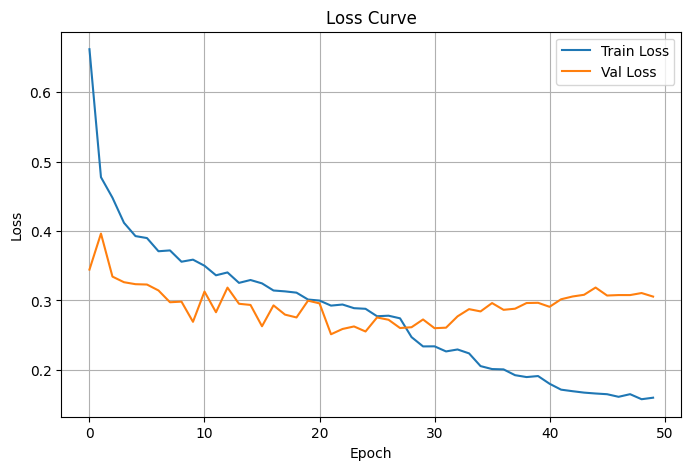

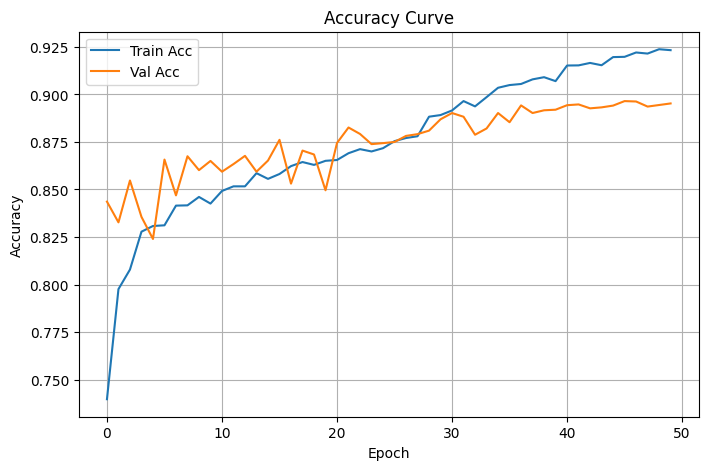

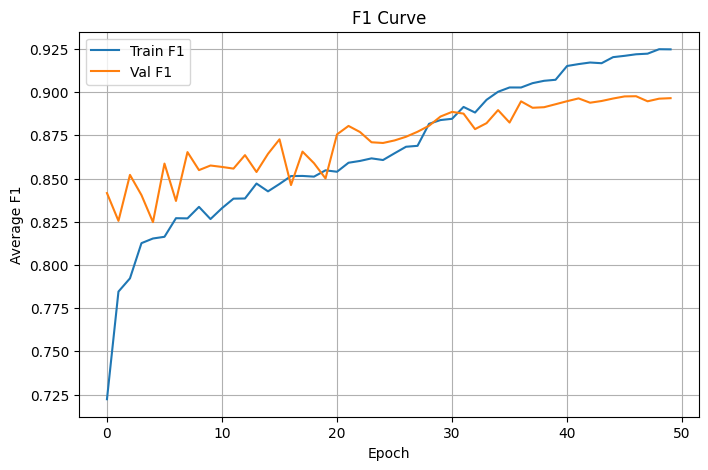


=== Final Evaluation Results ===
Accuracy     : 0.8966
Macro F1     : 0.8983
Micro F1     : 0.8966
Weighted F1  : 0.8966
Cohen's Kappa: 0.8300

Per-class F1 scores:
  Class 0: 0.8967
  Class 1: 0.9040
  Class 2: 0.8941

Confusion Matrix:
[[775800  16795  78439]
 [ 11972 240113   8690]
 [ 71561  13512 726834]]
Saved results to results/deterministic_CNN_data_diversity_results.json

=== Run 7/13 — deterministic_CNN_data_entropy ===
X:  (14000, 6, 28)
y:  (14000,)
Before Normalisation

Global Mean: -0.0838
Global Std Dev: 0.8254

Per-Band Statistics:
  Band      Mean      Std
Band 1 -0.097664 0.863352
Band 2 -0.066246 0.828119
Band 3 -0.069006 0.826177
Band 4 -0.139987 0.790407
Band 5 -0.059090 0.818277
Band 6 -0.070780 0.821827

Class Distribution:
 Class  Count  Percentage
     0   4432   31.657143
     1   3632   25.942857
     2   5936   42.400000


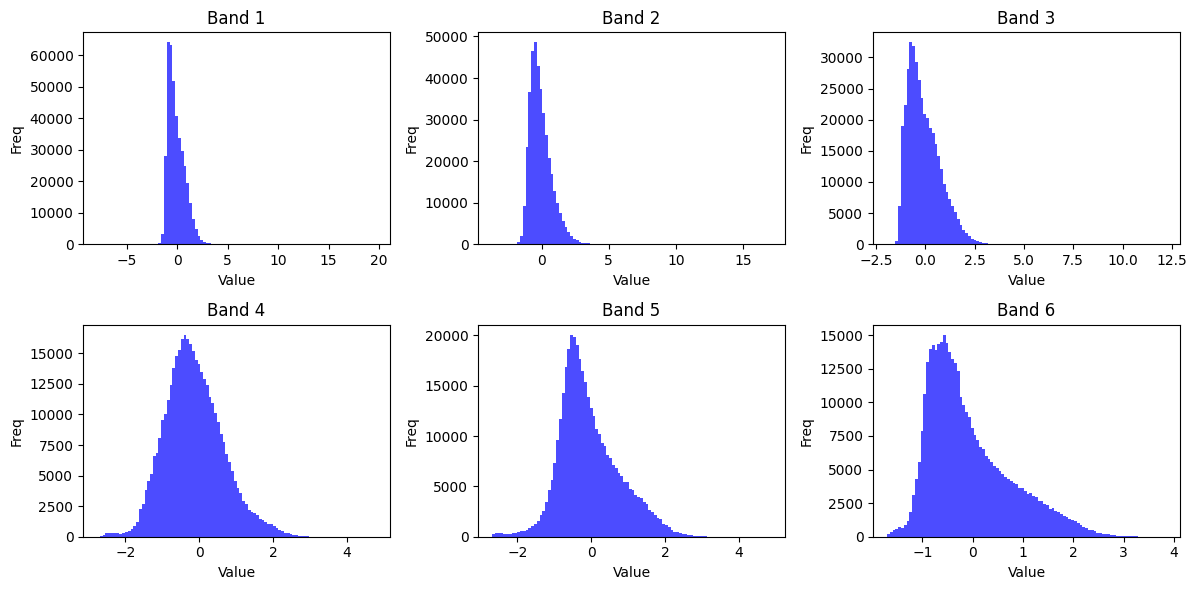

After Normalisation

Global Mean: -0.0000
Global Std Dev: 1.0000

Per-Band Statistics:
  Band          Mean      Std
Band 1 -1.277133e-07 0.999998
Band 2  3.150288e-08 1.000000
Band 3  4.744408e-08 1.000002
Band 4 -2.844948e-07 1.000000
Band 5 -1.267414e-07 0.999998
Band 6 -2.216904e-07 1.000002

Class Distribution:
 Class  Count  Percentage
     0   4432   31.657143
     1   3632   25.942857
     2   5936   42.400000


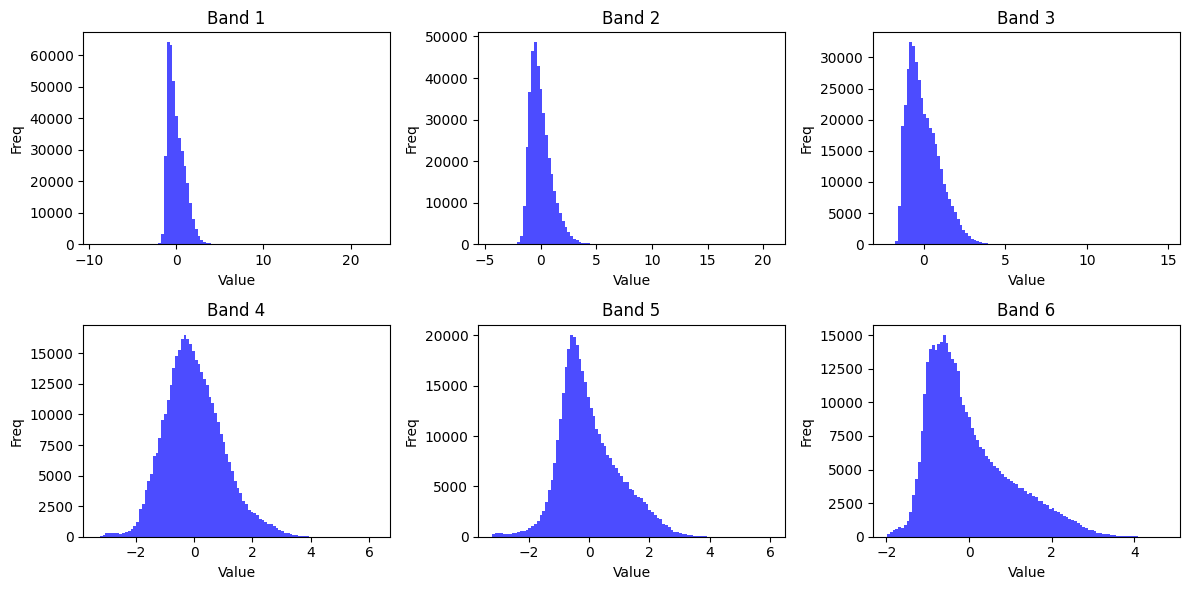

Class Weights: tensor([1.0529, 1.2849, 0.7862], device='cuda:0')



Epoch 1/50
Train — Loss: 1.0627 | Acc: 0.5580 | Avg F1: 0.5581
Val   — Loss: 0.9998 | Acc: 0.5589 | Avg F1: 0.5346



Epoch 2/50
Train — Loss: 0.8945 | Acc: 0.5817 | Avg F1: 0.5808
Val   — Loss: 0.8816 | Acc: 0.5727 | Avg F1: 0.5525



Epoch 3/50
Train — Loss: 0.8620 | Acc: 0.5933 | Avg F1: 0.5922
Val   — Loss: 0.8687 | Acc: 0.5926 | Avg F1: 0.5759



Epoch 4/50
Train — Loss: 0.8434 | Acc: 0.5966 | Avg F1: 0.5953
Val   — Loss: 0.8258 | Acc: 0.5927 | Avg F1: 0.5676



Epoch 5/50
Train — Loss: 0.8256 | Acc: 0.6069 | Avg F1: 0.6054
Val   — Loss: 0.7782 | Acc: 0.6255 | Avg F1: 0.6112



Epoch 6/50
Train — Loss: 0.8111 | Acc: 0.6167 | Avg F1: 0.6152
Val   — Loss: 0.6811 | Acc: 0.6865 | Avg F1: 0.6867



Epoch 7/50
Train — Loss: 0.7985 | Acc: 0.6229 | Avg F1: 0.6219
Val   — Loss: 0.7061 | Acc: 0.6480 | Avg F1: 0.6320



Epoch 8/50
Train — Loss: 0.7889 | Acc: 0.6245 | Avg F1: 0.6232
Val   — Loss: 0.5994 | Acc: 0.7409 | Avg F1: 0.7411



Epoch 9/50
Train — Loss: 0.7806 | Acc: 0.6327 | Avg F1: 0.6316
Val   — Loss: 0.5793 | Acc: 0.7681 | Avg F1: 0.7674



Epoch 10/50
Train — Loss: 0.7742 | Acc: 0.6334 | Avg F1: 0.6329
Val   — Loss: 0.5863 | Acc: 0.7867 | Avg F1: 0.7858



Epoch 11/50
Train — Loss: 0.7608 | Acc: 0.6427 | Avg F1: 0.6426
Val   — Loss: 0.5658 | Acc: 0.7824 | Avg F1: 0.7778



Epoch 12/50
Train — Loss: 0.7575 | Acc: 0.6501 | Avg F1: 0.6494
Val   — Loss: 0.5625 | Acc: 0.7887 | Avg F1: 0.7845



Epoch 13/50
Train — Loss: 0.7496 | Acc: 0.6516 | Avg F1: 0.6514
Val   — Loss: 0.5823 | Acc: 0.7706 | Avg F1: 0.7753



Epoch 14/50
Train — Loss: 0.7441 | Acc: 0.6516 | Avg F1: 0.6514
Val   — Loss: 0.5257 | Acc: 0.8033 | Avg F1: 0.8029



Epoch 15/50
Train — Loss: 0.7383 | Acc: 0.6557 | Avg F1: 0.6554
Val   — Loss: 0.5013 | Acc: 0.8229 | Avg F1: 0.8259



Epoch 16/50
Train — Loss: 0.7301 | Acc: 0.6556 | Avg F1: 0.6554
Val   — Loss: 0.5086 | Acc: 0.8199 | Avg F1: 0.8266



Epoch 17/50
Train — Loss: 0.7230 | Acc: 0.6689 | Avg F1: 0.6685
Val   — Loss: 0.5128 | Acc: 0.8239 | Avg F1: 0.8235



Epoch 18/50
Train — Loss: 0.7199 | Acc: 0.6656 | Avg F1: 0.6653
Val   — Loss: 0.4619 | Acc: 0.8406 | Avg F1: 0.8460



Epoch 19/50
Train — Loss: 0.7105 | Acc: 0.6726 | Avg F1: 0.6714
Val   — Loss: 0.4425 | Acc: 0.8459 | Avg F1: 0.8477



Epoch 20/50
Train — Loss: 0.7058 | Acc: 0.6756 | Avg F1: 0.6749
Val   — Loss: 0.4448 | Acc: 0.8400 | Avg F1: 0.8413



Epoch 21/50
Train — Loss: 0.7045 | Acc: 0.6742 | Avg F1: 0.6736
Val   — Loss: 0.4045 | Acc: 0.8625 | Avg F1: 0.8655



Epoch 22/50
Train — Loss: 0.6961 | Acc: 0.6799 | Avg F1: 0.6789
Val   — Loss: 0.4341 | Acc: 0.8443 | Avg F1: 0.8491



Epoch 23/50
Train — Loss: 0.6864 | Acc: 0.6895 | Avg F1: 0.6888
Val   — Loss: 0.4193 | Acc: 0.8515 | Avg F1: 0.8500



Epoch 24/50
Train — Loss: 0.6821 | Acc: 0.6923 | Avg F1: 0.6914
Val   — Loss: 0.3959 | Acc: 0.8568 | Avg F1: 0.8592



Epoch 25/50
Train — Loss: 0.6734 | Acc: 0.6918 | Avg F1: 0.6907
Val   — Loss: 0.3855 | Acc: 0.8624 | Avg F1: 0.8666



Epoch 26/50
Train — Loss: 0.6682 | Acc: 0.6974 | Avg F1: 0.6965
Val   — Loss: 0.3736 | Acc: 0.8713 | Avg F1: 0.8716



Epoch 27/50
Train — Loss: 0.6644 | Acc: 0.6973 | Avg F1: 0.6964
Val   — Loss: 0.3752 | Acc: 0.8640 | Avg F1: 0.8672



Epoch 28/50
Train — Loss: 0.6551 | Acc: 0.7042 | Avg F1: 0.7034
Val   — Loss: 0.3730 | Acc: 0.8620 | Avg F1: 0.8638



Epoch 29/50
Train — Loss: 0.6563 | Acc: 0.7035 | Avg F1: 0.7026
Val   — Loss: 0.3501 | Acc: 0.8672 | Avg F1: 0.8689



Epoch 30/50
Train — Loss: 0.6460 | Acc: 0.7024 | Avg F1: 0.7012
Val   — Loss: 0.3396 | Acc: 0.8653 | Avg F1: 0.8684



Epoch 31/50
Train — Loss: 0.6404 | Acc: 0.7121 | Avg F1: 0.7111
Val   — Loss: 0.3510 | Acc: 0.8708 | Avg F1: 0.8723



Epoch 32/50
Train — Loss: 0.6356 | Acc: 0.7099 | Avg F1: 0.7090
Val   — Loss: 0.3805 | Acc: 0.8442 | Avg F1: 0.8498



Epoch 33/50
Train — Loss: 0.6304 | Acc: 0.7161 | Avg F1: 0.7154
Val   — Loss: 0.3588 | Acc: 0.8566 | Avg F1: 0.8611



Epoch 34/50
Train — Loss: 0.6195 | Acc: 0.7179 | Avg F1: 0.7170
Val   — Loss: 0.3467 | Acc: 0.8578 | Avg F1: 0.8617



Epoch 35/50
Train — Loss: 0.6197 | Acc: 0.7214 | Avg F1: 0.7202
Val   — Loss: 0.3690 | Acc: 0.8587 | Avg F1: 0.8592



Epoch 36/50
Train — Loss: 0.6155 | Acc: 0.7241 | Avg F1: 0.7235
Val   — Loss: 0.3418 | Acc: 0.8676 | Avg F1: 0.8708



Epoch 37/50
Train — Loss: 0.6054 | Acc: 0.7314 | Avg F1: 0.7306
Val   — Loss: 0.3325 | Acc: 0.8592 | Avg F1: 0.8628



Epoch 38/50
Train — Loss: 0.5810 | Acc: 0.7404 | Avg F1: 0.7397
Val   — Loss: 0.3096 | Acc: 0.8752 | Avg F1: 0.8770



Epoch 39/50
Train — Loss: 0.5772 | Acc: 0.7438 | Avg F1: 0.7435
Val   — Loss: 0.3789 | Acc: 0.8273 | Avg F1: 0.8386



Epoch 40/50
Train — Loss: 0.5645 | Acc: 0.7490 | Avg F1: 0.7482
Val   — Loss: 0.3289 | Acc: 0.8642 | Avg F1: 0.8662



Epoch 41/50
Train — Loss: 0.5626 | Acc: 0.7511 | Avg F1: 0.7502
Val   — Loss: 0.3341 | Acc: 0.8614 | Avg F1: 0.8653



Epoch 42/50
Train — Loss: 0.5617 | Acc: 0.7509 | Avg F1: 0.7503
Val   — Loss: 0.3227 | Acc: 0.8652 | Avg F1: 0.8695



Epoch 43/50
Train — Loss: 0.5554 | Acc: 0.7534 | Avg F1: 0.7527
Val   — Loss: 0.3692 | Acc: 0.8375 | Avg F1: 0.8468



Epoch 44/50
Train — Loss: 0.5457 | Acc: 0.7605 | Avg F1: 0.7597
Val   — Loss: 0.3210 | Acc: 0.8655 | Avg F1: 0.8720



Epoch 45/50
Train — Loss: 0.5412 | Acc: 0.7617 | Avg F1: 0.7611
Val   — Loss: 0.3080 | Acc: 0.8740 | Avg F1: 0.8771



Epoch 46/50
Train — Loss: 0.5305 | Acc: 0.7686 | Avg F1: 0.7678
Val   — Loss: 0.3218 | Acc: 0.8691 | Avg F1: 0.8729



Epoch 47/50
Train — Loss: 0.5244 | Acc: 0.7709 | Avg F1: 0.7707
Val   — Loss: 0.3389 | Acc: 0.8565 | Avg F1: 0.8638



Epoch 48/50
Train — Loss: 0.5240 | Acc: 0.7720 | Avg F1: 0.7713
Val   — Loss: 0.3266 | Acc: 0.8636 | Avg F1: 0.8681



Epoch 49/50
Train — Loss: 0.5205 | Acc: 0.7687 | Avg F1: 0.7684
Val   — Loss: 0.3677 | Acc: 0.8411 | Avg F1: 0.8507



Epoch 50/50
Train — Loss: 0.5167 | Acc: 0.7719 | Avg F1: 0.7719
Val   — Loss: 0.3319 | Acc: 0.8609 | Avg F1: 0.8667


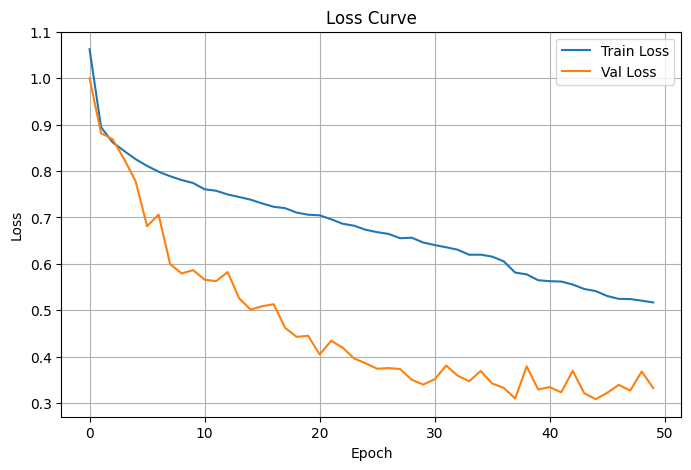

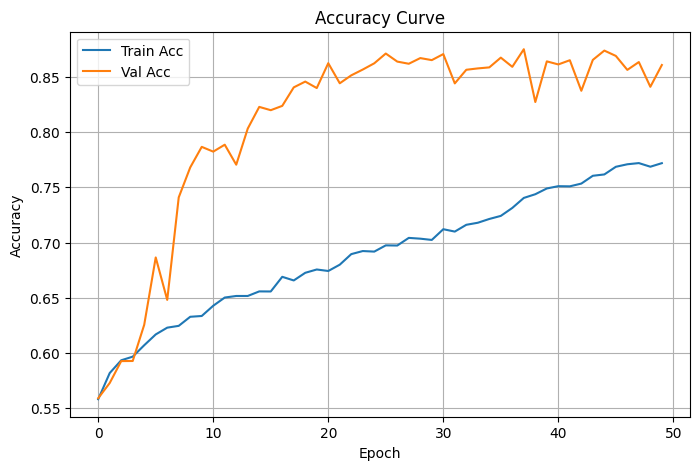

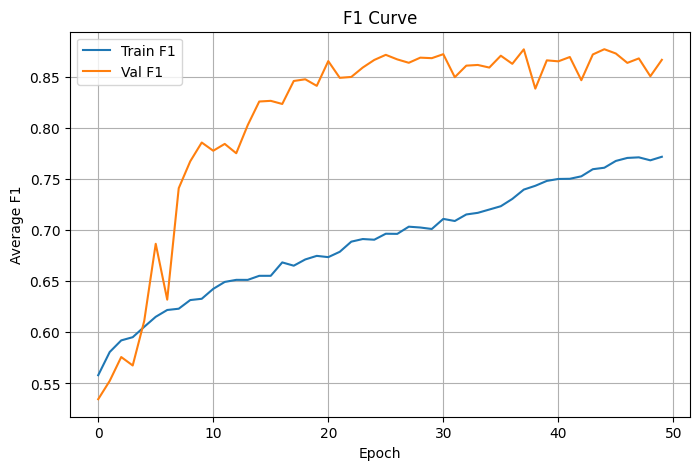


=== Final Evaluation Results ===
Accuracy     : 0.8626
Macro F1     : 0.8694
Micro F1     : 0.8626
Weighted F1  : 0.8618
Cohen's Kappa: 0.7741

Per-class F1 scores:
  Class 0: 0.8674
  Class 1: 0.8959
  Class 2: 0.8449

Confusion Matrix:
[[796170  20480  54384]
 [ 12321 242490   5964]
 [156305  17585 638017]]
Saved results to results/deterministic_CNN_data_entropy_results.json

=== Run 8/13 — deterministic_CNN_data_entropy_diversity ===
X:  (14000, 6, 28)
y:  (14000,)
Before Normalisation

Global Mean: -0.0795
Global Std Dev: 0.8446

Per-Band Statistics:
  Band      Mean      Std
Band 1 -0.085337 0.893961
Band 2 -0.057662 0.854971
Band 3 -0.073920 0.845690
Band 4 -0.121718 0.801704
Band 5 -0.064856 0.833132
Band 6 -0.073681 0.833906

Class Distribution:
 Class  Count  Percentage
     0   5459   38.992857
     1   1899   13.564286
     2   6642   47.442857


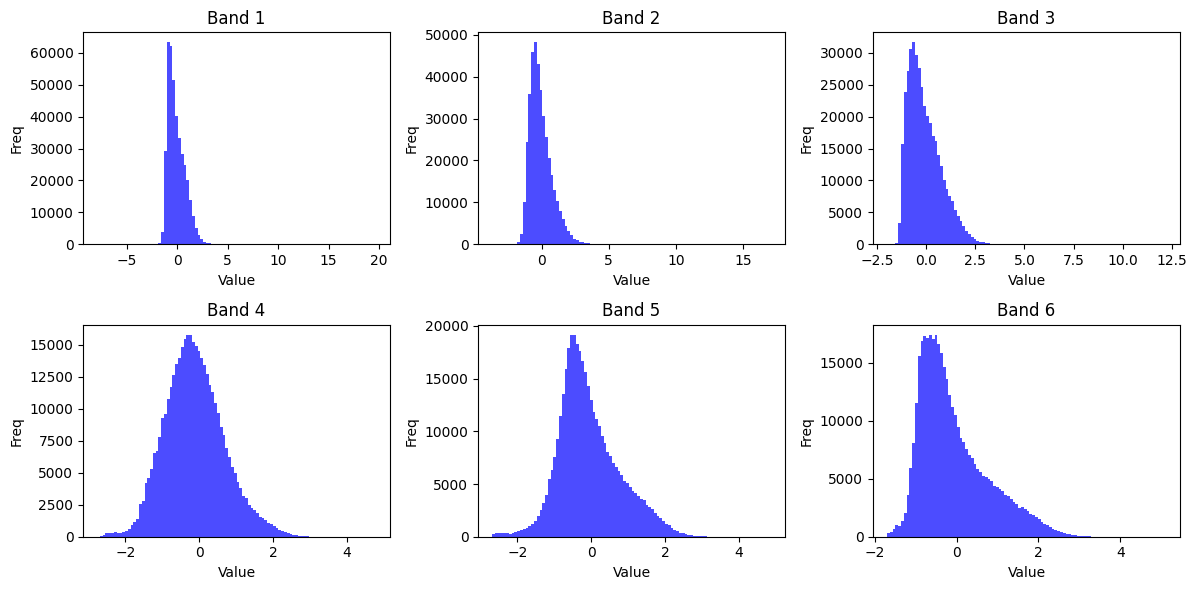

After Normalisation

Global Mean: 0.0000
Global Std Dev: 1.0000

Per-Band Statistics:
  Band          Mean      Std
Band 1 -8.391847e-08 0.999999
Band 2  2.467413e-07 1.000000
Band 3 -1.288823e-07 1.000001
Band 4  2.132824e-07 0.999996
Band 5  9.608269e-08 1.000001
Band 6  2.973347e-07 0.999999

Class Distribution:
 Class  Count  Percentage
     0   5459   38.992857
     1   1899   13.564286
     2   6642   47.442857


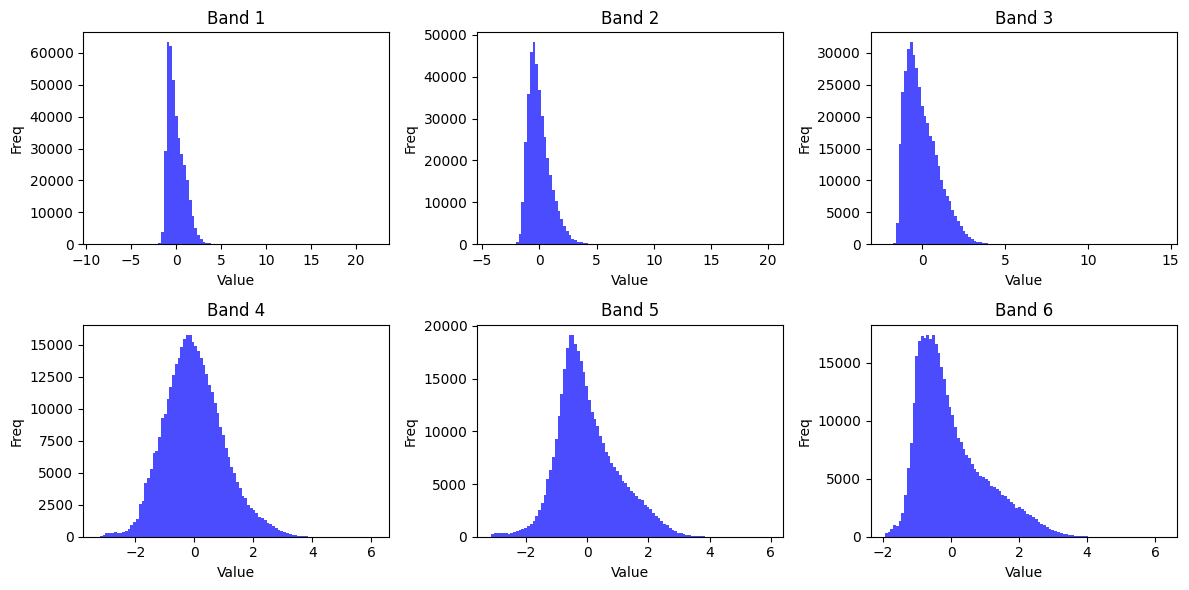

Class Weights: tensor([0.8549, 2.4574, 0.7026], device='cuda:0')



Epoch 1/50
Train — Loss: 1.1332 | Acc: 0.4971 | Avg F1: 0.4777
Val   — Loss: 0.7271 | Acc: 0.5955 | Avg F1: 0.5934



Epoch 2/50
Train — Loss: 0.9292 | Acc: 0.5201 | Avg F1: 0.5015
Val   — Loss: 0.7261 | Acc: 0.6081 | Avg F1: 0.6131



Epoch 3/50
Train — Loss: 0.8953 | Acc: 0.5329 | Avg F1: 0.5156
Val   — Loss: 0.7330 | Acc: 0.6225 | Avg F1: 0.6230



Epoch 4/50
Train — Loss: 0.8716 | Acc: 0.5480 | Avg F1: 0.5310
Val   — Loss: 0.6733 | Acc: 0.6507 | Avg F1: 0.6534



Epoch 5/50
Train — Loss: 0.8608 | Acc: 0.5572 | Avg F1: 0.5388
Val   — Loss: 0.5712 | Acc: 0.7364 | Avg F1: 0.7355



Epoch 6/50
Train — Loss: 0.8448 | Acc: 0.5625 | Avg F1: 0.5446
Val   — Loss: 0.5959 | Acc: 0.6689 | Avg F1: 0.6753



Epoch 7/50
Train — Loss: 0.8293 | Acc: 0.5742 | Avg F1: 0.5565
Val   — Loss: 0.5790 | Acc: 0.6949 | Avg F1: 0.7035



Epoch 8/50
Train — Loss: 0.8210 | Acc: 0.5777 | Avg F1: 0.5604
Val   — Loss: 0.5899 | Acc: 0.7018 | Avg F1: 0.7044



Epoch 9/50
Train — Loss: 0.8172 | Acc: 0.5827 | Avg F1: 0.5645
Val   — Loss: 0.5590 | Acc: 0.7245 | Avg F1: 0.7307



Epoch 10/50
Train — Loss: 0.8033 | Acc: 0.5911 | Avg F1: 0.5742
Val   — Loss: 0.5132 | Acc: 0.7532 | Avg F1: 0.7596



Epoch 11/50
Train — Loss: 0.7945 | Acc: 0.5956 | Avg F1: 0.5769
Val   — Loss: 0.5079 | Acc: 0.7601 | Avg F1: 0.7642



Epoch 12/50
Train — Loss: 0.7893 | Acc: 0.5972 | Avg F1: 0.5791
Val   — Loss: 0.5044 | Acc: 0.7870 | Avg F1: 0.7896



Epoch 13/50
Train — Loss: 0.7810 | Acc: 0.6044 | Avg F1: 0.5870
Val   — Loss: 0.4566 | Acc: 0.8054 | Avg F1: 0.8095



Epoch 14/50
Train — Loss: 0.7735 | Acc: 0.6080 | Avg F1: 0.5894
Val   — Loss: 0.4614 | Acc: 0.7941 | Avg F1: 0.7991



Epoch 15/50
Train — Loss: 0.7670 | Acc: 0.6161 | Avg F1: 0.5973
Val   — Loss: 0.4432 | Acc: 0.8243 | Avg F1: 0.8251



Epoch 16/50
Train — Loss: 0.7617 | Acc: 0.6203 | Avg F1: 0.6017
Val   — Loss: 0.4599 | Acc: 0.8074 | Avg F1: 0.8131



Epoch 17/50
Train — Loss: 0.7551 | Acc: 0.6206 | Avg F1: 0.6008
Val   — Loss: 0.4271 | Acc: 0.8144 | Avg F1: 0.8194



Epoch 18/50
Train — Loss: 0.7477 | Acc: 0.6231 | Avg F1: 0.6054
Val   — Loss: 0.4512 | Acc: 0.7945 | Avg F1: 0.7948



Epoch 19/50
Train — Loss: 0.7463 | Acc: 0.6263 | Avg F1: 0.6083
Val   — Loss: 0.4541 | Acc: 0.8143 | Avg F1: 0.8082



Epoch 20/50
Train — Loss: 0.7370 | Acc: 0.6336 | Avg F1: 0.6161
Val   — Loss: 0.4304 | Acc: 0.8249 | Avg F1: 0.8303



Epoch 21/50
Train — Loss: 0.7287 | Acc: 0.6373 | Avg F1: 0.6185
Val   — Loss: 0.3876 | Acc: 0.8284 | Avg F1: 0.8273



Epoch 22/50
Train — Loss: 0.7241 | Acc: 0.6403 | Avg F1: 0.6218
Val   — Loss: 0.3983 | Acc: 0.8535 | Avg F1: 0.8528



Epoch 23/50
Train — Loss: 0.7223 | Acc: 0.6401 | Avg F1: 0.6204
Val   — Loss: 0.3793 | Acc: 0.8397 | Avg F1: 0.8421



Epoch 24/50
Train — Loss: 0.7111 | Acc: 0.6437 | Avg F1: 0.6259
Val   — Loss: 0.3605 | Acc: 0.8568 | Avg F1: 0.8558



Epoch 25/50
Train — Loss: 0.7042 | Acc: 0.6488 | Avg F1: 0.6310
Val   — Loss: 0.3635 | Acc: 0.8334 | Avg F1: 0.8330



Epoch 26/50
Train — Loss: 0.6984 | Acc: 0.6546 | Avg F1: 0.6366
Val   — Loss: 0.3522 | Acc: 0.8574 | Avg F1: 0.8549



Epoch 27/50
Train — Loss: 0.6932 | Acc: 0.6516 | Avg F1: 0.6343
Val   — Loss: 0.3618 | Acc: 0.8560 | Avg F1: 0.8527



Epoch 28/50
Train — Loss: 0.6923 | Acc: 0.6514 | Avg F1: 0.6337
Val   — Loss: 0.3457 | Acc: 0.8641 | Avg F1: 0.8617



Epoch 29/50
Train — Loss: 0.6811 | Acc: 0.6621 | Avg F1: 0.6438
Val   — Loss: 0.3511 | Acc: 0.8680 | Avg F1: 0.8668



Epoch 30/50
Train — Loss: 0.6732 | Acc: 0.6650 | Avg F1: 0.6480
Val   — Loss: 0.3414 | Acc: 0.8577 | Avg F1: 0.8546



Epoch 31/50
Train — Loss: 0.6703 | Acc: 0.6696 | Avg F1: 0.6521
Val   — Loss: 0.3340 | Acc: 0.8660 | Avg F1: 0.8647



Epoch 32/50
Train — Loss: 0.6623 | Acc: 0.6791 | Avg F1: 0.6606
Val   — Loss: 0.3339 | Acc: 0.8620 | Avg F1: 0.8591



Epoch 33/50
Train — Loss: 0.6585 | Acc: 0.6774 | Avg F1: 0.6596
Val   — Loss: 0.3151 | Acc: 0.8674 | Avg F1: 0.8633



Epoch 34/50
Train — Loss: 0.6516 | Acc: 0.6788 | Avg F1: 0.6608
Val   — Loss: 0.3318 | Acc: 0.8718 | Avg F1: 0.8678



Epoch 35/50
Train — Loss: 0.6441 | Acc: 0.6866 | Avg F1: 0.6701
Val   — Loss: 0.3153 | Acc: 0.8755 | Avg F1: 0.8732



Epoch 36/50
Train — Loss: 0.6375 | Acc: 0.6874 | Avg F1: 0.6708
Val   — Loss: 0.3247 | Acc: 0.8715 | Avg F1: 0.8688



Epoch 37/50
Train — Loss: 0.6274 | Acc: 0.6965 | Avg F1: 0.6789
Val   — Loss: 0.3112 | Acc: 0.8811 | Avg F1: 0.8776



Epoch 38/50
Train — Loss: 0.6311 | Acc: 0.6891 | Avg F1: 0.6724
Val   — Loss: 0.3494 | Acc: 0.8596 | Avg F1: 0.8601



Epoch 39/50
Train — Loss: 0.6215 | Acc: 0.6978 | Avg F1: 0.6803
Val   — Loss: 0.3300 | Acc: 0.8744 | Avg F1: 0.8720



Epoch 40/50
Train — Loss: 0.6122 | Acc: 0.7016 | Avg F1: 0.6861
Val   — Loss: 0.3205 | Acc: 0.8717 | Avg F1: 0.8688



Epoch 41/50
Train — Loss: 0.6164 | Acc: 0.7008 | Avg F1: 0.6850
Val   — Loss: 0.3087 | Acc: 0.8793 | Avg F1: 0.8749



Epoch 42/50
Train — Loss: 0.6004 | Acc: 0.7086 | Avg F1: 0.6921
Val   — Loss: 0.3326 | Acc: 0.8768 | Avg F1: 0.8701



Epoch 43/50
Train — Loss: 0.6018 | Acc: 0.7064 | Avg F1: 0.6902
Val   — Loss: 0.3233 | Acc: 0.8796 | Avg F1: 0.8778



Epoch 44/50
Train — Loss: 0.5893 | Acc: 0.7131 | Avg F1: 0.6980
Val   — Loss: 0.3260 | Acc: 0.8712 | Avg F1: 0.8688



Epoch 45/50
Train — Loss: 0.5874 | Acc: 0.7131 | Avg F1: 0.6981
Val   — Loss: 0.3047 | Acc: 0.8800 | Avg F1: 0.8775



Epoch 46/50
Train — Loss: 0.5757 | Acc: 0.7184 | Avg F1: 0.7035
Val   — Loss: 0.3400 | Acc: 0.8745 | Avg F1: 0.8726



Epoch 47/50
Train — Loss: 0.5747 | Acc: 0.7201 | Avg F1: 0.7063
Val   — Loss: 0.3129 | Acc: 0.8746 | Avg F1: 0.8689



Epoch 48/50
Train — Loss: 0.5656 | Acc: 0.7276 | Avg F1: 0.7119
Val   — Loss: 0.3211 | Acc: 0.8765 | Avg F1: 0.8767



Epoch 49/50
Train — Loss: 0.5583 | Acc: 0.7279 | Avg F1: 0.7138
Val   — Loss: 0.3213 | Acc: 0.8832 | Avg F1: 0.8835



Epoch 50/50
Train — Loss: 0.5531 | Acc: 0.7307 | Avg F1: 0.7168
Val   — Loss: 0.3273 | Acc: 0.8782 | Avg F1: 0.8756


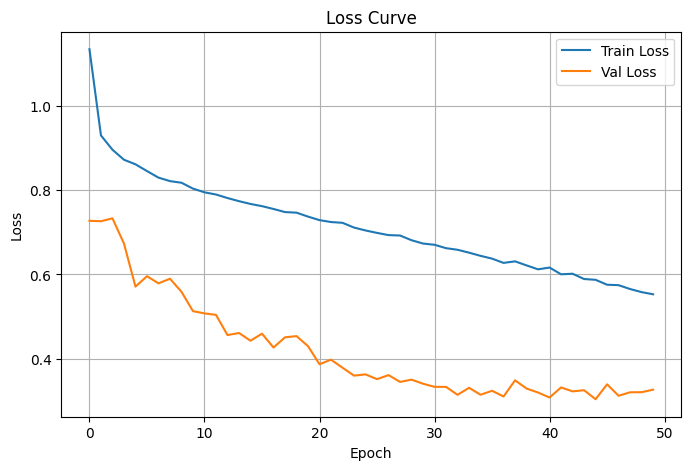

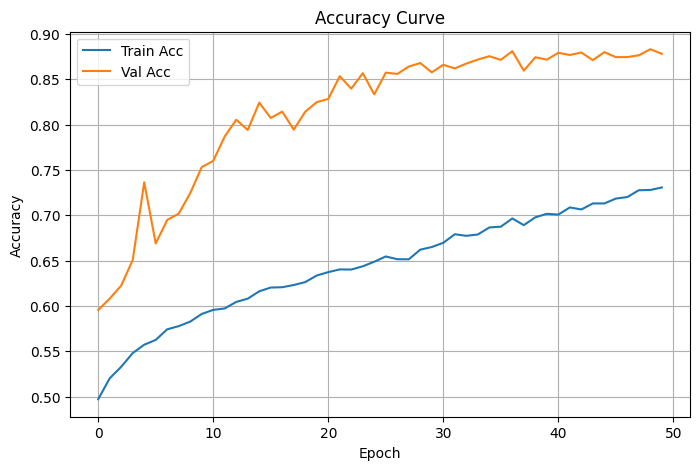

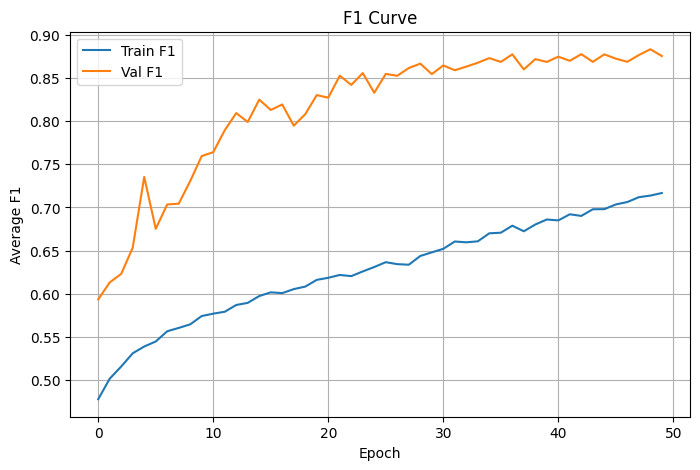


=== Final Evaluation Results ===
Accuracy     : 0.8760
Macro F1     : 0.8729
Micro F1     : 0.8760
Weighted F1  : 0.8761
Cohen's Kappa: 0.7966

Per-class F1 scores:
  Class 0: 0.8802
  Class 1: 0.8624
  Class 2: 0.8760

Confusion Matrix:
[[768509  21021  81504]
 [ 21803 233877   5095]
 [ 84903  26690 700314]]
Saved results to results/deterministic_CNN_data_entropy_diversity_results.json

=== Run 9/13 — deterministic_CNN_data_margin ===
X:  (14000, 6, 28)
y:  (14000,)
Before Normalisation

Global Mean: -0.0082
Global Std Dev: 0.8955

Per-Band Statistics:
  Band      Mean      Std
Band 1 -0.007580 0.924015
Band 2  0.024273 0.906839
Band 3  0.011931 0.900226
Band 4 -0.093936 0.842312
Band 5  0.012626 0.896521
Band 6  0.003563 0.895847

Class Distribution:
 Class  Count  Percentage
     0   6375   45.535714
     1   1412   10.085714
     2   6213   44.378571


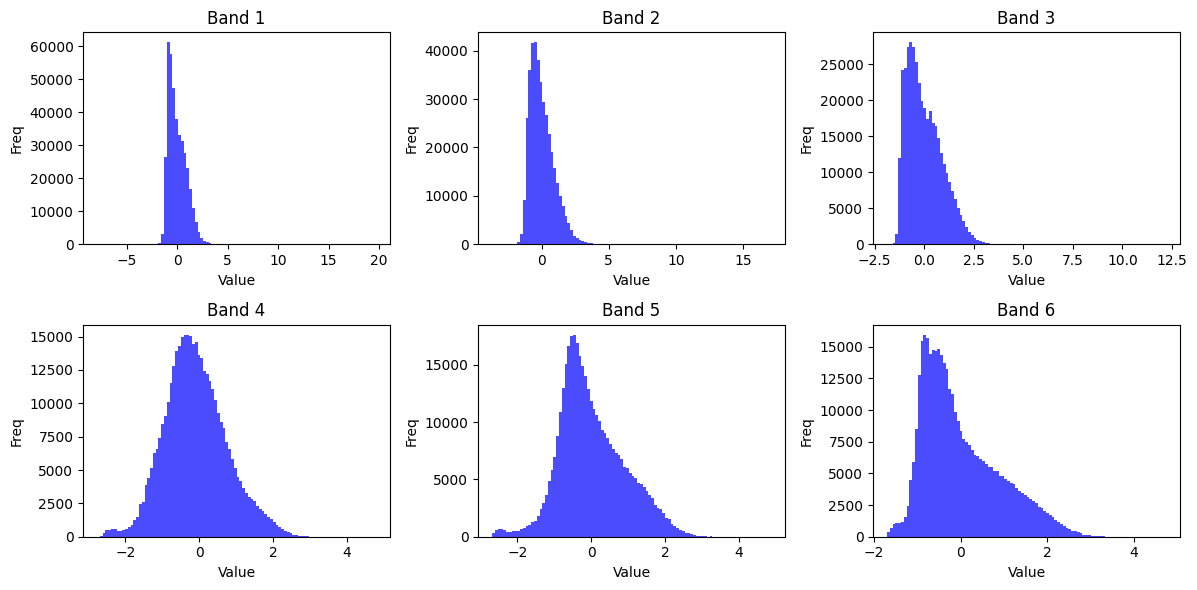

After Normalisation

Global Mean: -0.0000
Global Std Dev: 1.0000

Per-Band Statistics:
  Band          Mean      Std
Band 1 -3.183131e-08 0.999997
Band 2 -9.123160e-10 0.999998
Band 3  5.108970e-08 0.999999
Band 4 -3.041588e-07 0.999998
Band 5  3.542949e-08 1.000000
Band 6  2.590004e-08 1.000001

Class Distribution:
 Class  Count  Percentage
     0   6375   45.535714
     1   1412   10.085714
     2   6213   44.378571


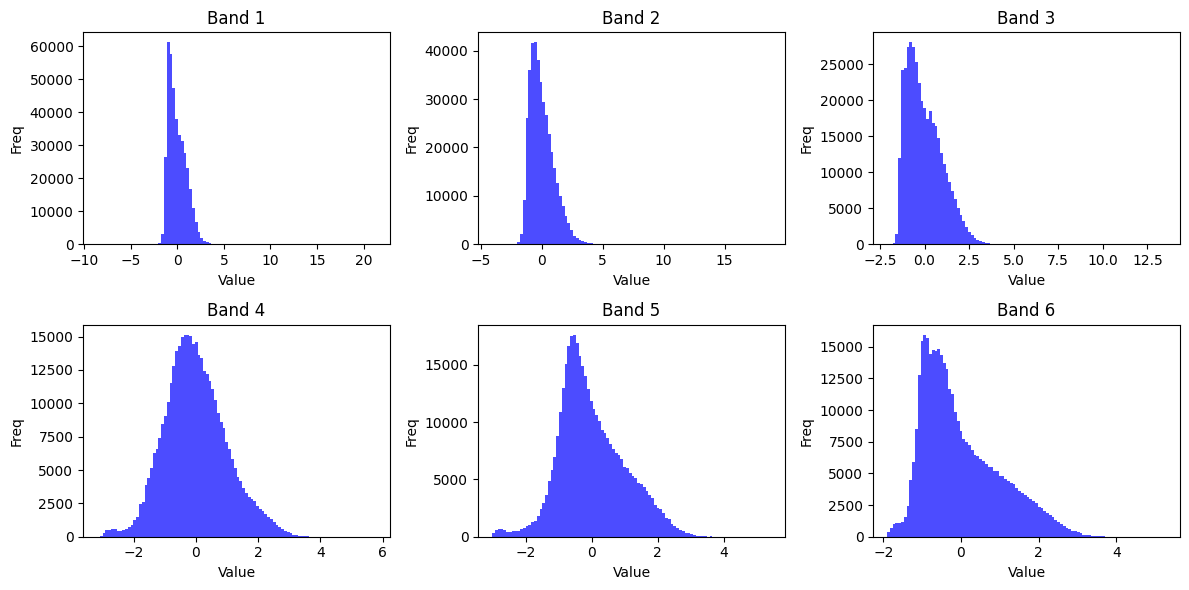

Class Weights: tensor([0.7320, 3.3050, 0.7511], device='cuda:0')



Epoch 1/50
Train — Loss: 1.0165 | Acc: 0.5285 | Avg F1: 0.5074
Val   — Loss: 0.5220 | Acc: 0.6814 | Avg F1: 0.7012



Epoch 2/50
Train — Loss: 0.8384 | Acc: 0.5455 | Avg F1: 0.5306
Val   — Loss: 0.5202 | Acc: 0.6714 | Avg F1: 0.6750



Epoch 3/50
Train — Loss: 0.8085 | Acc: 0.5607 | Avg F1: 0.5429
Val   — Loss: 0.5434 | Acc: 0.7277 | Avg F1: 0.7436



Epoch 4/50
Train — Loss: 0.7854 | Acc: 0.5698 | Avg F1: 0.5537
Val   — Loss: 0.4949 | Acc: 0.7430 | Avg F1: 0.7593



Epoch 5/50
Train — Loss: 0.7704 | Acc: 0.5772 | Avg F1: 0.5571
Val   — Loss: 0.4910 | Acc: 0.7715 | Avg F1: 0.7828



Epoch 6/50
Train — Loss: 0.7557 | Acc: 0.5836 | Avg F1: 0.5656
Val   — Loss: 0.5044 | Acc: 0.7411 | Avg F1: 0.7560



Epoch 7/50
Train — Loss: 0.7477 | Acc: 0.5866 | Avg F1: 0.5687
Val   — Loss: 0.4972 | Acc: 0.7248 | Avg F1: 0.7409



Epoch 8/50
Train — Loss: 0.7378 | Acc: 0.5922 | Avg F1: 0.5746
Val   — Loss: 0.4740 | Acc: 0.7766 | Avg F1: 0.7869



Epoch 9/50
Train — Loss: 0.7335 | Acc: 0.5996 | Avg F1: 0.5806
Val   — Loss: 0.4765 | Acc: 0.7536 | Avg F1: 0.7691



Epoch 10/50
Train — Loss: 0.7200 | Acc: 0.6064 | Avg F1: 0.5880
Val   — Loss: 0.4714 | Acc: 0.7846 | Avg F1: 0.7908



Epoch 11/50
Train — Loss: 0.7107 | Acc: 0.6105 | Avg F1: 0.5937
Val   — Loss: 0.4643 | Acc: 0.7518 | Avg F1: 0.7669



Epoch 12/50
Train — Loss: 0.7098 | Acc: 0.6108 | Avg F1: 0.5934
Val   — Loss: 0.4780 | Acc: 0.7347 | Avg F1: 0.7510



Epoch 13/50
Train — Loss: 0.7042 | Acc: 0.6146 | Avg F1: 0.5957
Val   — Loss: 0.4356 | Acc: 0.7790 | Avg F1: 0.7902



Epoch 14/50
Train — Loss: 0.6968 | Acc: 0.6184 | Avg F1: 0.6002
Val   — Loss: 0.4417 | Acc: 0.8089 | Avg F1: 0.8141



Epoch 15/50
Train — Loss: 0.7005 | Acc: 0.6171 | Avg F1: 0.5990
Val   — Loss: 0.4158 | Acc: 0.8112 | Avg F1: 0.8197



Epoch 16/50
Train — Loss: 0.6851 | Acc: 0.6264 | Avg F1: 0.6090
Val   — Loss: 0.4557 | Acc: 0.7935 | Avg F1: 0.8018



Epoch 17/50
Train — Loss: 0.6812 | Acc: 0.6308 | Avg F1: 0.6124
Val   — Loss: 0.4274 | Acc: 0.7899 | Avg F1: 0.7974



Epoch 18/50
Train — Loss: 0.6754 | Acc: 0.6384 | Avg F1: 0.6193
Val   — Loss: 0.4082 | Acc: 0.7866 | Avg F1: 0.7950



Epoch 19/50
Train — Loss: 0.6702 | Acc: 0.6433 | Avg F1: 0.6245
Val   — Loss: 0.4355 | Acc: 0.8008 | Avg F1: 0.8060



Epoch 20/50
Train — Loss: 0.6636 | Acc: 0.6449 | Avg F1: 0.6262
Val   — Loss: 0.4154 | Acc: 0.8267 | Avg F1: 0.8308



Epoch 21/50
Train — Loss: 0.6564 | Acc: 0.6466 | Avg F1: 0.6293
Val   — Loss: 0.4310 | Acc: 0.7967 | Avg F1: 0.8068



Epoch 22/50
Train — Loss: 0.6555 | Acc: 0.6496 | Avg F1: 0.6321
Val   — Loss: 0.4096 | Acc: 0.8304 | Avg F1: 0.8295



Epoch 23/50
Train — Loss: 0.6560 | Acc: 0.6503 | Avg F1: 0.6337
Val   — Loss: 0.4059 | Acc: 0.8300 | Avg F1: 0.8332



Epoch 24/50
Train — Loss: 0.6496 | Acc: 0.6521 | Avg F1: 0.6338
Val   — Loss: 0.4042 | Acc: 0.8208 | Avg F1: 0.8215



Epoch 25/50
Train — Loss: 0.6362 | Acc: 0.6607 | Avg F1: 0.6433
Val   — Loss: 0.3771 | Acc: 0.8454 | Avg F1: 0.8426



Epoch 26/50
Train — Loss: 0.6240 | Acc: 0.6639 | Avg F1: 0.6458
Val   — Loss: 0.3869 | Acc: 0.8104 | Avg F1: 0.8153



Epoch 27/50
Train — Loss: 0.6295 | Acc: 0.6629 | Avg F1: 0.6456
Val   — Loss: 0.4254 | Acc: 0.8182 | Avg F1: 0.8147



Epoch 28/50
Train — Loss: 0.6191 | Acc: 0.6751 | Avg F1: 0.6568
Val   — Loss: 0.3731 | Acc: 0.8625 | Avg F1: 0.8553



Epoch 29/50
Train — Loss: 0.6213 | Acc: 0.6677 | Avg F1: 0.6489
Val   — Loss: 0.3455 | Acc: 0.8670 | Avg F1: 0.8666



Epoch 30/50
Train — Loss: 0.6088 | Acc: 0.6757 | Avg F1: 0.6579
Val   — Loss: 0.3475 | Acc: 0.8682 | Avg F1: 0.8643



Epoch 31/50
Train — Loss: 0.6102 | Acc: 0.6758 | Avg F1: 0.6578
Val   — Loss: 0.3800 | Acc: 0.8534 | Avg F1: 0.8482



Epoch 32/50
Train — Loss: 0.5990 | Acc: 0.6855 | Avg F1: 0.6671
Val   — Loss: 0.3430 | Acc: 0.8601 | Avg F1: 0.8592



Epoch 33/50
Train — Loss: 0.5898 | Acc: 0.6859 | Avg F1: 0.6683
Val   — Loss: 0.3328 | Acc: 0.8697 | Avg F1: 0.8649



Epoch 34/50
Train — Loss: 0.5864 | Acc: 0.6886 | Avg F1: 0.6718
Val   — Loss: 0.3527 | Acc: 0.8520 | Avg F1: 0.8531



Epoch 35/50
Train — Loss: 0.5842 | Acc: 0.6948 | Avg F1: 0.6777
Val   — Loss: 0.3311 | Acc: 0.8621 | Avg F1: 0.8586



Epoch 36/50
Train — Loss: 0.5707 | Acc: 0.7013 | Avg F1: 0.6838
Val   — Loss: 0.3561 | Acc: 0.8656 | Avg F1: 0.8561



Epoch 37/50
Train — Loss: 0.5776 | Acc: 0.6939 | Avg F1: 0.6763
Val   — Loss: 0.3948 | Acc: 0.8393 | Avg F1: 0.8334



Epoch 38/50
Train — Loss: 0.5646 | Acc: 0.7050 | Avg F1: 0.6898
Val   — Loss: 0.3371 | Acc: 0.8621 | Avg F1: 0.8577



Epoch 39/50
Train — Loss: 0.5552 | Acc: 0.7077 | Avg F1: 0.6935
Val   — Loss: 0.3437 | Acc: 0.8764 | Avg F1: 0.8716



Epoch 40/50
Train — Loss: 0.5570 | Acc: 0.7090 | Avg F1: 0.6926
Val   — Loss: 0.3428 | Acc: 0.8621 | Avg F1: 0.8607



Epoch 41/50
Train — Loss: 0.5455 | Acc: 0.7116 | Avg F1: 0.6982
Val   — Loss: 0.4144 | Acc: 0.8168 | Avg F1: 0.8157



Epoch 42/50
Train — Loss: 0.5307 | Acc: 0.7221 | Avg F1: 0.7099
Val   — Loss: 0.3322 | Acc: 0.8788 | Avg F1: 0.8730



Epoch 43/50
Train — Loss: 0.5095 | Acc: 0.7372 | Avg F1: 0.7265
Val   — Loss: 0.3412 | Acc: 0.8776 | Avg F1: 0.8736



Epoch 44/50
Train — Loss: 0.5030 | Acc: 0.7364 | Avg F1: 0.7247
Val   — Loss: 0.3664 | Acc: 0.8623 | Avg F1: 0.8577



Epoch 45/50
Train — Loss: 0.4997 | Acc: 0.7373 | Avg F1: 0.7267
Val   — Loss: 0.3433 | Acc: 0.8700 | Avg F1: 0.8695



Epoch 46/50
Train — Loss: 0.4832 | Acc: 0.7482 | Avg F1: 0.7398
Val   — Loss: 0.3308 | Acc: 0.8807 | Avg F1: 0.8741



Epoch 47/50
Train — Loss: 0.4846 | Acc: 0.7472 | Avg F1: 0.7364
Val   — Loss: 0.3318 | Acc: 0.8724 | Avg F1: 0.8680



Epoch 48/50
Train — Loss: 0.4791 | Acc: 0.7504 | Avg F1: 0.7427
Val   — Loss: 0.3240 | Acc: 0.8829 | Avg F1: 0.8746



Epoch 49/50
Train — Loss: 0.4753 | Acc: 0.7561 | Avg F1: 0.7458
Val   — Loss: 0.3367 | Acc: 0.8809 | Avg F1: 0.8725



Epoch 50/50
Train — Loss: 0.4732 | Acc: 0.7537 | Avg F1: 0.7447
Val   — Loss: 0.3357 | Acc: 0.8783 | Avg F1: 0.8757


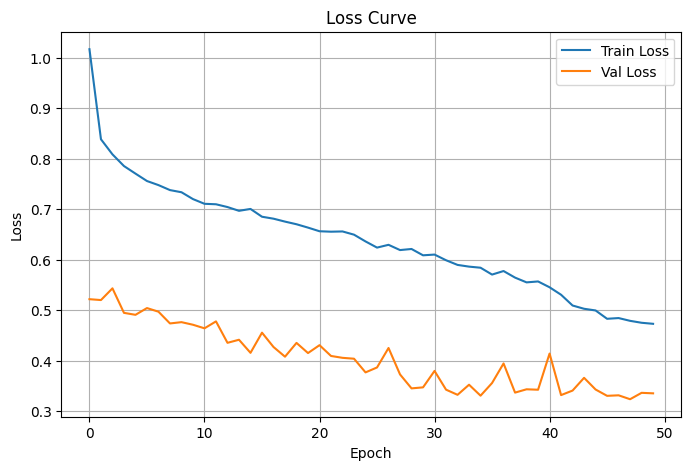

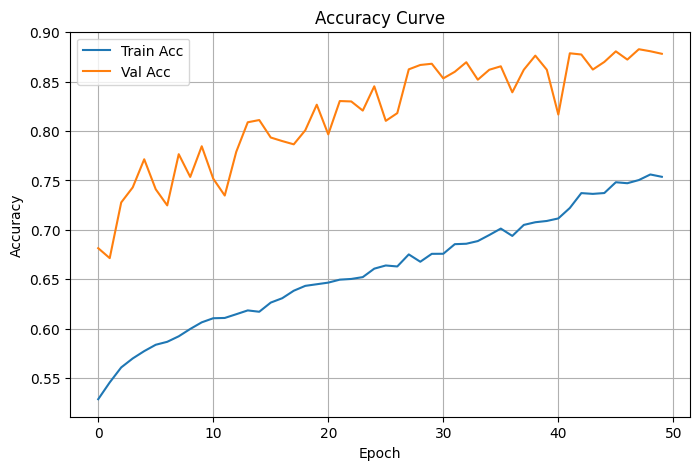

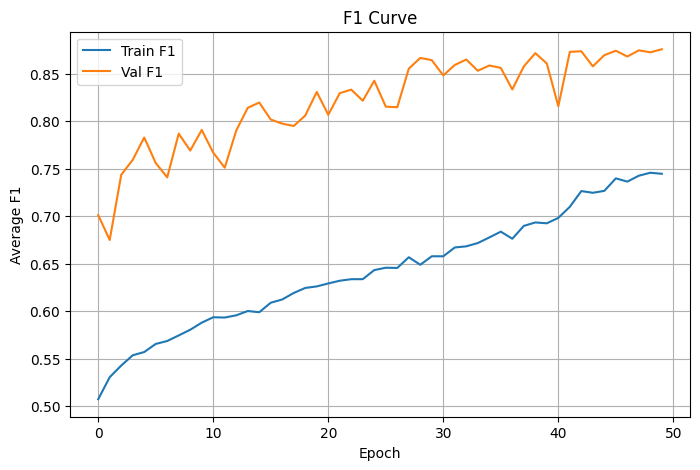


=== Final Evaluation Results ===
Accuracy     : 0.8774
Macro F1     : 0.8736
Micro F1     : 0.8774
Weighted F1  : 0.8774
Cohen's Kappa: 0.7989

Per-class F1 scores:
  Class 0: 0.8841
  Class 1: 0.8614
  Class 2: 0.8754

Confusion Matrix:
[[792290  26802  51942]
 [ 18599 235798   6378]
 [110484  24098 677325]]
Saved results to results/deterministic_CNN_data_margin_results.json

=== Run 10/13 — true_BCNN_data_bald ===
X:  (14000, 28, 6)
y:  (14000,)
Before Normalisation

Global Mean: 0.0756
Global Std Dev: 1.0375

Per-Band Statistics:
  Band     Mean      Std
Band 1 0.057450 1.061084
Band 2 0.049096 1.058673
Band 3 0.051764 1.053436
Band 4 0.090298 0.999224
Band 5 0.112809 1.005269
Band 6 0.092298 1.043668

Class Distribution:
 Class  Count  Percentage
     0   5593       39.95
     1   1435       10.25
     2   6972       49.80


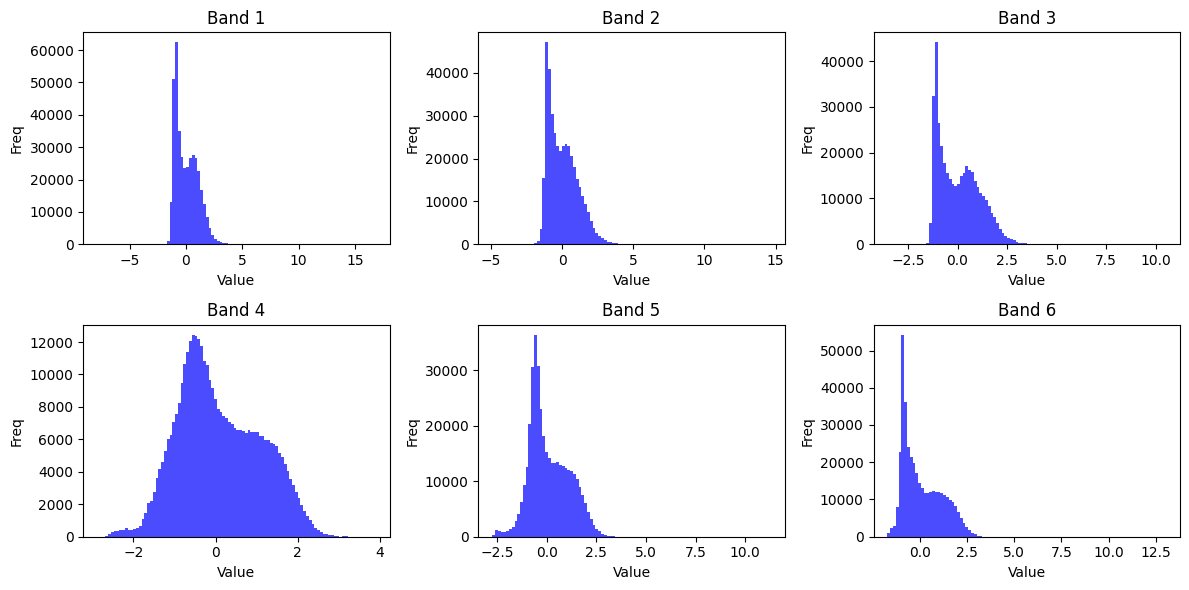

After Normalisation

Global Mean: -0.0000
Global Std Dev: 1.0000

Per-Band Statistics:
  Band          Mean      Std
Band 1 -1.868333e-06 1.000012
Band 2 -3.851746e-07 1.000016
Band 3 -2.772547e-07 1.000018
Band 4  6.393018e-07 1.000002
Band 5 -1.467830e-06 0.999993
Band 6  4.019105e-07 1.000001

Class Distribution:
 Class  Count  Percentage
     0   5593       39.95
     1   1435       10.25
     2   6972       49.80


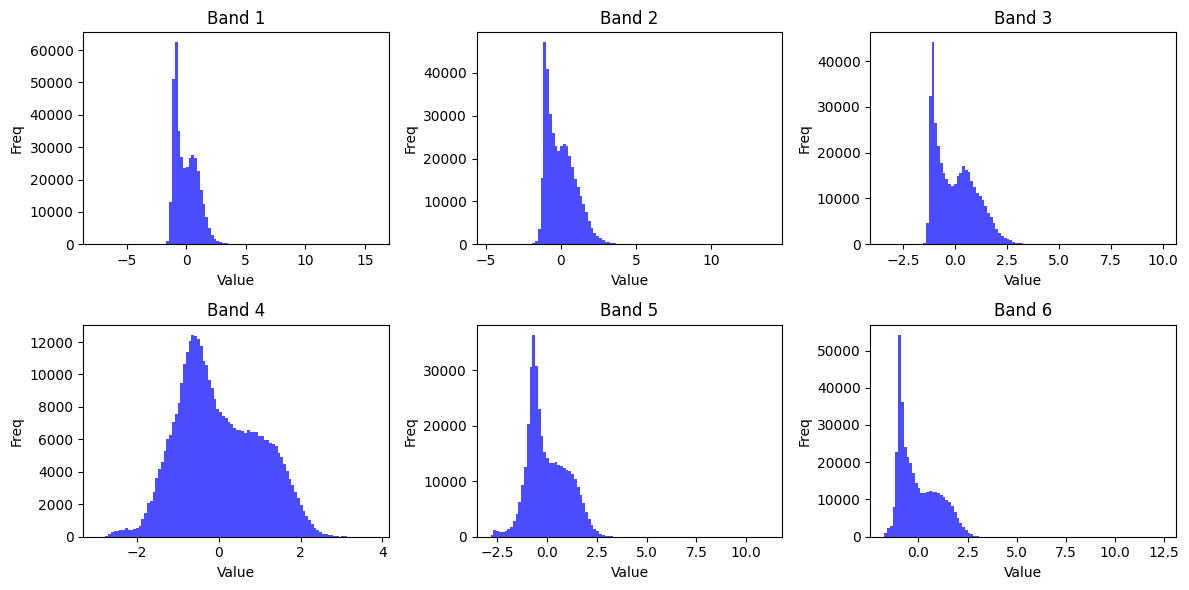

Class Weights: tensor([0.8344, 3.2520, 0.6693], device='cuda:0')



Epoch 1/50
Train — Loss: 0.8345 | Acc: 0.6179 | Avg F1: 0.6088
Val   — Loss: 0.3673 | Acc: 0.8305 | Avg F1: 0.8272



Epoch 2/50
Train — Loss: 0.6305 | Acc: 0.6839 | Avg F1: 0.6716
Val   — Loss: 0.3863 | Acc: 0.8239 | Avg F1: 0.8296



Epoch 3/50
Train — Loss: 0.5881 | Acc: 0.7069 | Avg F1: 0.6925
Val   — Loss: 0.4016 | Acc: 0.8047 | Avg F1: 0.8034



Epoch 4/50
Train — Loss: 0.5540 | Acc: 0.7282 | Avg F1: 0.7124
Val   — Loss: 0.3543 | Acc: 0.8438 | Avg F1: 0.8435



Epoch 5/50
Train — Loss: 0.5361 | Acc: 0.7319 | Avg F1: 0.7140
Val   — Loss: 0.3139 | Acc: 0.8535 | Avg F1: 0.8508



Epoch 6/50
Train — Loss: 0.5151 | Acc: 0.7452 | Avg F1: 0.7256
Val   — Loss: 0.2969 | Acc: 0.8682 | Avg F1: 0.8646



Epoch 7/50
Train — Loss: 0.5012 | Acc: 0.7510 | Avg F1: 0.7329
Val   — Loss: 0.3055 | Acc: 0.8626 | Avg F1: 0.8596



Epoch 8/50
Train — Loss: 0.4876 | Acc: 0.7610 | Avg F1: 0.7410
Val   — Loss: 0.2860 | Acc: 0.8687 | Avg F1: 0.8646



Epoch 9/50
Train — Loss: 0.4790 | Acc: 0.7675 | Avg F1: 0.7492
Val   — Loss: 0.2717 | Acc: 0.8797 | Avg F1: 0.8753



Epoch 10/50
Train — Loss: 0.4667 | Acc: 0.7742 | Avg F1: 0.7536
Val   — Loss: 0.2762 | Acc: 0.8710 | Avg F1: 0.8620



Epoch 11/50
Train — Loss: 0.4567 | Acc: 0.7751 | Avg F1: 0.7576
Val   — Loss: 0.2638 | Acc: 0.8817 | Avg F1: 0.8772



Epoch 12/50
Train — Loss: 0.4513 | Acc: 0.7820 | Avg F1: 0.7612
Val   — Loss: 0.2593 | Acc: 0.8748 | Avg F1: 0.8658



Epoch 13/50
Train — Loss: 0.4358 | Acc: 0.7884 | Avg F1: 0.7705
Val   — Loss: 0.2634 | Acc: 0.8816 | Avg F1: 0.8749



Epoch 14/50
Train — Loss: 0.4382 | Acc: 0.7904 | Avg F1: 0.7704
Val   — Loss: 0.2597 | Acc: 0.8803 | Avg F1: 0.8723



Epoch 15/50
Train — Loss: 0.4267 | Acc: 0.7923 | Avg F1: 0.7745
Val   — Loss: 0.2919 | Acc: 0.8738 | Avg F1: 0.8707



Epoch 16/50
Train — Loss: 0.4256 | Acc: 0.7973 | Avg F1: 0.7789
Val   — Loss: 0.2756 | Acc: 0.8789 | Avg F1: 0.8733



Epoch 17/50
Train — Loss: 0.4196 | Acc: 0.8011 | Avg F1: 0.7827
Val   — Loss: 0.2612 | Acc: 0.8811 | Avg F1: 0.8744



Epoch 18/50
Train — Loss: 0.4111 | Acc: 0.8021 | Avg F1: 0.7847
Val   — Loss: 0.2541 | Acc: 0.8862 | Avg F1: 0.8822



Epoch 19/50
Train — Loss: 0.4079 | Acc: 0.8039 | Avg F1: 0.7858
Val   — Loss: 0.2552 | Acc: 0.8782 | Avg F1: 0.8676



Epoch 20/50
Train — Loss: 0.4045 | Acc: 0.8037 | Avg F1: 0.7852
Val   — Loss: 0.2692 | Acc: 0.8806 | Avg F1: 0.8749



Epoch 21/50
Train — Loss: 0.4001 | Acc: 0.8100 | Avg F1: 0.7920
Val   — Loss: 0.2720 | Acc: 0.8761 | Avg F1: 0.8688



Epoch 22/50
Train — Loss: 0.3893 | Acc: 0.8146 | Avg F1: 0.7962
Val   — Loss: 0.2575 | Acc: 0.8848 | Avg F1: 0.8793



Epoch 23/50
Train — Loss: 0.3868 | Acc: 0.8160 | Avg F1: 0.7999
Val   — Loss: 0.2729 | Acc: 0.8832 | Avg F1: 0.8801



Epoch 24/50
Train — Loss: 0.3794 | Acc: 0.8161 | Avg F1: 0.7975
Val   — Loss: 0.2600 | Acc: 0.8788 | Avg F1: 0.8694



Epoch 25/50
Train — Loss: 0.3461 | Acc: 0.8337 | Avg F1: 0.8175
Val   — Loss: 0.2583 | Acc: 0.8894 | Avg F1: 0.8848



Epoch 26/50
Train — Loss: 0.3322 | Acc: 0.8359 | Avg F1: 0.8193
Val   — Loss: 0.2589 | Acc: 0.8883 | Avg F1: 0.8832



Epoch 27/50
Train — Loss: 0.3296 | Acc: 0.8399 | Avg F1: 0.8252
Val   — Loss: 0.2600 | Acc: 0.8934 | Avg F1: 0.8895



Epoch 28/50
Train — Loss: 0.3232 | Acc: 0.8440 | Avg F1: 0.8315
Val   — Loss: 0.2640 | Acc: 0.8925 | Avg F1: 0.8898



Epoch 29/50
Train — Loss: 0.3233 | Acc: 0.8453 | Avg F1: 0.8315
Val   — Loss: 0.2649 | Acc: 0.8961 | Avg F1: 0.8958



Epoch 30/50
Train — Loss: 0.3172 | Acc: 0.8490 | Avg F1: 0.8358
Val   — Loss: 0.2682 | Acc: 0.8925 | Avg F1: 0.8913



Epoch 31/50
Train — Loss: 0.2954 | Acc: 0.8561 | Avg F1: 0.8451
Val   — Loss: 0.2598 | Acc: 0.8981 | Avg F1: 0.8959



Epoch 32/50
Train — Loss: 0.2906 | Acc: 0.8604 | Avg F1: 0.8484
Val   — Loss: 0.2640 | Acc: 0.8976 | Avg F1: 0.8956



Epoch 33/50
Train — Loss: 0.2838 | Acc: 0.8624 | Avg F1: 0.8519
Val   — Loss: 0.2700 | Acc: 0.8968 | Avg F1: 0.8954



Epoch 34/50
Train — Loss: 0.2769 | Acc: 0.8676 | Avg F1: 0.8577
Val   — Loss: 0.2754 | Acc: 0.8976 | Avg F1: 0.8967



Epoch 35/50
Train — Loss: 0.2762 | Acc: 0.8647 | Avg F1: 0.8573
Val   — Loss: 0.2791 | Acc: 0.8988 | Avg F1: 0.8968



Epoch 36/50
Train — Loss: 0.2757 | Acc: 0.8697 | Avg F1: 0.8618
Val   — Loss: 0.2810 | Acc: 0.9005 | Avg F1: 0.8996



Epoch 37/50
Train — Loss: 0.2649 | Acc: 0.8731 | Avg F1: 0.8650
Val   — Loss: 0.2740 | Acc: 0.9000 | Avg F1: 0.8986



Epoch 38/50
Train — Loss: 0.2583 | Acc: 0.8774 | Avg F1: 0.8701
Val   — Loss: 0.2826 | Acc: 0.8994 | Avg F1: 0.8980



Epoch 39/50
Train — Loss: 0.2581 | Acc: 0.8752 | Avg F1: 0.8682
Val   — Loss: 0.2787 | Acc: 0.9004 | Avg F1: 0.8991



Epoch 40/50
Train — Loss: 0.2502 | Acc: 0.8781 | Avg F1: 0.8733
Val   — Loss: 0.2830 | Acc: 0.9011 | Avg F1: 0.9003



Epoch 41/50
Train — Loss: 0.2538 | Acc: 0.8781 | Avg F1: 0.8715
Val   — Loss: 0.2841 | Acc: 0.8994 | Avg F1: 0.8974



Epoch 42/50
Train — Loss: 0.2516 | Acc: 0.8787 | Avg F1: 0.8737
Val   — Loss: 0.2824 | Acc: 0.8990 | Avg F1: 0.8967



Epoch 43/50
Train — Loss: 0.2447 | Acc: 0.8799 | Avg F1: 0.8748
Val   — Loss: 0.2845 | Acc: 0.9002 | Avg F1: 0.8985



Epoch 44/50
Train — Loss: 0.2444 | Acc: 0.8787 | Avg F1: 0.8746
Val   — Loss: 0.2875 | Acc: 0.9003 | Avg F1: 0.8989



Epoch 45/50
Train — Loss: 0.2382 | Acc: 0.8863 | Avg F1: 0.8811
Val   — Loss: 0.2901 | Acc: 0.9009 | Avg F1: 0.8993



Epoch 46/50
Train — Loss: 0.2426 | Acc: 0.8828 | Avg F1: 0.8765
Val   — Loss: 0.2894 | Acc: 0.9017 | Avg F1: 0.9003



Epoch 47/50
Train — Loss: 0.2424 | Acc: 0.8833 | Avg F1: 0.8769
Val   — Loss: 0.2925 | Acc: 0.9031 | Avg F1: 0.9028



Epoch 48/50
Train — Loss: 0.2407 | Acc: 0.8835 | Avg F1: 0.8790
Val   — Loss: 0.2906 | Acc: 0.9025 | Avg F1: 0.9010



Epoch 49/50
Train — Loss: 0.2338 | Acc: 0.8879 | Avg F1: 0.8816
Val   — Loss: 0.2966 | Acc: 0.9030 | Avg F1: 0.9027



Epoch 50/50
Train — Loss: 0.2323 | Acc: 0.8901 | Avg F1: 0.8855
Val   — Loss: 0.2966 | Acc: 0.9017 | Avg F1: 0.9008


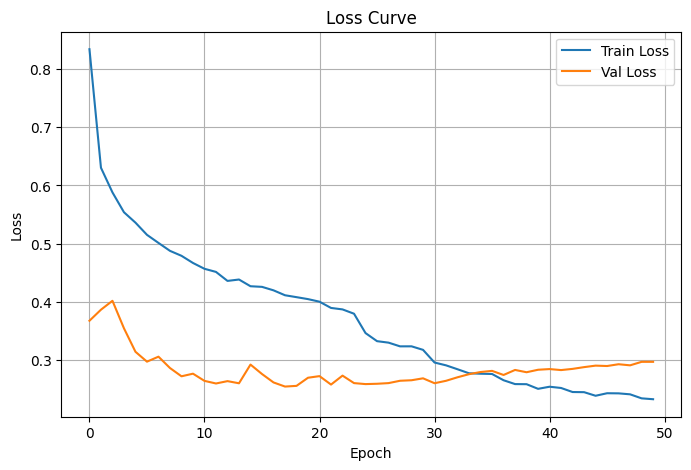

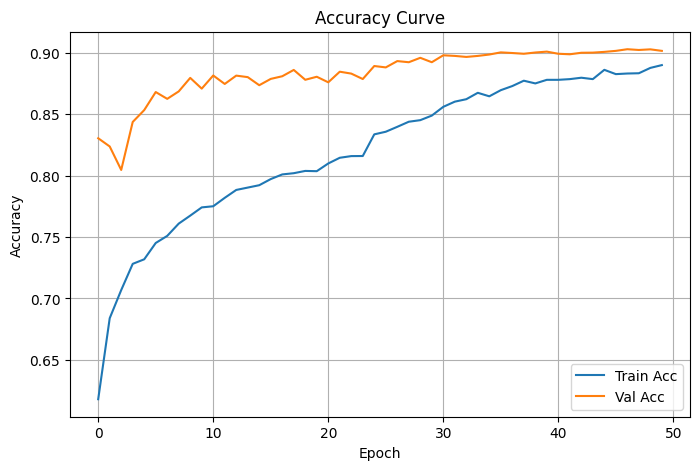

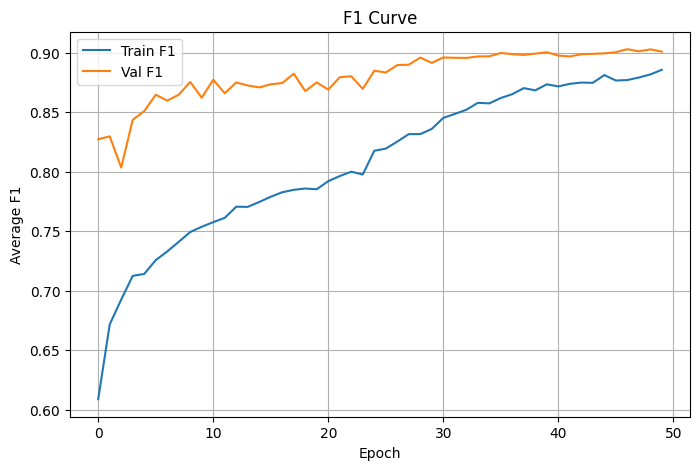


=== Final Evaluation Results ===
Accuracy     : 0.9030
Macro F1     : 0.9036
Micro F1     : 0.9030
Weighted F1  : 0.9030
Cohen's Kappa: 0.8406

Per-class F1 scores:
  Class 0: 0.9042
  Class 1: 0.9060
  Class 2: 0.9007

Confusion Matrix:
[[791818  19960  59256]
 [  9746 242737   8292]
 [ 78910  12383 720614]]
Saved results to results/true_BCNN_data_bald_results.json

=== Run 11/13 — true_BCNN_data_bvsb ===
X:  (14000, 28, 6)
y:  (14000,)
Before Normalisation

Global Mean: -0.0016
Global Std Dev: 0.8869

Per-Band Statistics:
  Band      Mean      Std
Band 1 -0.000225 0.920863
Band 2  0.038107 0.901695
Band 3  0.016473 0.893230
Band 4 -0.075563 0.832991
Band 5  0.013934 0.885609
Band 6 -0.002462 0.880047

Class Distribution:
 Class  Count  Percentage
     0   6262   44.728571
     1   1620   11.571429
     2   6118   43.700000


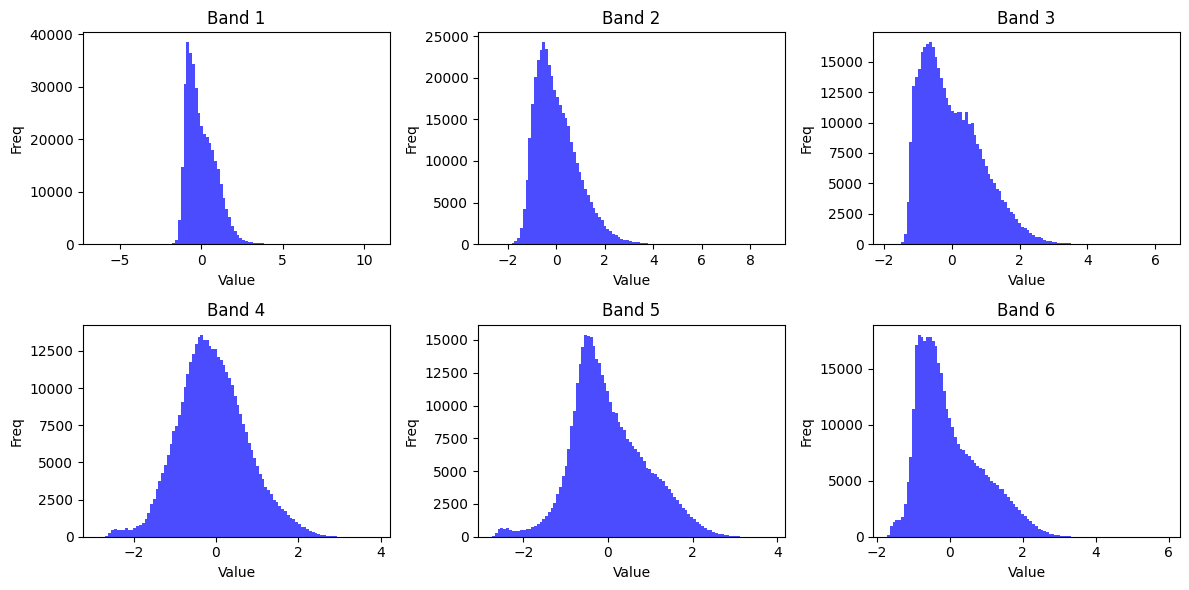

After Normalisation

Global Mean: 0.0000
Global Std Dev: 1.0001

Per-Band Statistics:
  Band          Mean      Std
Band 1 -1.580498e-07 1.000011
Band 2 -5.388146e-08 1.000012
Band 3  1.599433e-07 1.000003
Band 4  3.409509e-07 0.999996
Band 5  8.020772e-07 0.999983
Band 6  1.977092e-07 1.000012

Class Distribution:
 Class  Count  Percentage
     0   6262   44.728571
     1   1620   11.571429
     2   6118   43.700000


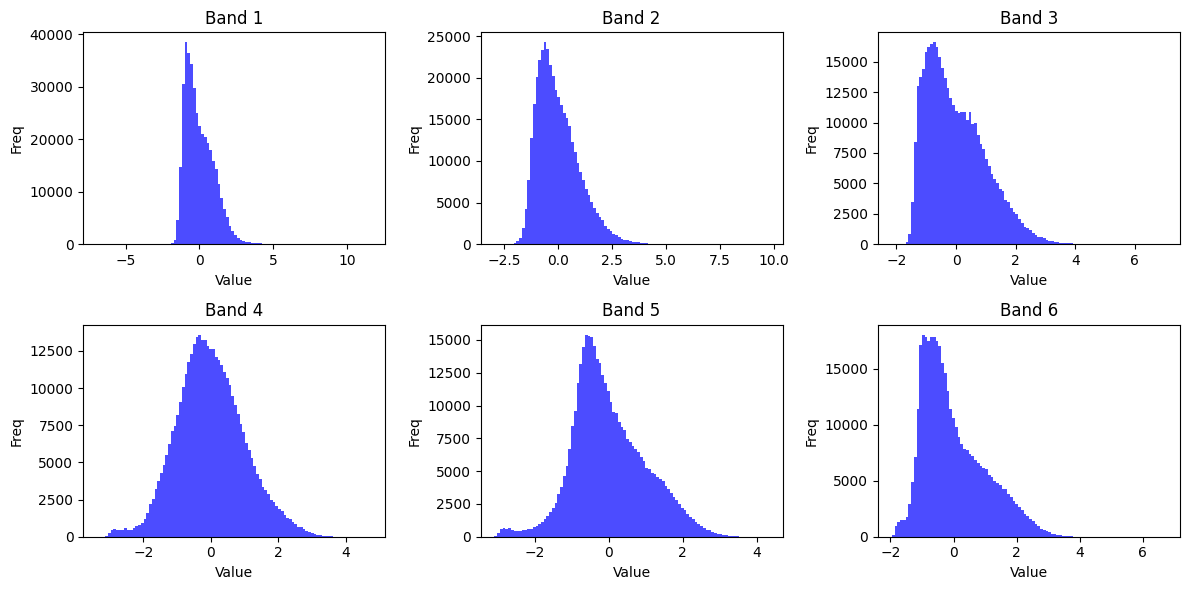

Class Weights: tensor([0.7452, 2.8807, 0.7628], device='cuda:0')



Epoch 1/50
Train — Loss: 0.9955 | Acc: 0.5251 | Avg F1: 0.5213
Val   — Loss: 0.4433 | Acc: 0.7433 | Avg F1: 0.7646



Epoch 2/50
Train — Loss: 0.8093 | Acc: 0.5551 | Avg F1: 0.5537
Val   — Loss: 0.4238 | Acc: 0.7368 | Avg F1: 0.7434



Epoch 3/50
Train — Loss: 0.7804 | Acc: 0.5734 | Avg F1: 0.5704
Val   — Loss: 0.3622 | Acc: 0.8129 | Avg F1: 0.8178



Epoch 4/50
Train — Loss: 0.7557 | Acc: 0.5834 | Avg F1: 0.5796
Val   — Loss: 0.3570 | Acc: 0.8045 | Avg F1: 0.8137



Epoch 5/50
Train — Loss: 0.7454 | Acc: 0.5913 | Avg F1: 0.5871
Val   — Loss: 0.3856 | Acc: 0.7721 | Avg F1: 0.7856



Epoch 6/50
Train — Loss: 0.7358 | Acc: 0.5939 | Avg F1: 0.5898
Val   — Loss: 0.3714 | Acc: 0.7894 | Avg F1: 0.8006



Epoch 7/50
Train — Loss: 0.7166 | Acc: 0.6000 | Avg F1: 0.5963
Val   — Loss: 0.3447 | Acc: 0.8114 | Avg F1: 0.8175



Epoch 8/50
Train — Loss: 0.7160 | Acc: 0.6064 | Avg F1: 0.6016
Val   — Loss: 0.3507 | Acc: 0.8028 | Avg F1: 0.8134



Epoch 9/50
Train — Loss: 0.7092 | Acc: 0.6083 | Avg F1: 0.6035
Val   — Loss: 0.3478 | Acc: 0.8036 | Avg F1: 0.8127



Epoch 10/50
Train — Loss: 0.7028 | Acc: 0.6136 | Avg F1: 0.6090
Val   — Loss: 0.3628 | Acc: 0.7820 | Avg F1: 0.7953



Epoch 11/50
Train — Loss: 0.6971 | Acc: 0.6169 | Avg F1: 0.6103
Val   — Loss: 0.3546 | Acc: 0.7926 | Avg F1: 0.8038



Epoch 12/50
Train — Loss: 0.6974 | Acc: 0.6131 | Avg F1: 0.6070
Val   — Loss: 0.3598 | Acc: 0.7874 | Avg F1: 0.7992



Epoch 13/50
Train — Loss: 0.6882 | Acc: 0.6158 | Avg F1: 0.6111
Val   — Loss: 0.3489 | Acc: 0.7923 | Avg F1: 0.8013



Epoch 14/50
Train — Loss: 0.6695 | Acc: 0.6315 | Avg F1: 0.6259
Val   — Loss: 0.2967 | Acc: 0.8747 | Avg F1: 0.8687



Epoch 15/50
Train — Loss: 0.6571 | Acc: 0.6395 | Avg F1: 0.6333
Val   — Loss: 0.2894 | Acc: 0.8784 | Avg F1: 0.8724



Epoch 16/50
Train — Loss: 0.6554 | Acc: 0.6386 | Avg F1: 0.6334
Val   — Loss: 0.2931 | Acc: 0.8692 | Avg F1: 0.8656



Epoch 17/50
Train — Loss: 0.6503 | Acc: 0.6404 | Avg F1: 0.6340
Val   — Loss: 0.2903 | Acc: 0.8779 | Avg F1: 0.8733



Epoch 18/50
Train — Loss: 0.6503 | Acc: 0.6374 | Avg F1: 0.6330
Val   — Loss: 0.2959 | Acc: 0.8670 | Avg F1: 0.8655



Epoch 19/50
Train — Loss: 0.6452 | Acc: 0.6435 | Avg F1: 0.6387
Val   — Loss: 0.2868 | Acc: 0.8732 | Avg F1: 0.8703



Epoch 20/50
Train — Loss: 0.6390 | Acc: 0.6429 | Avg F1: 0.6375
Val   — Loss: 0.2905 | Acc: 0.8746 | Avg F1: 0.8699



Epoch 21/50
Train — Loss: 0.6348 | Acc: 0.6446 | Avg F1: 0.6392
Val   — Loss: 0.2899 | Acc: 0.8728 | Avg F1: 0.8665



Epoch 22/50
Train — Loss: 0.6338 | Acc: 0.6477 | Avg F1: 0.6432
Val   — Loss: 0.2785 | Acc: 0.8809 | Avg F1: 0.8754



Epoch 23/50
Train — Loss: 0.6296 | Acc: 0.6483 | Avg F1: 0.6435
Val   — Loss: 0.2792 | Acc: 0.8777 | Avg F1: 0.8713



Epoch 24/50
Train — Loss: 0.6189 | Acc: 0.6535 | Avg F1: 0.6493
Val   — Loss: 0.2796 | Acc: 0.8734 | Avg F1: 0.8684



Epoch 25/50
Train — Loss: 0.6155 | Acc: 0.6584 | Avg F1: 0.6541
Val   — Loss: 0.2751 | Acc: 0.8776 | Avg F1: 0.8728



Epoch 26/50
Train — Loss: 0.6086 | Acc: 0.6636 | Avg F1: 0.6589
Val   — Loss: 0.2744 | Acc: 0.8857 | Avg F1: 0.8777



Epoch 27/50
Train — Loss: 0.6127 | Acc: 0.6596 | Avg F1: 0.6574
Val   — Loss: 0.2754 | Acc: 0.8834 | Avg F1: 0.8766



Epoch 28/50
Train — Loss: 0.6080 | Acc: 0.6622 | Avg F1: 0.6583
Val   — Loss: 0.2699 | Acc: 0.8787 | Avg F1: 0.8747



Epoch 29/50
Train — Loss: 0.6038 | Acc: 0.6613 | Avg F1: 0.6573
Val   — Loss: 0.2751 | Acc: 0.8810 | Avg F1: 0.8734



Epoch 30/50
Train — Loss: 0.6018 | Acc: 0.6648 | Avg F1: 0.6596
Val   — Loss: 0.2695 | Acc: 0.8837 | Avg F1: 0.8787



Epoch 31/50
Train — Loss: 0.5887 | Acc: 0.6759 | Avg F1: 0.6706
Val   — Loss: 0.2727 | Acc: 0.8810 | Avg F1: 0.8748



Epoch 32/50
Train — Loss: 0.5872 | Acc: 0.6734 | Avg F1: 0.6706
Val   — Loss: 0.2701 | Acc: 0.8820 | Avg F1: 0.8752



Epoch 33/50
Train — Loss: 0.5813 | Acc: 0.6769 | Avg F1: 0.6720
Val   — Loss: 0.2628 | Acc: 0.8832 | Avg F1: 0.8777



Epoch 34/50
Train — Loss: 0.5765 | Acc: 0.6811 | Avg F1: 0.6772
Val   — Loss: 0.2699 | Acc: 0.8832 | Avg F1: 0.8761



Epoch 35/50
Train — Loss: 0.5760 | Acc: 0.6833 | Avg F1: 0.6794
Val   — Loss: 0.2636 | Acc: 0.8875 | Avg F1: 0.8821



Epoch 36/50
Train — Loss: 0.5617 | Acc: 0.6934 | Avg F1: 0.6904
Val   — Loss: 0.2653 | Acc: 0.8841 | Avg F1: 0.8798



Epoch 37/50
Train — Loss: 0.5613 | Acc: 0.6899 | Avg F1: 0.6877
Val   — Loss: 0.2650 | Acc: 0.8897 | Avg F1: 0.8842



Epoch 38/50
Train — Loss: 0.5575 | Acc: 0.6924 | Avg F1: 0.6907
Val   — Loss: 0.2748 | Acc: 0.8816 | Avg F1: 0.8770



Epoch 39/50
Train — Loss: 0.5519 | Acc: 0.6915 | Avg F1: 0.6899
Val   — Loss: 0.2656 | Acc: 0.8883 | Avg F1: 0.8818



Epoch 40/50
Train — Loss: 0.5278 | Acc: 0.7051 | Avg F1: 0.7043
Val   — Loss: 0.2671 | Acc: 0.8941 | Avg F1: 0.8882



Epoch 41/50
Train — Loss: 0.5221 | Acc: 0.7143 | Avg F1: 0.7138
Val   — Loss: 0.2670 | Acc: 0.8922 | Avg F1: 0.8876



Epoch 42/50
Train — Loss: 0.5222 | Acc: 0.7126 | Avg F1: 0.7122
Val   — Loss: 0.2651 | Acc: 0.8955 | Avg F1: 0.8897



Epoch 43/50
Train — Loss: 0.5135 | Acc: 0.7146 | Avg F1: 0.7130
Val   — Loss: 0.2735 | Acc: 0.8941 | Avg F1: 0.8912



Epoch 44/50
Train — Loss: 0.5074 | Acc: 0.7228 | Avg F1: 0.7218
Val   — Loss: 0.2674 | Acc: 0.8958 | Avg F1: 0.8911



Epoch 45/50
Train — Loss: 0.5049 | Acc: 0.7181 | Avg F1: 0.7185
Val   — Loss: 0.2659 | Acc: 0.8960 | Avg F1: 0.8920



Epoch 46/50
Train — Loss: 0.4921 | Acc: 0.7278 | Avg F1: 0.7286
Val   — Loss: 0.2677 | Acc: 0.8991 | Avg F1: 0.8965



Epoch 47/50
Train — Loss: 0.4841 | Acc: 0.7309 | Avg F1: 0.7336
Val   — Loss: 0.2703 | Acc: 0.8990 | Avg F1: 0.8962



Epoch 48/50
Train — Loss: 0.4811 | Acc: 0.7363 | Avg F1: 0.7376
Val   — Loss: 0.2743 | Acc: 0.9015 | Avg F1: 0.8996



Epoch 49/50
Train — Loss: 0.4797 | Acc: 0.7369 | Avg F1: 0.7394
Val   — Loss: 0.2774 | Acc: 0.8974 | Avg F1: 0.8954



Epoch 50/50
Train — Loss: 0.4746 | Acc: 0.7382 | Avg F1: 0.7410
Val   — Loss: 0.2776 | Acc: 0.8992 | Avg F1: 0.8975


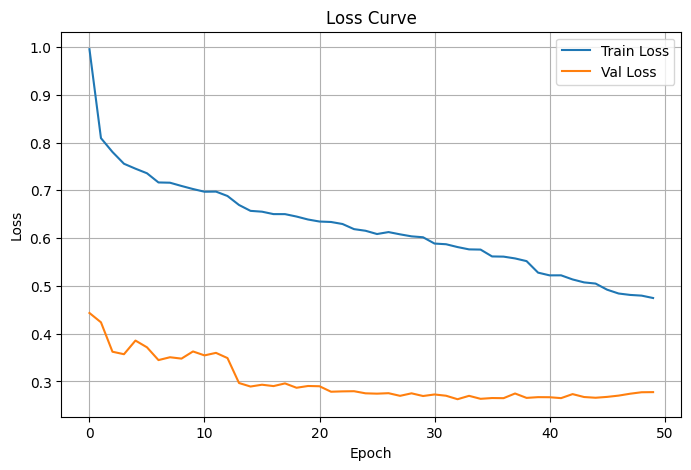

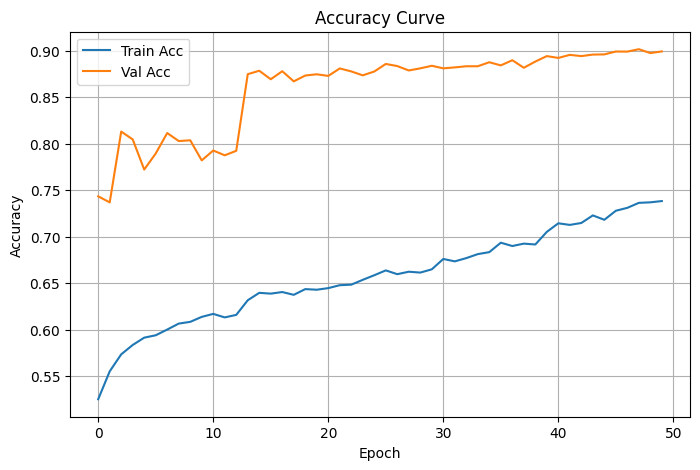

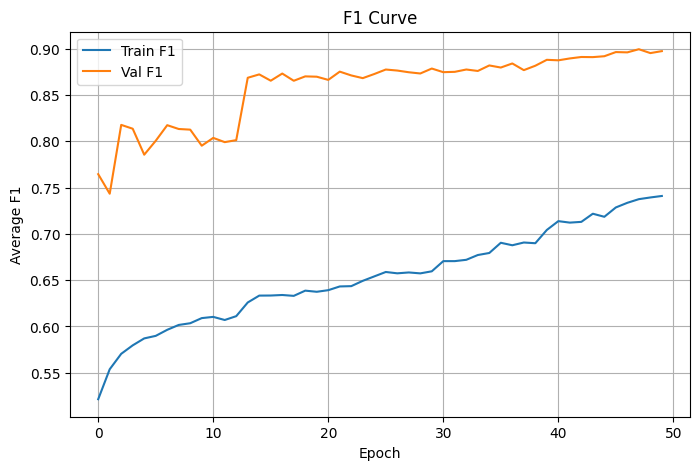


=== Final Evaluation Results ===
Accuracy     : 0.8991
Macro F1     : 0.8978
Micro F1     : 0.8991
Weighted F1  : 0.8991
Cohen's Kappa: 0.8347

Per-class F1 scores:
  Class 0: 0.9022
  Class 1: 0.8937
  Class 2: 0.8975

Confusion Matrix:
[[786976  24494  59564]
 [  8061 244591   8123]
 [ 78445  17486 715976]]
Saved results to results/true_BCNN_data_bvsb_results.json

=== Run 12/13 — true_BCNN_data_predictive_entropy ===
X:  (14000, 28, 6)
y:  (14000,)
Before Normalisation

Global Mean: -0.1222
Global Std Dev: 0.8020

Per-Band Statistics:
  Band      Mean      Std
Band 1 -0.146249 0.847695
Band 2 -0.101459 0.809910
Band 3 -0.127461 0.803390
Band 4 -0.099130 0.771183
Band 5 -0.117051 0.791427
Band 6 -0.141699 0.784960

Class Distribution:
 Class  Count  Percentage
     0   5702   40.728571
     1   2487   17.764286
     2   5811   41.507143


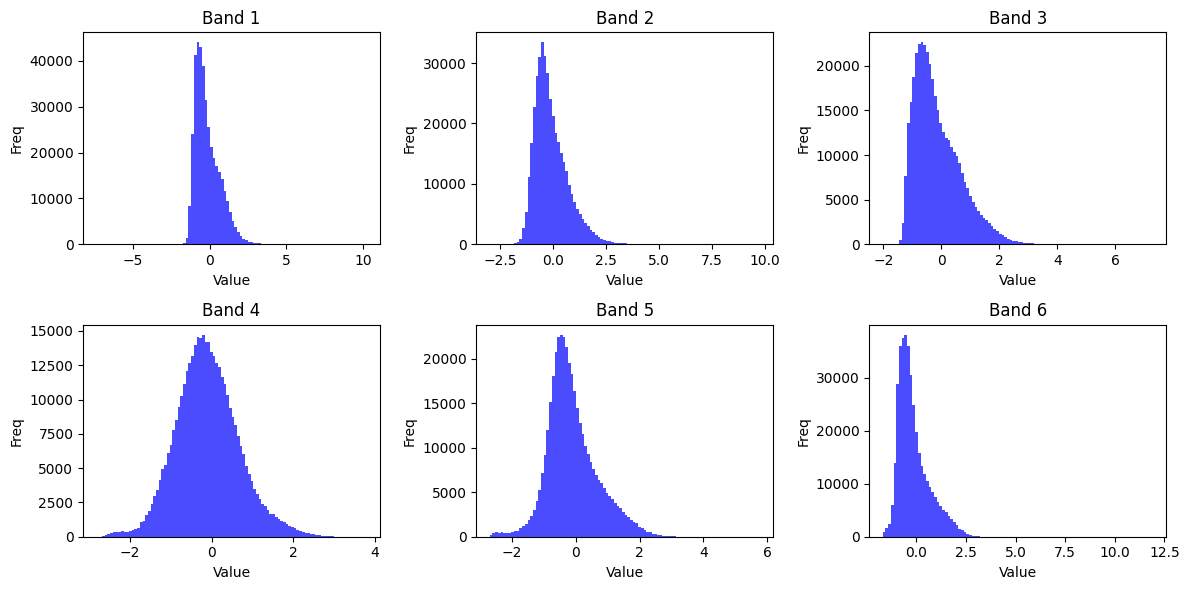

After Normalisation

Global Mean: -0.0000
Global Std Dev: 1.0001

Per-Band Statistics:
  Band          Mean      Std
Band 1 -5.051988e-06 0.999989
Band 2  8.225688e-07 0.999993
Band 3  6.115193e-08 1.000000
Band 4 -1.596623e-06 0.999994
Band 5 -1.948917e-06 0.999987
Band 6 -5.539047e-07 0.999963

Class Distribution:
 Class  Count  Percentage
     0   5702   40.728571
     1   2487   17.764286
     2   5811   41.507143


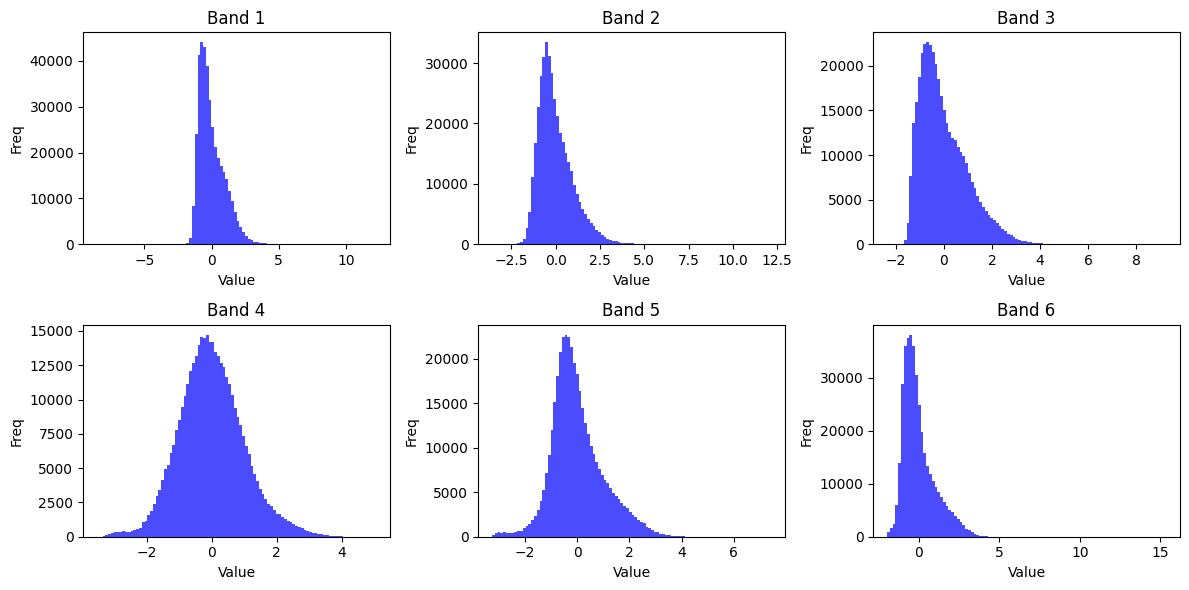

Class Weights: tensor([0.8184, 1.8764, 0.8031], device='cuda:0')



Epoch 1/50
Train — Loss: 1.1700 | Acc: 0.4829 | Avg F1: 0.4748
Val   — Loss: 0.6130 | Acc: 0.7136 | Avg F1: 0.7391



Epoch 2/50
Train — Loss: 0.9554 | Acc: 0.5246 | Avg F1: 0.5147
Val   — Loss: 0.5119 | Acc: 0.7758 | Avg F1: 0.7889



Epoch 3/50
Train — Loss: 0.9083 | Acc: 0.5373 | Avg F1: 0.5276
Val   — Loss: 0.4872 | Acc: 0.7911 | Avg F1: 0.8028



Epoch 4/50
Train — Loss: 0.8881 | Acc: 0.5497 | Avg F1: 0.5403
Val   — Loss: 0.4209 | Acc: 0.8390 | Avg F1: 0.8442



Epoch 5/50
Train — Loss: 0.8645 | Acc: 0.5679 | Avg F1: 0.5581
Val   — Loss: 0.4299 | Acc: 0.8039 | Avg F1: 0.8149



Epoch 6/50
Train — Loss: 0.8578 | Acc: 0.5671 | Avg F1: 0.5572
Val   — Loss: 0.3850 | Acc: 0.8400 | Avg F1: 0.8455



Epoch 7/50
Train — Loss: 0.8463 | Acc: 0.5743 | Avg F1: 0.5644
Val   — Loss: 0.3899 | Acc: 0.8393 | Avg F1: 0.8450



Epoch 8/50
Train — Loss: 0.8360 | Acc: 0.5843 | Avg F1: 0.5736
Val   — Loss: 0.3724 | Acc: 0.8355 | Avg F1: 0.8436



Epoch 9/50
Train — Loss: 0.8353 | Acc: 0.5803 | Avg F1: 0.5706
Val   — Loss: 0.3799 | Acc: 0.8436 | Avg F1: 0.8503



Epoch 10/50
Train — Loss: 0.8261 | Acc: 0.5854 | Avg F1: 0.5748
Val   — Loss: 0.3559 | Acc: 0.8579 | Avg F1: 0.8596



Epoch 11/50
Train — Loss: 0.8226 | Acc: 0.5916 | Avg F1: 0.5810
Val   — Loss: 0.3510 | Acc: 0.8608 | Avg F1: 0.8632



Epoch 12/50
Train — Loss: 0.8131 | Acc: 0.5946 | Avg F1: 0.5841
Val   — Loss: 0.3275 | Acc: 0.8600 | Avg F1: 0.8613



Epoch 13/50
Train — Loss: 0.8111 | Acc: 0.5946 | Avg F1: 0.5841
Val   — Loss: 0.3385 | Acc: 0.8615 | Avg F1: 0.8642



Epoch 14/50
Train — Loss: 0.8087 | Acc: 0.5955 | Avg F1: 0.5860
Val   — Loss: 0.3771 | Acc: 0.8456 | Avg F1: 0.8486



Epoch 15/50
Train — Loss: 0.8019 | Acc: 0.5993 | Avg F1: 0.5898
Val   — Loss: 0.3275 | Acc: 0.8651 | Avg F1: 0.8650



Epoch 16/50
Train — Loss: 0.7972 | Acc: 0.6067 | Avg F1: 0.5963
Val   — Loss: 0.3402 | Acc: 0.8597 | Avg F1: 0.8596



Epoch 17/50
Train — Loss: 0.7924 | Acc: 0.6034 | Avg F1: 0.5928
Val   — Loss: 0.3211 | Acc: 0.8636 | Avg F1: 0.8651



Epoch 18/50
Train — Loss: 0.7900 | Acc: 0.6098 | Avg F1: 0.6000
Val   — Loss: 0.3438 | Acc: 0.8511 | Avg F1: 0.8561



Epoch 19/50
Train — Loss: 0.7816 | Acc: 0.6149 | Avg F1: 0.6049
Val   — Loss: 0.3331 | Acc: 0.8548 | Avg F1: 0.8600



Epoch 20/50
Train — Loss: 0.7792 | Acc: 0.6168 | Avg F1: 0.6071
Val   — Loss: 0.3096 | Acc: 0.8715 | Avg F1: 0.8720



Epoch 21/50
Train — Loss: 0.7754 | Acc: 0.6141 | Avg F1: 0.6049
Val   — Loss: 0.3272 | Acc: 0.8592 | Avg F1: 0.8625



Epoch 22/50
Train — Loss: 0.7658 | Acc: 0.6241 | Avg F1: 0.6147
Val   — Loss: 0.3099 | Acc: 0.8682 | Avg F1: 0.8690



Epoch 23/50
Train — Loss: 0.7635 | Acc: 0.6226 | Avg F1: 0.6138
Val   — Loss: 0.3513 | Acc: 0.8518 | Avg F1: 0.8560



Epoch 24/50
Train — Loss: 0.7586 | Acc: 0.6289 | Avg F1: 0.6204
Val   — Loss: 0.3048 | Acc: 0.8717 | Avg F1: 0.8724



Epoch 25/50
Train — Loss: 0.7529 | Acc: 0.6331 | Avg F1: 0.6237
Val   — Loss: 0.3116 | Acc: 0.8696 | Avg F1: 0.8714



Epoch 26/50
Train — Loss: 0.7520 | Acc: 0.6289 | Avg F1: 0.6196
Val   — Loss: 0.3200 | Acc: 0.8669 | Avg F1: 0.8667



Epoch 27/50
Train — Loss: 0.7469 | Acc: 0.6359 | Avg F1: 0.6265
Val   — Loss: 0.3159 | Acc: 0.8692 | Avg F1: 0.8706



Epoch 28/50
Train — Loss: 0.7393 | Acc: 0.6379 | Avg F1: 0.6296
Val   — Loss: 0.3069 | Acc: 0.8793 | Avg F1: 0.8796



Epoch 29/50
Train — Loss: 0.7363 | Acc: 0.6421 | Avg F1: 0.6334
Val   — Loss: 0.3115 | Acc: 0.8757 | Avg F1: 0.8788



Epoch 30/50
Train — Loss: 0.7299 | Acc: 0.6419 | Avg F1: 0.6331
Val   — Loss: 0.3092 | Acc: 0.8721 | Avg F1: 0.8743



Epoch 31/50
Train — Loss: 0.6991 | Acc: 0.6629 | Avg F1: 0.6538
Val   — Loss: 0.2912 | Acc: 0.8714 | Avg F1: 0.8728



Epoch 32/50
Train — Loss: 0.6899 | Acc: 0.6701 | Avg F1: 0.6615
Val   — Loss: 0.2884 | Acc: 0.8762 | Avg F1: 0.8780



Epoch 33/50
Train — Loss: 0.6862 | Acc: 0.6701 | Avg F1: 0.6614
Val   — Loss: 0.3027 | Acc: 0.8694 | Avg F1: 0.8713



Epoch 34/50
Train — Loss: 0.6824 | Acc: 0.6691 | Avg F1: 0.6606
Val   — Loss: 0.2942 | Acc: 0.8722 | Avg F1: 0.8724



Epoch 35/50
Train — Loss: 0.6683 | Acc: 0.6769 | Avg F1: 0.6698
Val   — Loss: 0.2995 | Acc: 0.8740 | Avg F1: 0.8757



Epoch 36/50
Train — Loss: 0.6641 | Acc: 0.6820 | Avg F1: 0.6740
Val   — Loss: 0.3127 | Acc: 0.8645 | Avg F1: 0.8675



Epoch 37/50
Train — Loss: 0.6626 | Acc: 0.6839 | Avg F1: 0.6757
Val   — Loss: 0.3041 | Acc: 0.8702 | Avg F1: 0.8744



Epoch 38/50
Train — Loss: 0.6589 | Acc: 0.6851 | Avg F1: 0.6780
Val   — Loss: 0.3062 | Acc: 0.8692 | Avg F1: 0.8724



Epoch 39/50
Train — Loss: 0.6324 | Acc: 0.7001 | Avg F1: 0.6924
Val   — Loss: 0.2946 | Acc: 0.8794 | Avg F1: 0.8817



Epoch 40/50
Train — Loss: 0.6270 | Acc: 0.7023 | Avg F1: 0.6954
Val   — Loss: 0.3004 | Acc: 0.8759 | Avg F1: 0.8787



Epoch 41/50
Train — Loss: 0.6207 | Acc: 0.7054 | Avg F1: 0.6984
Val   — Loss: 0.2983 | Acc: 0.8786 | Avg F1: 0.8812



Epoch 42/50
Train — Loss: 0.6085 | Acc: 0.7127 | Avg F1: 0.7058
Val   — Loss: 0.3082 | Acc: 0.8773 | Avg F1: 0.8807



Epoch 43/50
Train — Loss: 0.6019 | Acc: 0.7146 | Avg F1: 0.7082
Val   — Loss: 0.3068 | Acc: 0.8793 | Avg F1: 0.8820



Epoch 44/50
Train — Loss: 0.6015 | Acc: 0.7129 | Avg F1: 0.7060
Val   — Loss: 0.3090 | Acc: 0.8740 | Avg F1: 0.8768



Epoch 45/50
Train — Loss: 0.5847 | Acc: 0.7241 | Avg F1: 0.7187
Val   — Loss: 0.3075 | Acc: 0.8792 | Avg F1: 0.8820



Epoch 46/50
Train — Loss: 0.5812 | Acc: 0.7296 | Avg F1: 0.7232
Val   — Loss: 0.3041 | Acc: 0.8774 | Avg F1: 0.8801



Epoch 47/50
Train — Loss: 0.5743 | Acc: 0.7297 | Avg F1: 0.7246
Val   — Loss: 0.3042 | Acc: 0.8765 | Avg F1: 0.8797



Epoch 48/50
Train — Loss: 0.5794 | Acc: 0.7250 | Avg F1: 0.7201
Val   — Loss: 0.3022 | Acc: 0.8812 | Avg F1: 0.8843



Epoch 49/50
Train — Loss: 0.5747 | Acc: 0.7285 | Avg F1: 0.7228
Val   — Loss: 0.3070 | Acc: 0.8769 | Avg F1: 0.8793



Epoch 50/50
Train — Loss: 0.5724 | Acc: 0.7296 | Avg F1: 0.7244
Val   — Loss: 0.3128 | Acc: 0.8779 | Avg F1: 0.8802


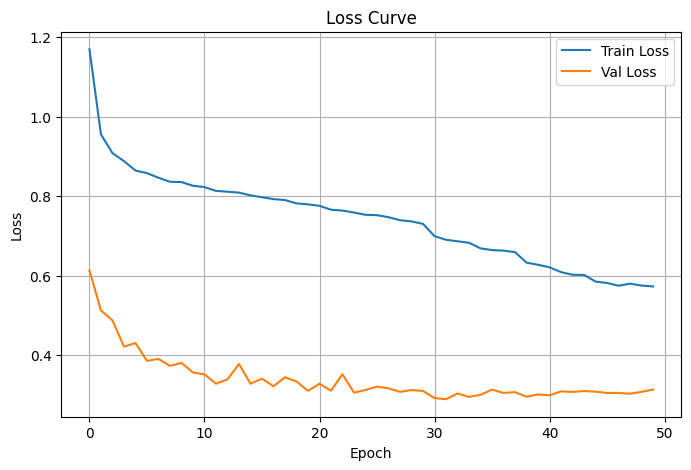

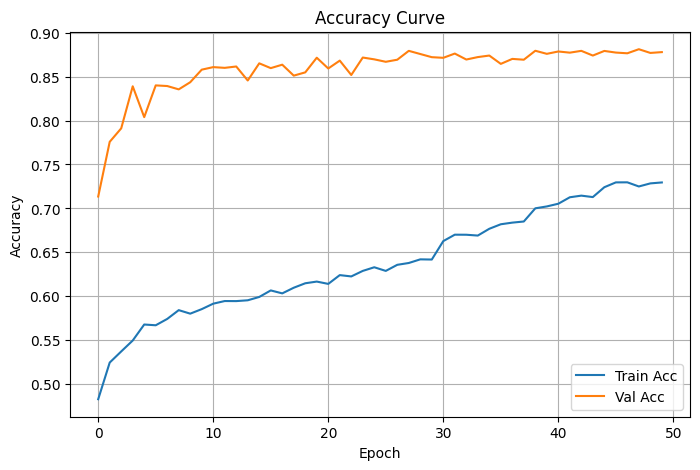

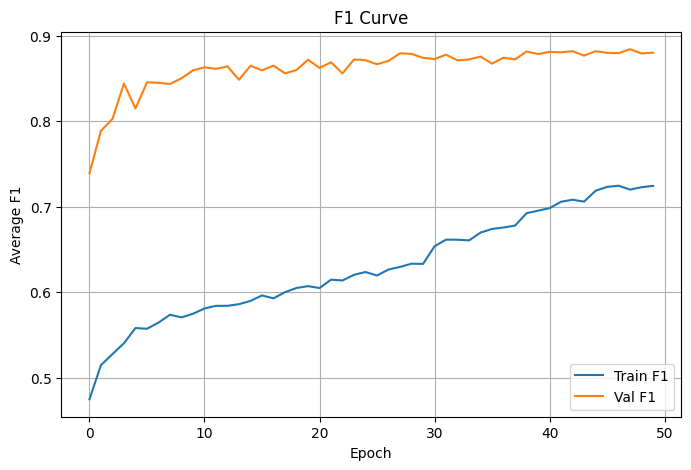


=== Final Evaluation Results ===
Accuracy     : 0.8810
Macro F1     : 0.8848
Micro F1     : 0.8810
Weighted F1  : 0.8810
Cohen's Kappa: 0.8042

Per-class F1 scores:
  Class 0: 0.8793
  Class 1: 0.8978
  Class 2: 0.8773

Confusion Matrix:
[[765602  18275  87157]
 [ 14623 237254   8898]
 [ 90139  12209 709559]]
Saved results to results/true_BCNN_data_predictive_entropy_results.json

=== Run 13/13 — true_BCNN_data_variation_ratio ===
X:  (14000, 28, 6)
y:  (14000,)
Before Normalisation

Global Mean: -0.0137
Global Std Dev: 0.8864

Per-Band Statistics:
  Band      Mean      Std
Band 1 -0.018006 0.917268
Band 2  0.015966 0.899146
Band 3 -0.002236 0.891937
Band 4 -0.071605 0.836430
Band 5  0.005806 0.885820
Band 6 -0.011920 0.882725

Class Distribution:
 Class  Count  Percentage
     0   6255   44.678571
     1   1672   11.942857
     2   6073   43.378571


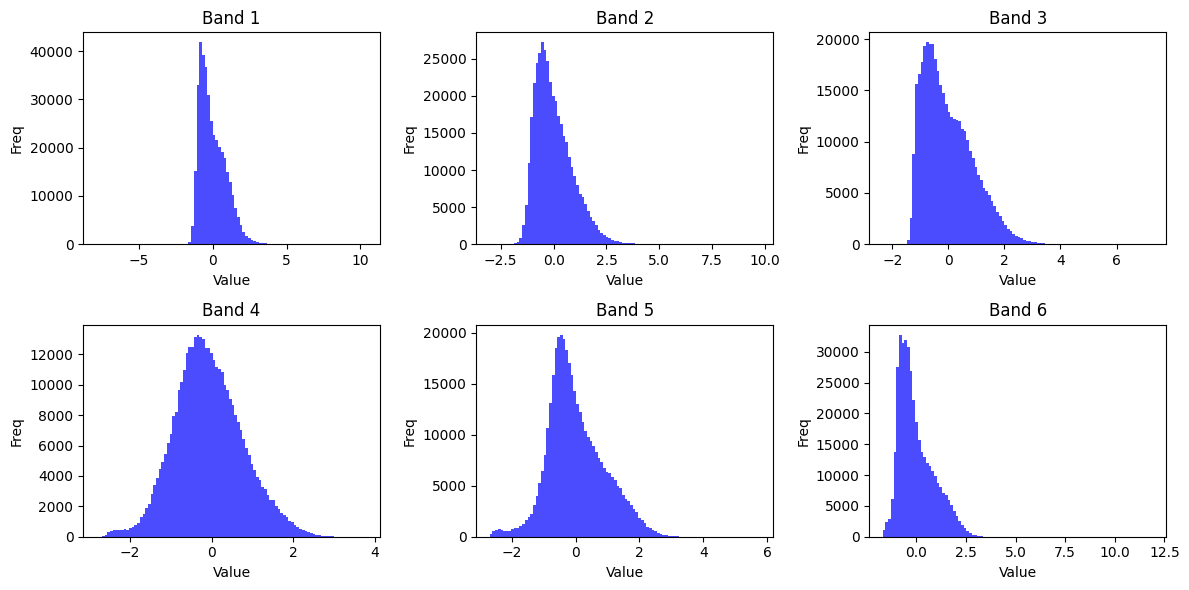

After Normalisation

Global Mean: -0.0000
Global Std Dev: 1.0001

Per-Band Statistics:
  Band          Mean      Std
Band 1  2.180255e-07 1.000001
Band 2 -2.188093e-07 0.999999
Band 3  6.648457e-08 1.000010
Band 4 -5.822650e-07 0.999998
Band 5 -1.712703e-07 1.000003
Band 6  2.124389e-08 1.000002

Class Distribution:
 Class  Count  Percentage
     0   6255   44.678571
     1   1672   11.942857
     2   6073   43.378571


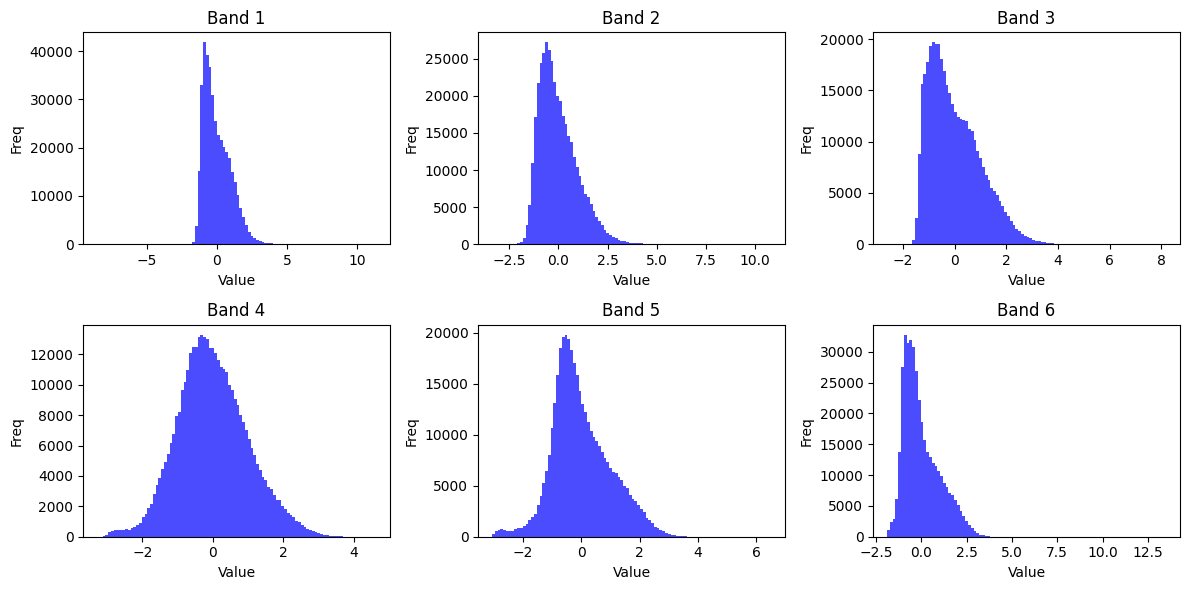

Class Weights: tensor([0.7461, 2.7911, 0.7684], device='cuda:0')



Epoch 1/50
Train — Loss: 1.1020 | Acc: 0.5079 | Avg F1: 0.4981
Val   — Loss: 0.3991 | Acc: 0.8339 | Avg F1: 0.8354



Epoch 2/50
Train — Loss: 0.8470 | Acc: 0.5544 | Avg F1: 0.5462
Val   — Loss: 0.4360 | Acc: 0.7443 | Avg F1: 0.7536



Epoch 3/50
Train — Loss: 0.8078 | Acc: 0.5647 | Avg F1: 0.5562
Val   — Loss: 0.3575 | Acc: 0.8527 | Avg F1: 0.8505



Epoch 4/50
Train — Loss: 0.7859 | Acc: 0.5742 | Avg F1: 0.5642
Val   — Loss: 0.3843 | Acc: 0.8328 | Avg F1: 0.8386



Epoch 5/50
Train — Loss: 0.7712 | Acc: 0.5790 | Avg F1: 0.5691
Val   — Loss: 0.3289 | Acc: 0.8681 | Avg F1: 0.8642



Epoch 6/50
Train — Loss: 0.7530 | Acc: 0.5871 | Avg F1: 0.5771
Val   — Loss: 0.3395 | Acc: 0.8680 | Avg F1: 0.8649



Epoch 7/50
Train — Loss: 0.7409 | Acc: 0.5968 | Avg F1: 0.5867
Val   — Loss: 0.3478 | Acc: 0.8560 | Avg F1: 0.8529



Epoch 8/50
Train — Loss: 0.7326 | Acc: 0.6029 | Avg F1: 0.5917
Val   — Loss: 0.3422 | Acc: 0.8576 | Avg F1: 0.8569



Epoch 9/50
Train — Loss: 0.7316 | Acc: 0.6008 | Avg F1: 0.5888
Val   — Loss: 0.3168 | Acc: 0.8702 | Avg F1: 0.8689



Epoch 10/50
Train — Loss: 0.7227 | Acc: 0.6037 | Avg F1: 0.5923
Val   — Loss: 0.3286 | Acc: 0.8672 | Avg F1: 0.8614



Epoch 11/50
Train — Loss: 0.7101 | Acc: 0.6108 | Avg F1: 0.6003
Val   — Loss: 0.3106 | Acc: 0.8771 | Avg F1: 0.8725



Epoch 12/50
Train — Loss: 0.7108 | Acc: 0.6087 | Avg F1: 0.5982
Val   — Loss: 0.3275 | Acc: 0.8736 | Avg F1: 0.8681



Epoch 13/50
Train — Loss: 0.7044 | Acc: 0.6152 | Avg F1: 0.6035
Val   — Loss: 0.3226 | Acc: 0.8696 | Avg F1: 0.8624



Epoch 14/50
Train — Loss: 0.6998 | Acc: 0.6156 | Avg F1: 0.6046
Val   — Loss: 0.3134 | Acc: 0.8748 | Avg F1: 0.8694



Epoch 15/50
Train — Loss: 0.6918 | Acc: 0.6220 | Avg F1: 0.6101
Val   — Loss: 0.3165 | Acc: 0.8765 | Avg F1: 0.8696



Epoch 16/50
Train — Loss: 0.6925 | Acc: 0.6186 | Avg F1: 0.6068
Val   — Loss: 0.3232 | Acc: 0.8795 | Avg F1: 0.8762



Epoch 17/50
Train — Loss: 0.6822 | Acc: 0.6276 | Avg F1: 0.6160
Val   — Loss: 0.2908 | Acc: 0.8883 | Avg F1: 0.8837



Epoch 18/50
Train — Loss: 0.6766 | Acc: 0.6304 | Avg F1: 0.6195
Val   — Loss: 0.3068 | Acc: 0.8836 | Avg F1: 0.8807



Epoch 19/50
Train — Loss: 0.6724 | Acc: 0.6336 | Avg F1: 0.6233
Val   — Loss: 0.3232 | Acc: 0.8646 | Avg F1: 0.8636



Epoch 20/50
Train — Loss: 0.6689 | Acc: 0.6330 | Avg F1: 0.6221
Val   — Loss: 0.3126 | Acc: 0.8814 | Avg F1: 0.8784



Epoch 21/50
Train — Loss: 0.6649 | Acc: 0.6340 | Avg F1: 0.6230
Val   — Loss: 0.2904 | Acc: 0.8816 | Avg F1: 0.8785



Epoch 22/50
Train — Loss: 0.6620 | Acc: 0.6354 | Avg F1: 0.6250
Val   — Loss: 0.3126 | Acc: 0.8754 | Avg F1: 0.8731



Epoch 23/50
Train — Loss: 0.6542 | Acc: 0.6372 | Avg F1: 0.6282
Val   — Loss: 0.3116 | Acc: 0.8728 | Avg F1: 0.8706



Epoch 24/50
Train — Loss: 0.6464 | Acc: 0.6446 | Avg F1: 0.6350
Val   — Loss: 0.3002 | Acc: 0.8766 | Avg F1: 0.8745



Epoch 25/50
Train — Loss: 0.6450 | Acc: 0.6503 | Avg F1: 0.6395
Val   — Loss: 0.2834 | Acc: 0.8881 | Avg F1: 0.8865



Epoch 26/50
Train — Loss: 0.6429 | Acc: 0.6519 | Avg F1: 0.6418
Val   — Loss: 0.3302 | Acc: 0.8614 | Avg F1: 0.8617



Epoch 27/50
Train — Loss: 0.6343 | Acc: 0.6560 | Avg F1: 0.6469
Val   — Loss: 0.3113 | Acc: 0.8743 | Avg F1: 0.8735



Epoch 28/50
Train — Loss: 0.6346 | Acc: 0.6516 | Avg F1: 0.6404
Val   — Loss: 0.3019 | Acc: 0.8738 | Avg F1: 0.8716



Epoch 29/50
Train — Loss: 0.6296 | Acc: 0.6547 | Avg F1: 0.6445
Val   — Loss: 0.2750 | Acc: 0.8857 | Avg F1: 0.8815



Epoch 30/50
Train — Loss: 0.6200 | Acc: 0.6589 | Avg F1: 0.6499
Val   — Loss: 0.2840 | Acc: 0.8849 | Avg F1: 0.8800



Epoch 31/50
Train — Loss: 0.6133 | Acc: 0.6648 | Avg F1: 0.6556
Val   — Loss: 0.2886 | Acc: 0.8826 | Avg F1: 0.8783



Epoch 32/50
Train — Loss: 0.6082 | Acc: 0.6716 | Avg F1: 0.6629
Val   — Loss: 0.3161 | Acc: 0.8628 | Avg F1: 0.8610



Epoch 33/50
Train — Loss: 0.6092 | Acc: 0.6669 | Avg F1: 0.6585
Val   — Loss: 0.3058 | Acc: 0.8785 | Avg F1: 0.8745



Epoch 34/50
Train — Loss: 0.6031 | Acc: 0.6664 | Avg F1: 0.6581
Val   — Loss: 0.2854 | Acc: 0.8859 | Avg F1: 0.8825



Epoch 35/50
Train — Loss: 0.5922 | Acc: 0.6784 | Avg F1: 0.6698
Val   — Loss: 0.2908 | Acc: 0.8829 | Avg F1: 0.8790



Epoch 36/50
Train — Loss: 0.5672 | Acc: 0.6875 | Avg F1: 0.6793
Val   — Loss: 0.2759 | Acc: 0.8886 | Avg F1: 0.8861



Epoch 37/50
Train — Loss: 0.5508 | Acc: 0.6961 | Avg F1: 0.6899
Val   — Loss: 0.2685 | Acc: 0.9012 | Avg F1: 0.8967



Epoch 38/50
Train — Loss: 0.5457 | Acc: 0.7015 | Avg F1: 0.6947
Val   — Loss: 0.2715 | Acc: 0.8909 | Avg F1: 0.8870



Epoch 39/50
Train — Loss: 0.5383 | Acc: 0.7065 | Avg F1: 0.7010
Val   — Loss: 0.2778 | Acc: 0.8925 | Avg F1: 0.8906



Epoch 40/50
Train — Loss: 0.5339 | Acc: 0.7127 | Avg F1: 0.7075
Val   — Loss: 0.2740 | Acc: 0.8919 | Avg F1: 0.8890



Epoch 41/50
Train — Loss: 0.5335 | Acc: 0.7085 | Avg F1: 0.7019
Val   — Loss: 0.2764 | Acc: 0.8927 | Avg F1: 0.8887



Epoch 42/50
Train — Loss: 0.5150 | Acc: 0.7226 | Avg F1: 0.7177
Val   — Loss: 0.2743 | Acc: 0.8916 | Avg F1: 0.8877



Epoch 43/50
Train — Loss: 0.5141 | Acc: 0.7159 | Avg F1: 0.7126
Val   — Loss: 0.2756 | Acc: 0.8948 | Avg F1: 0.8914



Epoch 44/50
Train — Loss: 0.4946 | Acc: 0.7313 | Avg F1: 0.7271
Val   — Loss: 0.2701 | Acc: 0.8983 | Avg F1: 0.8949



Epoch 45/50
Train — Loss: 0.4927 | Acc: 0.7324 | Avg F1: 0.7291
Val   — Loss: 0.2660 | Acc: 0.9019 | Avg F1: 0.8981



Epoch 46/50
Train — Loss: 0.4792 | Acc: 0.7424 | Avg F1: 0.7383
Val   — Loss: 0.2719 | Acc: 0.9010 | Avg F1: 0.8979



Epoch 47/50
Train — Loss: 0.4730 | Acc: 0.7454 | Avg F1: 0.7450
Val   — Loss: 0.2753 | Acc: 0.8997 | Avg F1: 0.8964



Epoch 48/50
Train — Loss: 0.4683 | Acc: 0.7426 | Avg F1: 0.7420
Val   — Loss: 0.2817 | Acc: 0.8999 | Avg F1: 0.8973



Epoch 49/50
Train — Loss: 0.4702 | Acc: 0.7458 | Avg F1: 0.7441
Val   — Loss: 0.2746 | Acc: 0.8995 | Avg F1: 0.8972



Epoch 50/50
Train — Loss: 0.4698 | Acc: 0.7444 | Avg F1: 0.7433
Val   — Loss: 0.2753 | Acc: 0.8993 | Avg F1: 0.8977


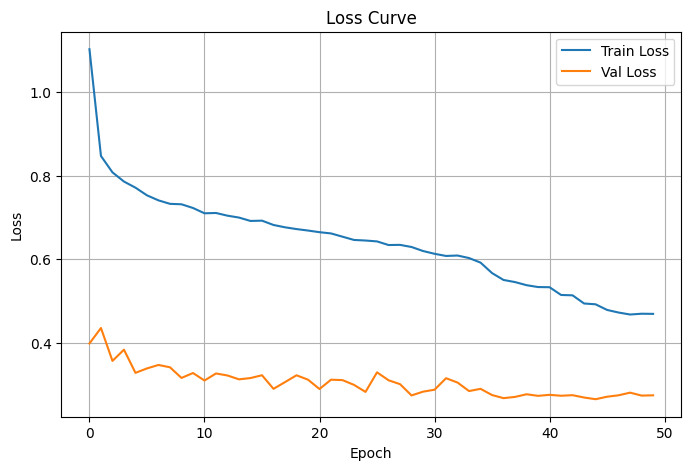

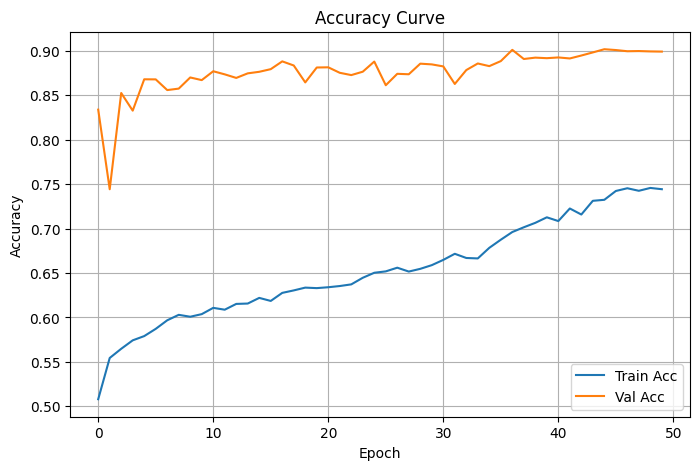

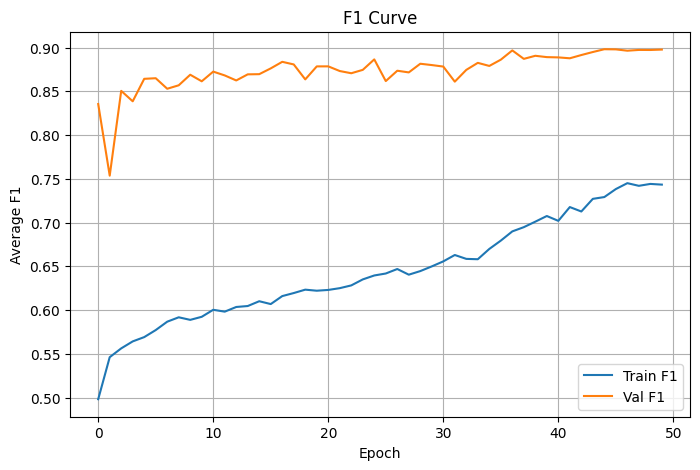


=== Final Evaluation Results ===
Accuracy     : 0.9013
Macro F1     : 0.9015
Micro F1     : 0.9013
Weighted F1  : 0.9013
Cohen's Kappa: 0.8381

Per-class F1 scores:
  Class 0: 0.9030
  Class 1: 0.9024
  Class 2: 0.8992

Confusion Matrix:
[[781453  20013  69568]
 [  8687 243449   8639]
 [ 69527  15314 727066]]
Saved results to results/true_BCNN_data_variation_ratio_results.json


In [76]:
data_paths = sorted(glob.glob(os.path.join(base_dir, "*.npz")))

print("Found .npz files:")
for p in data_paths:
    print(" -", p)

all_runs = []

for i, path in enumerate(data_paths):

    fname = os.path.splitext(os.path.basename(path))[0]
    print(f"\n=== Run {i+1}/{len(data_paths)} — {fname} ===")

    #Loading data
    X_final_labeled, y_final_labeled = load_xy_from_npz(path)
    print("X: ",X_final_labeled.shape)
    print("y: ",y_final_labeled.shape)

    #transposing to correct shape
    if X_final_labeled.shape[1:] == (6,28):
        X_final_labeled = X_final_labeled.transpose(0,2,1)
    
    #normalising and printing stats
    print("Before Normalisation")
    print(f"\nGlobal Mean: {X_final_labeled.mean():.4f}")
    print(f"Global Std Dev: {X_final_labeled.std():.4f}")
    band_means, band_stds = compute_band_means_stds(X_final_labeled)
    print_stats_and_class_distribution(band_means, band_stds, y_final_labeled)
    plot_band_histograms(X_final_labeled)
    
    X_final_labeled = normalize_data(X_final_labeled, band_means, band_stds)
    
    print("After Normalisation")
    print(f"\nGlobal Mean: {X_final_labeled.mean():.4f}")
    print(f"Global Std Dev: {X_final_labeled.std():.4f}")
    band_means, band_stds = compute_band_means_stds(X_final_labeled)
    print_stats_and_class_distribution(band_means, band_stds, y_final_labeled)
    plot_band_histograms(X_final_labeled)
    
    #getting class weights
    class_weights = compute_class_weights(y_final_labeled, device=device)
    print(f"Class Weights: {class_weights}")

    #loading datasets
    train_dataset = Dataset(X_final_labeled, y_final_labeled)
    val_dataset = Dataset(X_val, y_val)
    test_dataset = Dataset(X,y)

    model.load_state_dict(copy.deepcopy(initial_state_dict))
    
    #Training
    epoch_stats = learning_loop(
        model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        device=device,
        final_epochs=epochs,
        loss_mode=loss_mode,
        batch_size=batch_size,
        class_weights = class_weights
    )

    #Final evaluation
    results = evaluate_model(model, test_dataset, device="cuda")

    #Saving results
    run_data = {
        "file": path,
        "epoch_stats": epoch_stats,
        "final_results": results
    }

    all_runs.append(run_data)
  
    out_path = os.path.join("results", f"{fname}_results.json")
    save_json(run_data, out_path)
    print(f"Saved results to {out_path}")

# Save summary
save_json(all_runs, os.path.join("results", "all_deterministic_results.json"))


